In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import sleep
from os import listdir
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation as FA

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

import random
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

📌 Loading the data:

There are 100 trajectories of engine degradation in EACH of the datasets (train and test).  
For the train data, each engine is run from a certain normal condition till failure.  
For the test data, each engine is NOT run until failure (or we have data until a specific point of the engine's state). The amount of time cycles left for this engine to still be 'normal' is what we call RUL, or Remaining Useful Lifetime.
> **Predicting what the RUL is for the last state of each machine in the test set will be our prediction task.**

In [4]:
data_dir = "datasets"

listdir(data_dir)

file_name = 'FD001.txt'

# Use os.path.join for cross-platform compatibility
train_file_path = os.path.join(data_dir, 'train_' + file_name)
test_file_path = os.path.join(data_dir, 'test_' + file_name)
rul_file_path = os.path.join(data_dir, 'RUL_' + file_name)

# Load data using the new paths
df_train = pd.read_csv(train_file_path, header = None, sep = r'\s+')
df_test = pd.read_csv(test_file_path, header = None, sep = r'\s+')
rul_test = pd.read_csv(rul_file_path, header = None)

for df in [df_train, df_test, rul_test]:
    display(df.head())

0   1       2       3      4       5       6        7        8      9   \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

      10      11       12       13   14     15      16       17       18  \
0  21.61  554.36  2388.06  9046.19  1.3  47.47  521.66  2388.02  8138.62   
1  21.61  553.75  2388.04  9044.07  1.3  47.49  522.28  2388.07  8131.49   
2  21.61  554.26  2388.08  9052.94  1.3  47.27  522.42  2388.03  8133.23   
3  21.61  554.45  2388.11  9049.48  1.3  47.13  522.86  2388.08  8133.83   
4  21.61  554.00  2388.06  9055.15  1.3  47.28  522.19  2388.04  8133.80   

       19    20   21    22     23     24       25  
0  8.4195  0.03  392  2388  100.0  39.06  23.4190  
1  8.4318  0.03  392  2388  100.0  39.00  23.4236  
2  8.4178  0.03  390  2388  100.0  38.95  23.3442  
3  8.3682  0.03  392  2388  100.0  38.88  23.3739  
4  8.4294  0.03  393  2388  100.0  38.90  23.4044

0   1       2       3      4       5       6        7        8      9   \
0   1   1  0.0023  0.0003  100.0  518.67  643.02  1585.29  1398.21  14.62   
1   1   2 -0.0027 -0.0003  100.0  518.67  641.71  1588.45  1395.42  14.62   
2   1   3  0.0003  0.0001  100.0  518.67  642.46  1586.94  1401.34  14.62   
3   1   4  0.0042  0.0000  100.0  518.67  642.44  1584.12  1406.42  14.62   
4   1   5  0.0014  0.0000  100.0  518.67  642.51  1587.19  1401.92  14.62   

      10      11       12       13   14     15      16       17       18  \
0  21.61  553.90  2388.04  9050.17  1.3  47.20  521.72  2388.03  8125.55   
1  21.61  554.85  2388.01  9054.42  1.3  47.50  522.16  2388.06  8139.62   
2  21.61  554.11  2388.05  9056.96  1.3  47.50  521.97  2388.03  8130.10   
3  21.61  554.07  2388.03  9045.29  1.3  47.28  521.38  2388.05  8132.90   
4  21.61  554.16  2388.01  9044.55  1.3  47.31  522.15  2388.03  8129.54   

       19    20   21    22     23     24       25  
0  8.4052  0.03  392  2388  100.0  38.86  23.3735  
1  8.3803  0.03  393  2388  100.0  39.02  23.3916  
2  8.4441  0.03  393  2388  100.0  39.08  23.4166  
3  8.3917  0.03  391  2388  100.0  39.00  23.3737  
4  8.4031  0.03  390  2388  100.0  38.99  23.4130

0
0  112
1   98
2   69
3   82
4   91

📌 Attaching column names: We have three operational setting columns (**os + number**), and 21 sensor columns (**s + number**). We have dropped the last two columns containing NaNs.

In [5]:
col_names = []

col_names.append('unit')
col_names.append('time')

for i in range(1,4):
    col_names.append('os'+str(i))
for i in range(1,22):
    col_names.append('s'+str(i))

df_train.columns = col_names
display(df_train.head())

df_test.columns = col_names
display(df_test.head())

unit  time     os1     os2    os3      s1      s2       s3       s4     s5  \
0     1     1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1     1     2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2     1     3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3     1     4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4     1     5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

      s6      s7       s8       s9  s10    s11     s12      s13      s14  \
0  21.61  554.36  2388.06  9046.19  1.3  47.47  521.66  2388.02  8138.62   
1  21.61  553.75  2388.04  9044.07  1.3  47.49  522.28  2388.07  8131.49   
2  21.61  554.26  2388.08  9052.94  1.3  47.27  522.42  2388.03  8133.23   
3  21.61  554.45  2388.11  9049.48  1.3  47.13  522.86  2388.08  8133.83   
4  21.61  554.00  2388.06  9055.15  1.3  47.28  522.19  2388.04  8133.80   

      s15   s16  s17   s18    s19    s20      s21  
0  8.4195  0.03  392  2388  100.0  39.06  23.4190  
1  8.4318  0.03  392  2388  100.0  39.00  23.4236  
2  8.4178  0.03  390  2388  100.0  38.95  23.3442  
3  8.3682  0.03  392  2388  100.0  38.88  23.3739  
4  8.4294  0.03  393  2388  100.0  38.90  23.4044

unit  time     os1     os2    os3      s1      s2       s3       s4     s5  \
0     1     1  0.0023  0.0003  100.0  518.67  643.02  1585.29  1398.21  14.62   
1     1     2 -0.0027 -0.0003  100.0  518.67  641.71  1588.45  1395.42  14.62   
2     1     3  0.0003  0.0001  100.0  518.67  642.46  1586.94  1401.34  14.62   
3     1     4  0.0042  0.0000  100.0  518.67  642.44  1584.12  1406.42  14.62   
4     1     5  0.0014  0.0000  100.0  518.67  642.51  1587.19  1401.92  14.62   

      s6      s7       s8       s9  s10    s11     s12      s13      s14  \
0  21.61  553.90  2388.04  9050.17  1.3  47.20  521.72  2388.03  8125.55   
1  21.61  554.85  2388.01  9054.42  1.3  47.50  522.16  2388.06  8139.62   
2  21.61  554.11  2388.05  9056.96  1.3  47.50  521.97  2388.03  8130.10   
3  21.61  554.07  2388.03  9045.29  1.3  47.28  521.38  2388.05  8132.90   
4  21.61  554.16  2388.01  9044.55  1.3  47.31  522.15  2388.03  8129.54   

      s15   s16  s17   s18    s19    s20      s21  
0  8.4052  0.03  392  2388  100.0  38.86  23.3735  
1  8.3803  0.03  393  2388  100.0  39.02  23.3916  
2  8.4441  0.03  393  2388  100.0  39.08  23.4166  
3  8.3917  0.03  391  2388  100.0  39.00  23.3737  
4  8.4031  0.03  390  2388  100.0  38.99  23.4130

📌 Attaching RUL(remaining useful lifetime) values to the datasets.

For the train data, the RUL values are not specified, but the document regarding this dataset specifies that for the training data, all the engines were run to failure. Thus, for example, if we had five rows for a specific unit, say unit 7:

|unit|time cycle|
|--|--|
|7|1|
|7|2|
|7|3|
|7|4|
|7|5|

Then we know that the last row is when the RUL value becomes 0 (failure), so the RUL for this unit would be attached in this way:

|unit|time cycle|RUL|
|--|--|--|
|7|1|**4**|
|7|2|**3**|
|7|3|**2**|
|7|4|**1**|
|7|5|**0**|

For the test data, we have the 'solutions' for the test engines in a separate file called rul_test (the name that I used for dataframe). I will use that to attach the RUL values for the test as well.

In [6]:
max(df_train['unit'])

100

In [7]:
rul_list = []
engine_numbers = max(df_train['unit'])
for n in np.arange(1,engine_numbers+1):
    
    time_list = np.array(df_train[df_train['unit'] == n]['time'])
    length = len(time_list)
    rul = list(length - time_list)
    rul_list += rul
    
df_train['rul'] = rul_list

rul_list = []

for n in np.arange(1,engine_numbers+1):
    
    time_list = np.array(df_test[df_test['unit'] == n]['time'])
    length = len(time_list)
    rul_val = rul_test.iloc[n-1].item()
    rul = list(length - time_list + rul_val)
    rul_list += rul

df_test['rul'] = rul_list

for df in [df_train, df_test]:
    display(df.head())

unit  time     os1     os2    os3      s1      s2       s3       s4     s5  \
0     1     1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1     1     2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2     1     3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3     1     4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4     1     5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

      s6      s7       s8       s9  s10    s11     s12      s13      s14  \
0  21.61  554.36  2388.06  9046.19  1.3  47.47  521.66  2388.02  8138.62   
1  21.61  553.75  2388.04  9044.07  1.3  47.49  522.28  2388.07  8131.49   
2  21.61  554.26  2388.08  9052.94  1.3  47.27  522.42  2388.03  8133.23   
3  21.61  554.45  2388.11  9049.48  1.3  47.13  522.86  2388.08  8133.83   
4  21.61  554.00  2388.06  9055.15  1.3  47.28  522.19  2388.04  8133.80   

      s15   s16  s17   s18    s19    s20      s21  rul  
0  8.4195  0.03  392  2388  100.0  39.06  23.4190  191  
1  8.4318  0.03  392  2388  100.0  39.00  23.4236  190  
2  8.4178  0.03  390  2388  100.0  38.95  23.3442  189  
3  8.3682  0.03  392  2388  100.0  38.88  23.3739  188  
4  8.4294  0.03  393  2388  100.0  38.90  23.4044  187

unit  time     os1     os2    os3      s1      s2       s3       s4     s5  \
0     1     1  0.0023  0.0003  100.0  518.67  643.02  1585.29  1398.21  14.62   
1     1     2 -0.0027 -0.0003  100.0  518.67  641.71  1588.45  1395.42  14.62   
2     1     3  0.0003  0.0001  100.0  518.67  642.46  1586.94  1401.34  14.62   
3     1     4  0.0042  0.0000  100.0  518.67  642.44  1584.12  1406.42  14.62   
4     1     5  0.0014  0.0000  100.0  518.67  642.51  1587.19  1401.92  14.62   

      s6      s7       s8       s9  s10    s11     s12      s13      s14  \
0  21.61  553.90  2388.04  9050.17  1.3  47.20  521.72  2388.03  8125.55   
1  21.61  554.85  2388.01  9054.42  1.3  47.50  522.16  2388.06  8139.62   
2  21.61  554.11  2388.05  9056.96  1.3  47.50  521.97  2388.03  8130.10   
3  21.61  554.07  2388.03  9045.29  1.3  47.28  521.38  2388.05  8132.90   
4  21.61  554.16  2388.01  9044.55  1.3  47.31  522.15  2388.03  8129.54   

      s15   s16  s17   s18    s19    s20      s21  rul  
0  8.4052  0.03  392  2388  100.0  38.86  23.3735  142  
1  8.3803  0.03  393  2388  100.0  39.02  23.3916  141  
2  8.4441  0.03  393  2388  100.0  39.08  23.4166  140  
3  8.3917  0.03  391  2388  100.0  39.00  23.3737  139  
4  8.4031  0.03  390  2388  100.0  38.99  23.4130  138

Below, we can see an example of all the sensor values of a specific engine in the training set (unit 4), as the engine progresses toward failure.

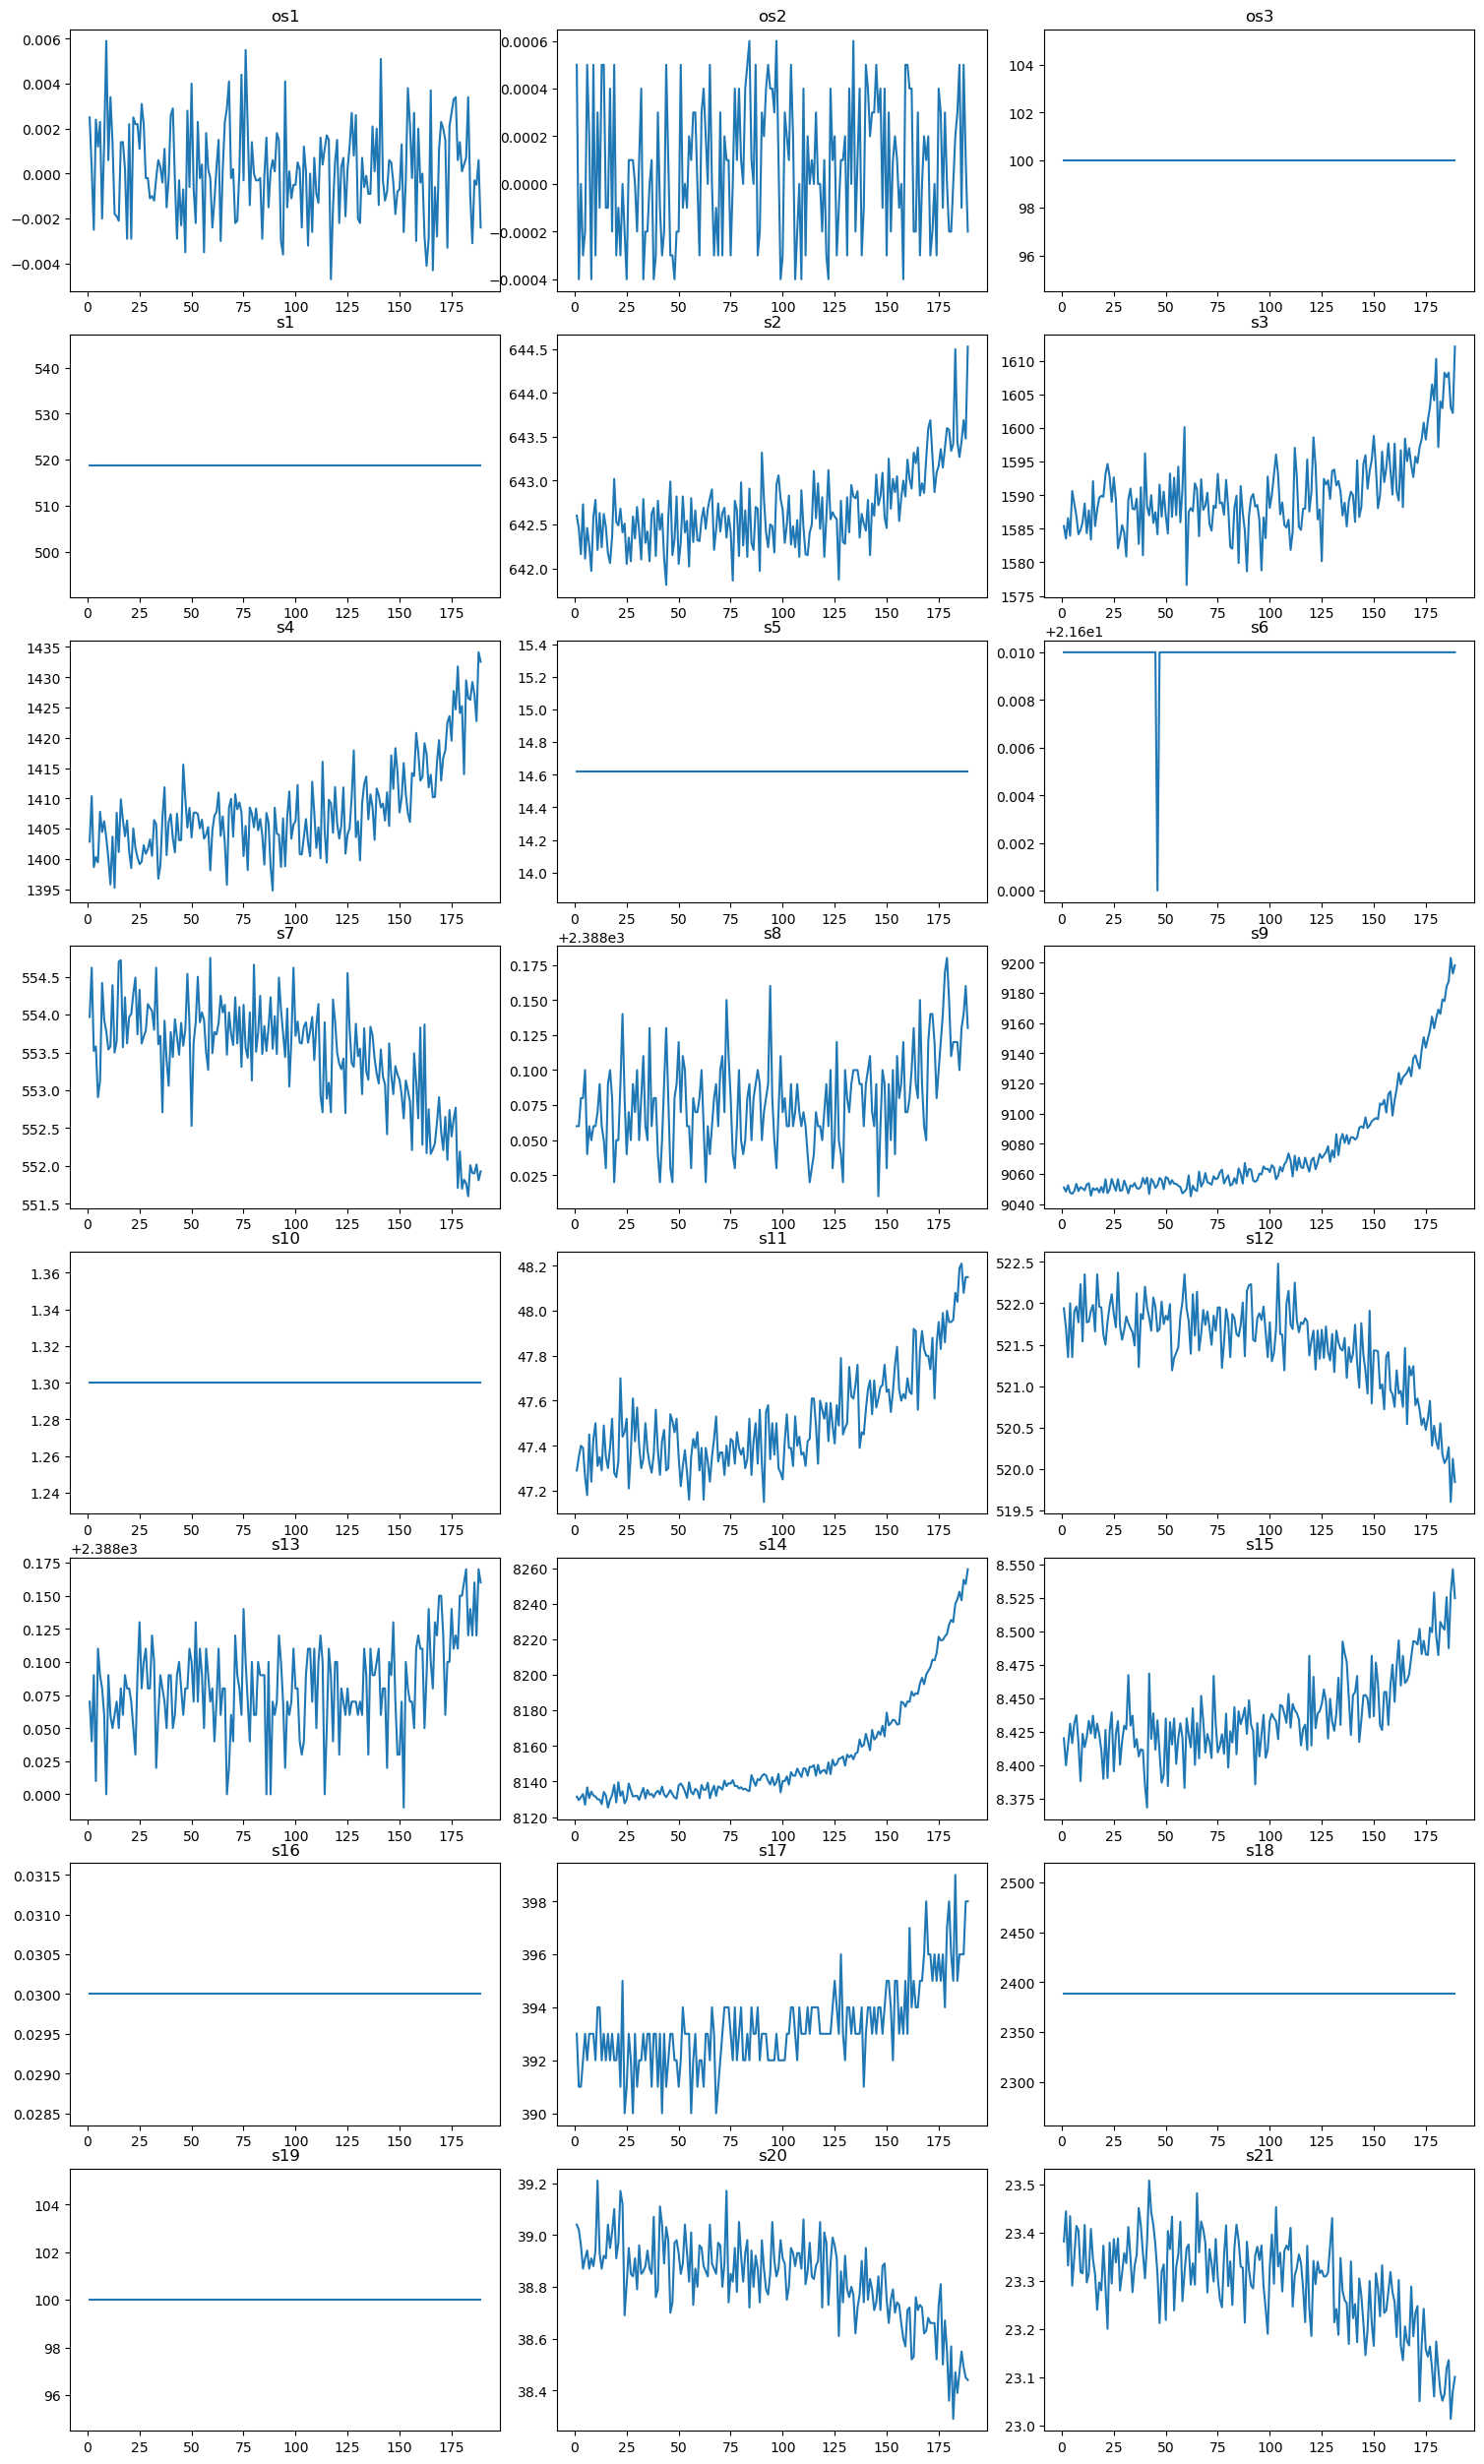

In [8]:
sample = 4
sample_df = df_train[df_train['unit'] == sample].copy()

fig, axes = plt.subplots(8,3, figsize = (15,25))
fig.tight_layout()

j = -1
for c in df_train.columns:
    
    if 's' in c:
        j += 1
        axes[j // 3, j % 3].plot(sample_df['time'], sample_df[c])
        axes[j // 3, j % 3].set_title(c)

save_dir = "plots"
filename_dist = os.path.join(save_dir, f"feature_distributions_engine_4.png")
plt.savefig(filename_dist, dpi=600, bbox_inches='tight')

We plot the sensor data obtained from sensor 2 for 5 of the engines to show a general trend.


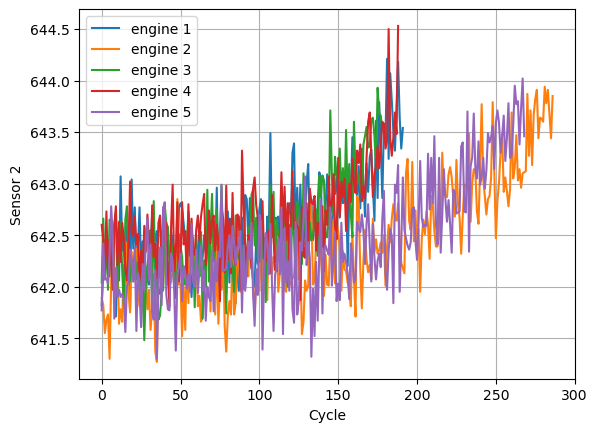

In [9]:
sensor = 's2'
for sample in range(1,6):
    sample_df = df_train[df_train['unit'] == sample].copy()
    sensordata = sample_df[sensor].to_numpy()
    plt.plot(sensordata, label = "engine "+str(sample))
plt.grid()
plt.legend()
plt.ylabel('Sensor 2')
plt.xlabel('Cycle')
plt.show()

We can notice here, that there are multiple sensors which are not changing its value. Perhaps, they are not useful features for prediction. Would they have similar behaviors for other engine units as well? Below show that yes (standard deviation is 0, or practically 0).

In [10]:
df_train[['os3','s1','s5','s6','s10','s16','s18','s19']].describe()

os3        s1            s5            s6      s10           s16  \
count  20631.0  20631.00  2.063100e+04  20631.000000  20631.0  2.063100e+04   
mean     100.0    518.67  1.462000e+01     21.609803      1.3  3.000000e-02   
std        0.0      0.00  1.776400e-15      0.001389      0.0  1.387812e-17   
min      100.0    518.67  1.462000e+01     21.600000      1.3  3.000000e-02   
25%      100.0    518.67  1.462000e+01     21.610000      1.3  3.000000e-02   
50%      100.0    518.67  1.462000e+01     21.610000      1.3  3.000000e-02   
75%      100.0    518.67  1.462000e+01     21.610000      1.3  3.000000e-02   
max      100.0    518.67  1.462000e+01     21.610000      1.3  3.000000e-02   

           s18      s19  
count  20631.0  20631.0  
mean    2388.0    100.0  
std        0.0      0.0  
min     2388.0    100.0  
25%     2388.0    100.0  
50%     2388.0    100.0  
75%     2388.0    100.0  
max     2388.0    100.0

📌 Previously mentioned columns are dropped.

In [11]:
#Drop os3, s1, s5, s6, s10, s16, s18, s19 from both train and test
drop_cols1 = ['os3','s1','s5','s6','s10','s16','s18','s19']

df_train = df_train.drop(drop_cols1, axis = 1)
df_test = df_test.drop(drop_cols1, axis = 1)

for df in [df_train, df_test]:
    display(df.head())

unit  time     os1     os2      s2       s3       s4      s7       s8  \
0     1     1 -0.0007 -0.0004  641.82  1589.70  1400.60  554.36  2388.06   
1     1     2  0.0019 -0.0003  642.15  1591.82  1403.14  553.75  2388.04   
2     1     3 -0.0043  0.0003  642.35  1587.99  1404.20  554.26  2388.08   
3     1     4  0.0007  0.0000  642.35  1582.79  1401.87  554.45  2388.11   
4     1     5 -0.0019 -0.0002  642.37  1582.85  1406.22  554.00  2388.06   

        s9    s11     s12      s13      s14     s15  s17    s20      s21  rul  
0  9046.19  47.47  521.66  2388.02  8138.62  8.4195  392  39.06  23.4190  191  
1  9044.07  47.49  522.28  2388.07  8131.49  8.4318  392  39.00  23.4236  190  
2  9052.94  47.27  522.42  2388.03  8133.23  8.4178  390  38.95  23.3442  189  
3  9049.48  47.13  522.86  2388.08  8133.83  8.3682  392  38.88  23.3739  188  
4  9055.15  47.28  522.19  2388.04  8133.80  8.4294  393  38.90  23.4044  187

unit  time     os1     os2      s2       s3       s4      s7       s8  \
0     1     1  0.0023  0.0003  643.02  1585.29  1398.21  553.90  2388.04   
1     1     2 -0.0027 -0.0003  641.71  1588.45  1395.42  554.85  2388.01   
2     1     3  0.0003  0.0001  642.46  1586.94  1401.34  554.11  2388.05   
3     1     4  0.0042  0.0000  642.44  1584.12  1406.42  554.07  2388.03   
4     1     5  0.0014  0.0000  642.51  1587.19  1401.92  554.16  2388.01   

        s9    s11     s12      s13      s14     s15  s17    s20      s21  rul  
0  9050.17  47.20  521.72  2388.03  8125.55  8.4052  392  38.86  23.3735  142  
1  9054.42  47.50  522.16  2388.06  8139.62  8.3803  393  39.02  23.3916  141  
2  9056.96  47.50  521.97  2388.03  8130.10  8.4441  393  39.08  23.4166  140  
3  9045.29  47.28  521.38  2388.05  8132.90  8.3917  391  39.00  23.3737  139  
4  9044.55  47.31  522.15  2388.03  8129.54  8.4031  390  38.99  23.4130  138

📌 Sensor values are Min-Max scaled.

$$scaled = \frac{original - min}{max - min}$$

Here, we apply the same max and min values (from the training set) to the test set.

In [12]:
#Minmax Scaling
minmax_dict = {}

for c in df_train.columns:
    if 's' in c:
        minmax_dict[c+'min'] = df_train[c].min()
        minmax_dict[c+'max']=  df_train[c].max()
        
for c in df_train.columns:
    if 's' in c:
        df_train[c] = (df_train[c] - minmax_dict[c+'min']) / (minmax_dict[c+'max'] - minmax_dict[c+'min'])
        
for c in df_test.columns:
    if 's' in c:
        df_test[c] = (df_test[c] - minmax_dict[c+'min']) / (minmax_dict[c+'max'] - minmax_dict[c+'min'])
        
for df in [df_train, df_test]:
    display(df.head())

unit  time       os1       os2        s2        s3        s4        s7  \
0     1     1  0.459770  0.166667  0.183735  0.406802  0.309757  0.726248   
1     1     2  0.609195  0.250000  0.283133  0.453019  0.352633  0.628019   
2     1     3  0.252874  0.750000  0.343373  0.369523  0.370527  0.710145   
3     1     4  0.540230  0.500000  0.343373  0.256159  0.331195  0.740741   
4     1     5  0.390805  0.333333  0.349398  0.257467  0.404625  0.668277   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.242424  0.109755  0.369048  0.633262  0.205882  0.199608  0.363986   
1  0.212121  0.100242  0.380952  0.765458  0.279412  0.162813  0.411312   
2  0.272727  0.140043  0.250000  0.795309  0.220588  0.171793  0.357445   
3  0.318182  0.124518  0.166667  0.889126  0.294118  0.174889  0.166603   
4  0.242424  0.149960  0.255952  0.746269  0.235294  0.174734  0.402078   

        s17       s20       s21  rul  
0  0.333333  0.713178  0.724662  191  
1  0.333333  0.666667  0.731014  190  
2  0.166667  0.627907  0.621375  189  
3  0.333333  0.573643  0.662386  188  
4  0.416667  0.589147  0.704502  187

unit  time       os1       os2        s2        s3        s4        s7  \
0     1     1  0.632184  0.750000  0.545181  0.310661  0.269413  0.652174   
1     1     2  0.344828  0.250000  0.150602  0.379551  0.222316  0.805153   
2     1     3  0.517241  0.583333  0.376506  0.346632  0.322248  0.685990   
3     1     4  0.741379  0.500000  0.370482  0.285154  0.408001  0.679549   
4     1     5  0.580460  0.500000  0.391566  0.352082  0.332039  0.694042   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.212121  0.127614  0.208333  0.646055  0.220588  0.132160  0.308965   
1  0.166667  0.146684  0.386905  0.739872  0.264706  0.204768  0.213159   
2  0.227273  0.158081  0.386905  0.699360  0.220588  0.155640  0.458638   
3  0.196970  0.105717  0.255952  0.573561  0.250000  0.170090  0.257022   
4  0.166667  0.102396  0.273810  0.737740  0.220588  0.152751  0.300885   

        s17       s20       s21  rul  
0  0.333333  0.558140  0.661834  142  
1  0.416667  0.682171  0.686827  141  
2  0.416667  0.728682  0.721348  140  
3  0.250000  0.666667  0.662110  139  
4  0.166667  0.658915  0.716377  138

📌 The time series for sensor values were noisy. If the time-series values are $t_1, t_2, t_3, ..., t_n$, then the smoothed values $v_1, v_2, ..., v_n$ with the parameter $\beta$ follow the following formula:

$$v_0 = 0, v_{t} = \frac{\beta v_{t-1} + (1-\beta) x_{t}}{1-\beta^{t}}$$

In [13]:
#Smoothing Function: Exponentially Weighted Averages

def smooth(s, b = 0.98):

    v = np.zeros(len(s)+1) #v_0 is already 0.
    bc = np.zeros(len(s)+1)

    for i in range(1, len(v)): #v_t = 0.95
        v[i] = (b * v[i-1] + (1-b) * s[i-1]) 
        bc[i] = 1 - b**i

    sm = v[1:] / bc[1:]
    
    return sm

s = [1,2,3,4,5]
print(s)
print(f'After Smoothing: {smooth(s)}')

[1, 2, 3, 4, 5]
After Smoothing: [1.         1.50505051 2.01346756 2.52525046 3.04039827]


In [14]:
#Smoothing each time series for each engine in both training and test sets

for c in df_train.columns:
    
    if 's' in c:
        sm_list = []

        for n in np.arange(1,101):
            s = np.array(df_train[df_train['unit'] == n][c].copy())
            sm = list(smooth(s, 0.98))
            sm_list += sm
        
        df_train[c+'_smoothed'] = sm_list
        
for c in df_test.columns:
    
    if 's' in c:
        sm_list = []

        for n in np.arange(1,101):
            s = np.array(df_test[df_test['unit'] == n][c].copy())
            sm = list(smooth(s, 0.98))
            sm_list += sm
        
        df_test[c+'_smoothed'] = sm_list

Let's take a look at how smoothed values (salmon) look compared to the original series (lightblue), for a particular sensor (unit 10 from train)

In [15]:
df_train.columns

Index(['unit', 'time', 'os1', 'os2', 's2', 's3', 's4', 's7', 's8', 's9', 's11',
       's12', 's13', 's14', 's15', 's17', 's20', 's21', 'rul', 'os1_smoothed',
       'os2_smoothed', 's2_smoothed', 's3_smoothed', 's4_smoothed',
       's7_smoothed', 's8_smoothed', 's9_smoothed', 's11_smoothed',
       's12_smoothed', 's13_smoothed', 's14_smoothed', 's15_smoothed',
       's17_smoothed', 's20_smoothed', 's21_smoothed'],
      dtype='object')

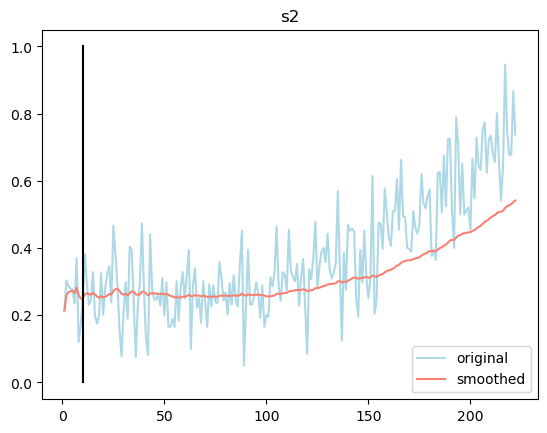

In [16]:
sample = 10
sample_df = df_train[df_train['unit'] == sample].copy()

# fig, axes = plt.subplots(6,3, figsize = (15,25))
fig = plt.figure()
# fig.tight_layout()

j = -1
c = 's2'
plt.plot(sample_df['time'], sample_df[c], c = 'lightblue', label = 'original')
plt.plot(sample_df['time'], sample_df[c+'_smoothed'], c = 'salmon', label = 'smoothed')
plt.plot([10,10],[0,1], c = 'black')
plt.title(c)
plt.legend()

save_dir = "plots"
filename_dist = os.path.join(save_dir, f"s2 original_vs_smoothed_values")
plt.savefig(filename_dist, dpi=300, bbox_inches='tight')

# for c in df_train.columns:
    
#     if ('s' in c) and ('smoothed' not in c):
#         j += 1
#         axes[j // 3, j % 3].plot(sample_df['time'], sample_df[c], c = 'lightblue', label = 'original')
#         axes[j // 3, j % 3].plot(sample_df['time'], sample_df[c+'_smoothed'], c = 'salmon', label = 'smoothed')
#         axes[j // 3, j % 3].plot([10,10],[0,1], c = 'black')
#         axes[j // 3, j % 3].set_title(c)
#         axes[j // 3, j % 3].legend()

In [17]:
#Remove the original series

for c in df_train.columns:
    if ('s' in c) and ('smoothed' not in c):
        df_train[c] = df_train[c+'_smoothed']
        df_train.drop(c+'_smoothed', axis = 1, inplace = True)
        
for c in df_test.columns:
    if ('s' in c) and ('smoothed' not in c):
        df_test[c] = df_test[c+'_smoothed']
        df_test.drop(c+'_smoothed', axis = 1, inplace = True)
        
for df in [df_train, df_test]:
    display(df.head())

unit  time       os1       os2        s2        s3        s4        s7  \
0     1     1  0.459770  0.166667  0.183735  0.406802  0.309757  0.726248   
1     1     2  0.535237  0.208754  0.233936  0.430144  0.331412  0.676638   
2     1     3  0.439208  0.392826  0.271154  0.409527  0.344714  0.688033   
3     1     4  0.465234  0.420437  0.289760  0.370016  0.341231  0.701612   
4     1     5  0.449741  0.402305  0.302174  0.346587  0.354428  0.694673   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.242424  0.109755  0.369048  0.633262  0.205882  0.199608  0.363986   
1  0.227120  0.104951  0.375060  0.700028  0.243018  0.181025  0.387888   
2  0.242630  0.116885  0.332528  0.732432  0.235390  0.177885  0.377535   
3  0.262094  0.118852  0.289798  0.772801  0.250520  0.177113  0.323193   
4  0.258000  0.125327  0.282753  0.767278  0.247350  0.176618  0.339614   

        s17       s20       s21  rul  
0  0.333333  0.713178  0.724662  191  
1  0.333333  0.689688  0.727870  190  
2  0.276652  0.668677  0.691652  189  
3  0.291254  0.644194  0.684112  188  
4  0.317360  0.632735  0.688357  187

unit  time       os1       os2        s2        s3        s4        s7  \
0     1     1  0.632184  0.750000  0.545181  0.310661  0.269413  0.652174   
1     1     2  0.487054  0.497475  0.345899  0.345454  0.245626  0.729436   
2     1     3  0.497321  0.526674  0.356308  0.345854  0.271685  0.714661   
3     1     4  0.560197  0.519802  0.359960  0.330216  0.306804  0.705615   
4     1     5  0.564415  0.515680  0.366539  0.334768  0.312057  0.703206   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.212121  0.127614  0.208333  0.646055  0.220588  0.132160  0.308965   
1  0.189164  0.137245  0.298521  0.693438  0.242870  0.168831  0.260578   
2  0.202125  0.144331  0.328579  0.695452  0.235292  0.164345  0.327936   
3  0.200797  0.134383  0.309869  0.664050  0.239081  0.165825  0.309667   
4  0.193692  0.127725  0.302363  0.679389  0.235232  0.163103  0.307839   

        s17       s20       s21  rul  
0  0.333333  0.558140  0.661834  142  
1  0.375421  0.620781  0.674457  141  
2  0.389448  0.657477  0.690404  140  
3  0.353523  0.659845  0.683115  139  
4  0.314626  0.659651  0.690038  138

📌 When we look at the length of the trajectories for each unit in both the training and test sets, thus 200 engines, we see that for the training set that had the entire trajectories, have minimum length of 128. However, for the test set, we have a minimum value of 31. This means that if we were to predict the final RUL for every test engine unit, we cannot use a window size greater than 31 for training the model. Furthermore, if you take a look at the smoothed series visualization, I put a **black** vertical line for every graph, at about time step 10. This is because, when we smooth using exponentially weighted averages, seems like in the beginning, it seems a little shaky. Thus, I will be taking that part out of the training process. This will happen for test data as well. Thus, the maximum window size we can take is 31 - 10 = 21. I will go with **20**.

In [18]:
print('training set time cycles:')
display(df_train.groupby('unit')['time'].max().describe())
print('test set time cycles:')
display(df_test.groupby('unit')['time'].max().describe())

training set time cycles:


count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: time, dtype: float64

test set time cycles:


count    100.000000
mean     130.960000
std       53.593479
min       31.000000
25%       88.750000
50%      133.500000
75%      164.250000
max      303.000000
Name: time, dtype: float64

In [19]:
n_features = len([c for c in df_train.columns if 's' in c]) #plus one for time
window = 20
print(f'number of features: {n_features}, window size: {window}')

number of features: 16, window size: 20


📌 Splitting **Train and Validation** Sets: Out of the 100 engines in the training set, I will randomly take out 20 engines for validation.

In [20]:
np.random.seed(SEED)
units = np.arange(1,101)
train_units = list(np.random.choice(units, 80, replace = False))
val_units = list(set(units) - set(train_units))
print(val_units)

[2, 6, 7, 10, 12, 13, 17, 19, 21, 26, 29, 30, 38, 51, 65, 72, 73, 76, 77, 80]


📌 Prepare Training, Validation and Test Dataloaders.

For training process, I will take batches of 64.  
For the validation process, I will take the entire validation set (all the windows avaiable).
For the test process, I will take the LAST window of each engine's given trajectory, thus it will have exactly 100 X(size 20 window)s and 100 y(RUL)s.

In [21]:
train_data = df_train[df_train['unit'].isin(train_units)].copy()
val_data = df_train[df_train['unit'].isin(val_units)].copy()

train_indices = list(train_data[(train_data['rul'] >= (window - 1)) & (train_data['time'] > 10)].index)
val_indices = list(val_data[(val_data['rul'] >= (window - 1)) & (val_data['time'] > 10)].index)

In [22]:
class data(Dataset):
    
    def __init__(self, list_indices, df_train):
        
        self.indices = list_indices
        self.df_train = df_train
        
    def __len__(self):
        
        return len(self.indices)
    
    def __getitem__(self, idx):
        
        ind = self.indices[idx]
        X_ = self.df_train.iloc[ind : ind + 20, :].drop(['time','unit','rul'], axis = 1).copy().to_numpy()
        y_ = self.df_train.iloc[ind + 19]['rul']
        
        return X_, y_
    
g = torch.Generator()
g.manual_seed(SEED)
    
train = data(train_indices, df_train)
val = data(val_indices, df_train)

trainloader = DataLoader(train, batch_size = 64, shuffle = True)
valloader = DataLoader(val, batch_size = len(val_indices), shuffle = True)

units = np.arange(1,101)

class test(Dataset):
    
    def __init__(self, units, df_test):
        
        self.units = units
        self.df_test = df_test
        
    def __len__(self):
        
        return len(self.units)
    
    def __getitem__(self, idx):
        
        n = self.units[idx]
        U = self.df_test[self.df_test['unit'] == n].copy()
        X_ = U.reset_index().iloc[-20:,:].drop(['time','index','unit','rul'], axis = 1).copy().to_numpy()
        y_ = U['rul'].min()
        
        return X_, y_
    
test = test(units, df_test)
testloader = DataLoader(test, batch_size = 100, shuffle = True)

In [23]:
dataiter = iter(trainloader)
x,y = next(dataiter)
x.shape

torch.Size([64, 20, 16])

## 2. Model Building and Training ##

📌 I will be using a LSTM Model, with some linear - relu layers before the final output.

In [24]:
## Custom loss function
class CustomLoss(nn.Module):
    def __init__(self, alpha):
        super(CustomLoss, self).__init__()
        self.alpha = alpha

    def forward(self, predictions, targets):
        return torch.mean((predictions - targets) ** 2) + self.alpha*(torch.mean(torch.relu(predictions-targets)))

In [25]:
import matplotlib.pyplot as pyplot


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cuda'
# device = 'cpu'


class LSTMRegressor(nn.Module):
    
    def __init__(self, n_features, hidden_units):
        super().__init__()
        self.n_features = n_features
        self.hidden_units = hidden_units
        self.n_layers = 1
        self.lstm = nn.LSTM(input_size = n_features, hidden_size = self.hidden_units, batch_first = True, num_layers = self.n_layers)
        self.linear1 = nn.Linear(in_features=self.hidden_units, out_features=12)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(in_features=12, out_features=12)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(in_features=12, out_features=1)
        
    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_units,device=x.device).requires_grad_()
        c0 = torch.zeros(self.n_layers, batch_size, self.hidden_units,device=x.device).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear1(hn[0])
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out).flatten()
        
        return out
    
learning_rate = 0.001
n_hidden_units = 12

torch.manual_seed(SEED)

model = LSTMRegressor(n_features, n_hidden_units).to(device)
# loss_fn = nn.MSELoss()
alpha = 0.4
loss_fn = CustomLoss(alpha)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                             
ks = [key for key in model.state_dict().keys() if 'linear' in key and '.weight' in key]

for k in ks:
    nn.init.kaiming_uniform_(model.state_dict()[k])
    
bs = [key for key in model.state_dict().keys() if 'linear' in key and '.bias' in key]

for b in bs:
    nn.init.constant_(model.state_dict()[b], 0)

📌 Validation and Test Functions

In [27]:
def validation():
    
    model.eval()
    X, y = next(iter(valloader))
    X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
    
    with torch.no_grad():
        y_pred = model(X)
        val_loss = loss_fn(y_pred, y).item()
        
    return val_loss

loss_L1 = nn.L1Loss()
    
def test():
    model.eval()
    X, y = next(iter(testloader))
    X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
    
    with torch.no_grad():
        y_pred = model(X)
        # y_pred = torch.round(y_pred)
        test_loss_MSE = torch.mean((y_pred - y) ** 2).item() #loss_fn(y_pred, y).item()
        test_loss_L1 = loss_L1(y_pred, y).item()
        test_ASUE = (torch.mean(torch.relu(y-y_pred))).item()
        
    return test_loss_MSE, test_loss_L1, test_ASUE, y_pred, y

📌 Training Loop: I have trained using Adam Optimizer for 35 epochs with learning rate = 0.001

In [62]:
T = []
V = []
epochs = 35

loss_fn = nn.MSELoss()
for i in tqdm(range(epochs)):
    
    L = 0
    model.train()
    
    for batch, (X,y) in enumerate(trainloader):
        
        X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        L += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # alpha = alpha*(1 +((y<y_pred).count_nonzero().item()/len(y)+0.5))
        # loss_fn = CustomLoss(alpha)
        # print(alpha)
    val_loss = validation()
    
    T.append(L/len(trainloader))
    V.append(val_loss)
    (y<y_pred).count_nonzero().item()/len(y)
    # if (i+1) % 10 == 0:
    #     sleep(0.5)
    print(f'epoch:{i+1}, avg_train_loss:{L/len(trainloader)}, val_loss:{val_loss}')

  3%|▎         | 1/35 [00:14<08:17, 14.64s/it]

epoch:1, avg_train_loss:896.423957007272, val_loss:661.2820434570312


  6%|▌         | 2/35 [00:29<07:59, 14.52s/it]

epoch:2, avg_train_loss:878.0464136941092, val_loss:970.7655639648438


  9%|▊         | 3/35 [00:43<07:40, 14.38s/it]

epoch:3, avg_train_loss:851.6496663774763, val_loss:788.5770263671875


 11%|█▏        | 4/35 [00:57<07:24, 14.35s/it]

epoch:4, avg_train_loss:852.4068640300205, val_loss:944.714599609375


 14%|█▍        | 5/35 [01:12<07:11, 14.37s/it]

epoch:5, avg_train_loss:863.4077249254499, val_loss:901.0446166992188


 17%|█▋        | 6/35 [01:26<06:55, 14.34s/it]

epoch:6, avg_train_loss:836.623514856611, val_loss:666.6575927734375


 20%|██        | 7/35 [01:40<06:40, 14.32s/it]

epoch:7, avg_train_loss:809.6274427686419, val_loss:737.6713256835938


 23%|██▎       | 8/35 [01:54<06:27, 14.35s/it]

epoch:8, avg_train_loss:809.2504825592041, val_loss:710.084716796875


 26%|██▌       | 9/35 [02:09<06:13, 14.35s/it]

epoch:9, avg_train_loss:816.0729840142386, val_loss:777.349853515625


 29%|██▊       | 10/35 [02:23<05:57, 14.31s/it]

epoch:10, avg_train_loss:783.3947245734079, val_loss:816.2985229492188


 31%|███▏      | 11/35 [02:37<05:44, 14.35s/it]

epoch:11, avg_train_loss:798.8390806743076, val_loss:956.3140869140625


 34%|███▍      | 12/35 [02:52<05:29, 14.33s/it]

epoch:12, avg_train_loss:814.3598252705166, val_loss:838.3465576171875


 37%|███▋      | 13/35 [03:06<05:14, 14.30s/it]

epoch:13, avg_train_loss:785.218240737915, val_loss:729.9608154296875


 40%|████      | 14/35 [03:20<05:00, 14.31s/it]

epoch:14, avg_train_loss:782.1080547060285, val_loss:756.4727172851562


 43%|████▎     | 15/35 [03:35<04:46, 14.34s/it]

epoch:15, avg_train_loss:805.042934009007, val_loss:1233.982421875


 46%|████▌     | 16/35 [03:49<04:32, 14.32s/it]

epoch:16, avg_train_loss:770.5746921811785, val_loss:659.9795532226562


 49%|████▊     | 17/35 [04:03<04:17, 14.31s/it]

epoch:17, avg_train_loss:779.2991508756365, val_loss:997.8649291992188


 51%|█████▏    | 18/35 [04:18<04:03, 14.33s/it]

epoch:18, avg_train_loss:785.888270514352, val_loss:1107.555419921875


 54%|█████▍    | 19/35 [04:32<03:48, 14.31s/it]

epoch:19, avg_train_loss:759.1268328257969, val_loss:829.1544189453125


 57%|█████▋    | 20/35 [04:46<03:34, 14.28s/it]

epoch:20, avg_train_loss:759.6343390601022, val_loss:1016.5977783203125


 60%|██████    | 21/35 [05:01<03:20, 14.33s/it]

epoch:21, avg_train_loss:784.0589211327689, val_loss:805.1299438476562


 63%|██████▎   | 22/35 [05:15<03:06, 14.31s/it]

epoch:22, avg_train_loss:740.3497915267944, val_loss:780.7630615234375


 66%|██████▌   | 23/35 [05:29<02:51, 14.30s/it]

epoch:23, avg_train_loss:737.0726287024362, val_loss:886.4763793945312


 69%|██████▊   | 24/35 [05:44<02:37, 14.35s/it]

epoch:24, avg_train_loss:757.4965809413364, val_loss:663.8597412109375


 71%|███████▏  | 25/35 [05:58<02:23, 14.34s/it]

epoch:25, avg_train_loss:741.9278954097202, val_loss:809.2605590820312


 74%|███████▍  | 26/35 [06:12<02:09, 14.39s/it]

epoch:26, avg_train_loss:746.5969536645072, val_loss:872.179443359375


 77%|███████▋  | 27/35 [06:27<01:54, 14.35s/it]

epoch:27, avg_train_loss:702.1526866640363, val_loss:761.07568359375


 80%|████████  | 28/35 [06:41<01:40, 14.33s/it]

epoch:28, avg_train_loss:707.8172206878662, val_loss:725.1141967773438


 83%|████████▎ | 29/35 [06:55<01:26, 14.37s/it]

epoch:29, avg_train_loss:729.2620250156948, val_loss:971.708740234375


 86%|████████▌ | 30/35 [07:10<01:11, 14.33s/it]

epoch:30, avg_train_loss:700.3370902197702, val_loss:717.15283203125


 89%|████████▊ | 31/35 [07:24<00:57, 14.33s/it]

epoch:31, avg_train_loss:698.5178245816912, val_loss:680.3455810546875


 91%|█████████▏| 32/35 [07:38<00:42, 14.33s/it]

epoch:32, avg_train_loss:709.7610833304269, val_loss:1016.44140625


 94%|█████████▍| 33/35 [07:53<00:28, 14.36s/it]

epoch:33, avg_train_loss:719.608775138855, val_loss:791.0765380859375


 97%|█████████▋| 34/35 [08:07<00:14, 14.34s/it]

epoch:34, avg_train_loss:699.7257115500314, val_loss:1140.4197998046875


100%|██████████| 35/35 [08:21<00:00, 14.34s/it]

epoch:35, avg_train_loss:698.5123441559928, val_loss:670.7717895507812


In [28]:
model_save_dir = "model"
os.makedirs(model_save_dir, exist_ok=True) # Create directory if it doesn't exist
model_save_path = os.path.join(model_save_dir, 'LSTM_FD001_model.pth') # Use standard extension
print(f"Saving model to: {model_save_path}")
torch.save(model.state_dict(), model_save_path)

Saving model to: model\LSTM_FD001_model.pth


In [64]:
mse, l1,asue, y_pred, y = test()

print(f'Test MSE:{round(mse,2)}, L1:{round(l1,2)}, ASUE:{round(asue,2)}')
print(f'MSE of overesitmated: {round(torch.mean(1*(y_pred>y)*(y_pred - y) ** 2).item(),2)}')

Test MSE:512.48, L1:16.94, ASUE:6.08
MSE of overesitmated: 362.12


In [65]:
asue

6.0803446769714355

In [66]:
print(y)
print(y_pred)
print(1*(y_pred>y))

tensor([ 21.,  91.,  19., 116.,  54., 111.,  29.,  63.,  95.,  47., 106.,  28.,
         21.,   8., 118., 137.,  59., 115.,  89.,  50., 118.,  14.,   9.,  77.,
        112.,  58.,  97., 119.,  69., 136., 142.,  10.,  28.,  48.,  93.,  90.,
        124., 117., 100., 137.,  18.,  82.,   7.,  92., 107., 103.,   8.,  85.,
         15.,  97.,  95., 126., 145., 135., 114., 113.,  37.,  84., 128.,  50.,
         28., 137.,  82.,  91., 131.,  38.,  10.,  28.,  90.,  21.,  20.,  57.,
        115.,  98., 114.,  79.,  59.,  16., 113.,  20.,  97.,  66., 109., 121.,
        114.,  55.,  34.,  72.,  94.,  20.,   8.,  87.,  96., 107.,  50.,  83.,
        111.,  26.,  11., 128.], device='cuda:0')
tensor([ 19.5632,  77.2259,  21.5513, 126.5447,  43.8396, 142.0848,  28.3705,
         83.5782,  80.1945,  40.2062, 112.4843,  17.6255,  26.3875,  18.1292,
        132.3860, 114.9368,  56.1712,  80.1535, 133.2819,  65.3243, 164.3178,
         24.3044,  14.3117, 141.1348, 127.3245,  52.7048,  95.8733, 167.8440

In [29]:
# fig, ax = plt.subplots( figsize = (14,8))
# plt.subplot(1,2,1)
plt.plot(np.arange(1,101), y_pred.cpu().numpy(), label = 'predictions', c = 'salmon', marker = '.')
ax1 = plt.gca()
ax1.set_ylim([0, 200])


plt.plot(np.arange(1,101), y.cpu().numpy(), label = 'true values', c = 'lightseagreen', marker = '.')
ax2 = plt.gca()
ax2.set_ylim([0, 200])

# # plt.set_xlabel('Test Engine Units', fontsize = 16)
# # plt.set_ylabel('RUL', fontsize = 16)
# ax.grid(True)
# ax.legend()
# plt.show()

NameError: name 'y_pred' is not defined

In [68]:
plt.plot(np.arange(1,len(T)+1), T, label= 'Train loss')
plt.plot(np.arange(1,len(V)+1), V, label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

In [69]:
fig, ax = plt.subplots(figsize = (12,8))

def animate(i):
    ax.clear()
    line1, = ax.plot(np.arange(1,i+1), T[:i], label = 'train_loss')
    line2, = ax.plot(np.arange(1,i+1), V[:i], label = 'val_loss')
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0,101)
    ax.set_ylim(0,4000)
    ax.set_xlabel('epochs')
    ax.set_ylabel('MSE')
                     
    return line1, line2
                     
    
animation = FA(fig, animate, np.arange(1,len(T)+1), interval = 50)

%time animation.save('animation3.gif', writer='imagemagick', fps=20)

plt.close(fig)

MovieWriter imagemagick unavailable; using Pillow instead.


CPU times: total: 4 s
Wall time: 4.01 s


![](./animation3.gif)

In [26]:
from torchinfo import summary
summary(model, input_size=(64,20,16))

ModuleNotFoundError: No module named 'torchinfo'

## 3. Prediction on Test Set ##

In [30]:
model_save_dir = "model"
model_load_path = os.path.join(model_save_dir, 'LSTM_FD001_model.pth')
# Re-initialize model architecture before loading state_dict
model_loaded = LSTMRegressor(n_features, n_hidden_units).to(device)
model_loaded.load_state_dict(torch.load(model_load_path))
model_loaded.eval() # Set to evaluation mode

LSTMRegressor(
  (lstm): LSTM(16, 12, batch_first=True)
  (linear1): Linear(in_features=12, out_features=12, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=12, out_features=12, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=12, out_features=1, bias=True)
)

In [71]:
1*(y_pred < y)

tensor([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0], device='cuda:0')

In [72]:
torch.dot(y - y_pred, 1.0*(y_pred<y)).item()/len(y)

6.080345458984375

In [73]:
torch.sum(torch.abs(y-y_pred)).item()/len(y)

16.938682861328125

In [74]:
## Checking what percentage of the predictions are higher than the true values
(y<y_pred).count_nonzero().item()/len(y)


0.62

## 4. Explaining Results Using SHAP and TimeSHAP

In [31]:
# Import necessary libraries
import shap
from timeshap import explainer
from timeshap.plot import plot_global_feat
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from tqdm import tqdm

IPython could not be loaded!


In [32]:
# --- Phase 1: Preparation & Setup ---

print("--- Phase 1: Preparation & Setup ---")

# 1. Ensure model is in eval mode (already done after loading, but good practice)
model_loaded.eval()

# 2. Identify Data for Explanation
# Extract Foreground Data (Test Windows)
print("Extracting foreground (test) data...")
# We need to iterate through the testloader *once* to get all test windows
test_iterator = iter(testloader)
test_windows_tensor, test_true_rul_tensor = next(test_iterator)

# Move tensors to CPU and convert to NumPy for SHAP/TimeSHAP libraries
test_windows_sequential = test_windows_tensor.cpu().numpy() # Shape: (100, window, n_features)
test_true_rul = test_true_rul_tensor.cpu().numpy()
print(f"Foreground data shape (sequential): {test_windows_sequential.shape}")

# Extract Background Data (Sampled Training Windows)
print("Extracting background (training) data...")
n_background_samples = 100 # Number of background samples to use (adjust as needed)
background_windows_list = []
# We need enough batches to get n_background_samples
num_batches_needed = (n_background_samples + trainloader.batch_size - 1) // trainloader.batch_size

count = 0
train_iterator = iter(trainloader) # Recreate iterator if needed
for _ in range(num_batches_needed):
    try:
        X_batch, _ = next(train_iterator)
        samples_to_take = min(n_background_samples - count, X_batch.shape[0])
        background_windows_list.append(X_batch.cpu().numpy()[:samples_to_take, :, :])
        count += samples_to_take
        if count >= n_background_samples:
            break
    except StopIteration:
        print("Warning: Reached end of trainloader before getting desired background samples.")
        break

background_windows_sequential = np.concatenate(background_windows_list, axis=0)
print(f"Background data shape (sequential): {background_windows_sequential.shape}")

# 3. Prepare Data Formats
print("Preparing flattened data formats...")
# Flattened (for standard SHAP KernelExplainer)
test_windows_flat = test_windows_sequential.reshape(test_windows_sequential.shape[0], -1)
background_windows_flat = background_windows_sequential.reshape(background_windows_sequential.shape[0], -1)
print(f"Foreground data shape (flattened): {test_windows_flat.shape}")
print(f"Background data shape (flattened): {background_windows_flat.shape}")

# 4. Define Feature Names
# Identify base feature names from the DataFrame columns used in the Dataset class
# (Excluding 'unit', 'time', 'rul')
# Assuming the order in the Dataset's numpy conversion is consistent
# We need to get the columns that were *not* dropped and are *not* unit/time/rul
original_cols = ['unit', 'time', 'os1', 'os2', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21', 'rul']
# Dropped cols: 'os3','s1','s5','s6','s10','s16','s18','s19'
# Base features are the ones remaining after dropping 'unit', 'time', 'rul'
base_feature_names = [col for col in df_train.columns if col not in ['unit', 'time', 'rul']]
# Verify count matches n_features
if len(base_feature_names) != n_features:
     print(f"Warning: Mismatch between inferred feature names ({len(base_feature_names)}) and n_features ({n_features}). Check column order.")
     # You might need to manually define base_feature_names based on the exact order fed to the LSTM
     # Example: base_feature_names = ['os1', 'os2', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21'] # Manually specify if needed
print(f"Base feature names: {base_feature_names}")

# Flattened Features (for SHAP)
flat_feature_names = [f"{name}_t{t}" for t in range(window) for name in base_feature_names]
print(f"Number of flattened feature names: {len(flat_feature_names)}")

--- Phase 1: Preparation & Setup ---
Extracting foreground (test) data...
Foreground data shape (sequential): (100, 20, 16)
Extracting background (training) data...
Background data shape (sequential): (100, 20, 16)
Preparing flattened data formats...
Foreground data shape (flattened): (100, 320)
Background data shape (flattened): (100, 320)
Base feature names: ['os1', 'os2', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
Number of flattened feature names: 320


### Initializing SHAP Values

In [33]:
# --- Phase 2: Standard SHAP Implementation (KernelExplainer) ---
print("\n--- Phase 2: Standard SHAP Implementation (KernelExplainer) ---")

# 1. Define Prediction Function Wrapper (for KernelExplainer)
def predict_fn_for_kernel(data_flat_np):
    n_samples = data_flat_np.shape[0]
    # Reshape from (n_samples, window * n_features) to (n_samples, window, n_features)
    data_sequential_np = data_flat_np.reshape(n_samples, window, n_features)
    # Convert to tensor, move to device
    data_tensor = torch.tensor(data_sequential_np, dtype=torch.float32).to(device)
    model_loaded.eval()
    with torch.no_grad():
        predictions = model_loaded(data_tensor)
    # Return predictions as numpy array on CPU
    return predictions.cpu().numpy()

print("Defined prediction function wrapper for KernelExplainer.")

# 2. Summarize Background Data
print("Summarizing background data using kmeans...")
# Using shap.kmeans to summarize the background data for KernelExplainer efficiency
# k=20 is a starting point, adjust if needed
background_summary_flat = shap.kmeans(background_windows_flat, 20)
print("Background data summarized.")

# 3. Initialize KernelExplainer
print("Initializing KernelExplainer...")
explainer_kernel = shap.KernelExplainer(predict_fn_for_kernel, background_summary_flat)
print("KernelExplainer initialized.")


--- Phase 2: Standard SHAP Implementation (KernelExplainer) ---
Defined prediction function wrapper for KernelExplainer.
Summarizing background data using kmeans...
Background data summarized.
Initializing KernelExplainer...
KernelExplainer initialized.


KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


### Computing SHAP Values

In [78]:
# 4. Compute SHAP Values
print("Computing SHAP values using KernelExplainer (this may take time)...")
# Using a smaller number of samples for faster computation during testing/dev.
# Remove 'nsamples=50' or increase for more accurate results.
shap_values_kernel = explainer_kernel.shap_values(test_windows_flat, nsamples='auto') # Use 'auto' or a number like 500 for real run
# Or, if only explaining a few instances:
# shap_values_kernel = explainer_kernel.shap_values(test_windows_flat[:5,:], nsamples=50) # Explain first 5 samples
print("SHAP values computed.")
print(f"SHAP values shape: {shap_values_kernel.shape}") # Should be (n_test_samples, window * n_features)

Computing SHAP values using KernelExplainer (this may take time)...


  0%|          | 0/100 [00:00<?, ?it/s]

SHAP values computed.
SHAP values shape: (100, 320)


### Saving SHAP Values

In [30]:
import numpy as np
import os # Ensure os is imported if defining a save directory

# --- Inside Phase 2, after SHAP values are computed ---

# ... previous code where shap_values_kernel is calculated ...
print("SHAP values computed.")
print(f"SHAP values shape: {shap_values_kernel.shape}") # e.g., (100, 320)

# --- Add code to save SHAP values ---
print("Saving SHAP values...")
results_dir = "shap-values" # Or specify your desired directory e.g., "results"
# os.makedirs(save_dir, exist_ok=True) # Optional: create dir if needed
shap_values_filename = os.path.join(results_dir, "shap_values_kernel_fd001.npy")

try:
    np.save(shap_values_filename, shap_values_kernel)
    print(f"SHAP values successfully saved to: {shap_values_filename}")
except Exception as e:
    print(f"Error saving SHAP values: {e}")

SHAP values computed.


NameError: name 'shap_values_kernel' is not defined

### Loading SHAP

In [38]:
import numpy as np
import os # Make sure os is imported

# Define filename and directory (MUST match where it was saved)
results_dir = "shap-values"
shap_values_filename = os.path.join(results_dir, "shap_values_kernel_fd001.npy") # Use the exact filename

print(f"Attempting to load SHAP values from: {shap_values_filename}")

try:
    # --- Load the values AND assign to the variable name expected by plotting code ---
    shap_values_kernel = np.load(shap_values_filename)

    # --- Verification ---
    print(f"SHAP values successfully loaded.")
    print(f"Loaded SHAP values shape: {shap_values_kernel.shape}") # Should be (100, 320)
    print(f"Data type: {shap_values_kernel.dtype}") # Should be float
    # Optional check of contents
    # print(f"Checking loaded values for NaNs: {np.isnan(shap_values_kernel).any()}")
    # print(f"Mean absolute SHAP value: {np.mean(np.abs(shap_values_kernel)):.4f}")

except FileNotFoundError:
    print(f"ERROR: File not found at {shap_values_filename}")
    print("Please ensure the file exists in the correct directory or re-run the SHAP calculation.")
    # Set variable to None or raise error to prevent plotting issues
    shap_values_kernel = None
except Exception as e:
    print(f"Error loading SHAP values: {e}")
    shap_values_kernel = None

# Optional check before proceeding
# if 'shap_values_kernel' not in locals() or shap_values_kernel is None:
#     print("\nWarning: shap_values_kernel not loaded correctly. Plotting will fail.")

Attempting to load SHAP values from: shap-values\shap_values_kernel_fd001.npy
SHAP values successfully loaded.
Loaded SHAP values shape: (100, 320)
Data type: float64


### Computing TimeSHAP Values

In [39]:
# Final FINAL Revised Phase 3 - Using mode="cell" and Sequence Baseline

import timeshap.explainer as tsx
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import pandas as pd

# Assume previous variables exist: SEED, base_feature_names, background_windows_sequential (3D),
# window, n_features, device, model_loaded, test_windows_sequential

print("\n--- Phase 3: TimeSHAP Implementation (Using mode='cell') ---")

# 1. Prediction Function Wrapper - (Keep as revised returning (n, 1) shape)
def predict_fn_for_timeshap(seq_batch_np: np.ndarray) -> np.ndarray:
    """Wrapper function ensuring correct shape and device handling."""
    try:
        batch_tensor = torch.tensor(seq_batch_np, dtype=torch.float32, device=device)
        model_loaded.eval()
        with torch.no_grad():
            out_tensor = model_loaded(batch_tensor)
        out_np = out_tensor.cpu().numpy()
        return out_np.reshape(-1, 1) # Ensure (n, 1) output
    except Exception as e:
        print(f"ERROR inside predict_fn_for_timeshap: {e}")
        raise e
print("Prediction function wrapper for TimeSHAP defined.")

# 2. Feature Dictionary - (Keep as defined before)
f_dict = {name: i for i, name in enumerate(base_feature_names)}
print(f"Feature dictionary created.")

# 3. Create 2D SEQUENCE Baseline (shape: window, n_features) - REQUIRED for mode='cell'
print("Creating sequence baseline (window, n_features) for mode='cell'...")
baseline_seq = None # Initialize
if 'background_windows_sequential' in locals() and background_windows_sequential is not None and background_windows_sequential.ndim == 3:
    try:
        # Calculate mean sequence across samples (axis 0) -> shape (window, n_features)
        baseline_seq = background_windows_sequential.mean(axis=0)

        print(f"Using sequence baseline with shape: {baseline_seq.shape}")
        # Verification check
        expected_shape = (window, n_features)
        assert baseline_seq.shape == expected_shape, \
            f"Baseline sequence shape error! Expected {expected_shape}, Got {baseline_seq.shape}"
        print("Sequence baseline created successfully.")
    except Exception as base_err:
       print(f"ERROR creating sequence baseline: {base_err}")
       baseline_seq = None
else:
    print("ERROR: Valid 3D background_windows_sequential not found.")
    baseline_seq = None

## 4. Initialize TimeSHAP Explainer (Adding 'varying' argument for mode='cell')
print("\nInitializing TimeSHAP Explainer (mode='cell')...")
explainer_timeshap = None
if baseline_seq is not None:
    try:
        # --- Define the 'varying' argument for all cells ---
        all_event_indices = list(range(window))      # 0 to 19
        all_feature_indices = list(range(n_features)) # 0 to 15
        varying_param = (all_event_indices, all_feature_indices)
        print(f"Using varying= argument to explain all cells.")
        # --- End defining 'varying' ---

        explainer_timeshap = tsx.TimeShapKernel(
            predict_fn_for_timeshap,    # 1st Positional: model_f
            baseline_seq,               # 2nd Positional: background_data (window, n_features)
            SEED,                       # 3rd Positional: random_seed
            "cell",                     # 4th Positional: mode
            # --- ADD THE CORRECT KWARG ---
            varying=varying_param       # Specify all cells via correct keyword
            # --- END ADDITION ---
        )
        print("TimeSHAP Explainer initialized successfully (mode='cell').")

    except Exception as init_err:
        print(f"ERROR initializing TimeSHAP Explainer: {init_err}")
        explainer_timeshap = None
else:
     print("Skipping TimeSHAP initialization due to baseline error.")


# 5. Compute TimeSHAP values - Looping & RESHAPING output
ts_shap_vals = None # Initialize variable
computation_successful = False # Flag

if explainer_timeshap is not None:
    print("\nComputing TimeSHAP explanations (mode='cell') by looping...")
    try:
        n_test_samples = test_windows_sequential.shape[0]
        nsamples_ts = 256 # Keep reduced nsamples, can increase later
        pruning_index = 0
        print(f"Using nsamples={nsamples_ts} and pruning_idx={pruning_index} for each sequence.")

        # Pre-allocate array for final results
        ts_shap_vals = np.empty((n_test_samples, window, n_features), dtype=np.float32)

        # Import tqdm if you want a progress bar for the loop
        # from tqdm.auto import tqdm
        # for i in tqdm(range(n_test_samples), desc="Explaining sequences"):
        for i in range(n_test_samples):
            seq = test_windows_sequential[i] # Shape: (window, n_features)
            seq_batch = seq[None, ...] # Shape: (1, window, n_features)

            # Explain the single sequence
            Z = explainer_timeshap.shap_values(
                    seq_batch,
                    pruning_idx=pruning_index,
                    nsamples=nsamples_ts
                ) # Expected return: Flattened vector (window * n_features,)

            # --- NEW handling of the returned shape ---
            if Z is None:
                raise RuntimeError(f"TimeSHAP returned None for sequence index {i}.")

            # ① Output can be (flat_len,) or (1, flat_len) – squeeze leading 1-dim if present
            if Z.ndim == 2 and Z.shape[0] == 1:
                Z = Z.squeeze(0) # -> (flat_len,)

            # ② If it is a flat vector, reshape to (window, n_features)
            expected_flat_len = window * n_features
            if Z.ndim == 1 and Z.shape[0] == expected_flat_len:
                Z = Z.reshape(window, n_features) # -> (window, n_features) e.g., (20, 16)
            # --- End NEW handling ---

            # Final check for expected matrix shape
            expected_z_shape = (window, n_features)
            if Z.shape != expected_z_shape:
                 raise ValueError(f"Unexpected shape {Z.shape} after reshape for index {i}. Expected {expected_z_shape}.")

            # Store the correctly shaped (window, n_features) array
            ts_shap_vals[i] = Z

        # Loop finished
        print(f"\n✓ TimeSHAP completed for all {n_test_samples} sequences.")
        print(f"  Final TimeSHAP values tensor shape: {ts_shap_vals.shape}") # Should be (100, 20, 16)
        computation_successful = True

    except Exception as explain_err:
        print(f"ERROR computing TimeSHAP values during loop: {explain_err}")
        ts_shap_vals = None
        computation_successful = False
else:
    print("\nSkipping TimeSHAP computation due to previous error.")

print("\n--- Finished Phase 3 (Initialization & Computation Attempt) ---")


--- Phase 3: TimeSHAP Implementation (Using mode='cell') ---
Prediction function wrapper for TimeSHAP defined.
Feature dictionary created.
Creating sequence baseline (window, n_features) for mode='cell'...
Using sequence baseline with shape: (20, 16)
Sequence baseline created successfully.

Initializing TimeSHAP Explainer (mode='cell')...
Using varying= argument to explain all cells.
TimeSHAP Explainer initialized successfully (mode='cell').

Computing TimeSHAP explanations (mode='cell') by looping...
Using nsamples=256 and pruning_idx=0 for each sequence.

✓ TimeSHAP completed for all 100 sequences.
  Final TimeSHAP values tensor shape: (100, 20, 16)

--- Finished Phase 3 (Initialization & Computation Attempt) ---


### Plotting SHAP Results


--- Phase 4: Generating Final SHAP Plots ---
Using base value for waterfall plots: 0.1078

Generating Waterfall plots for Engines: [1, 10, 25, 50]...
  Plotting for Engine 1 (Index 0)...
    Waterfall plot saved to plots\shap_feature_contribution_engine_1.png


  Plotting for Engine 10 (Index 9)...
    Waterfall plot saved to plots\shap_feature_contribution_engine_10.png


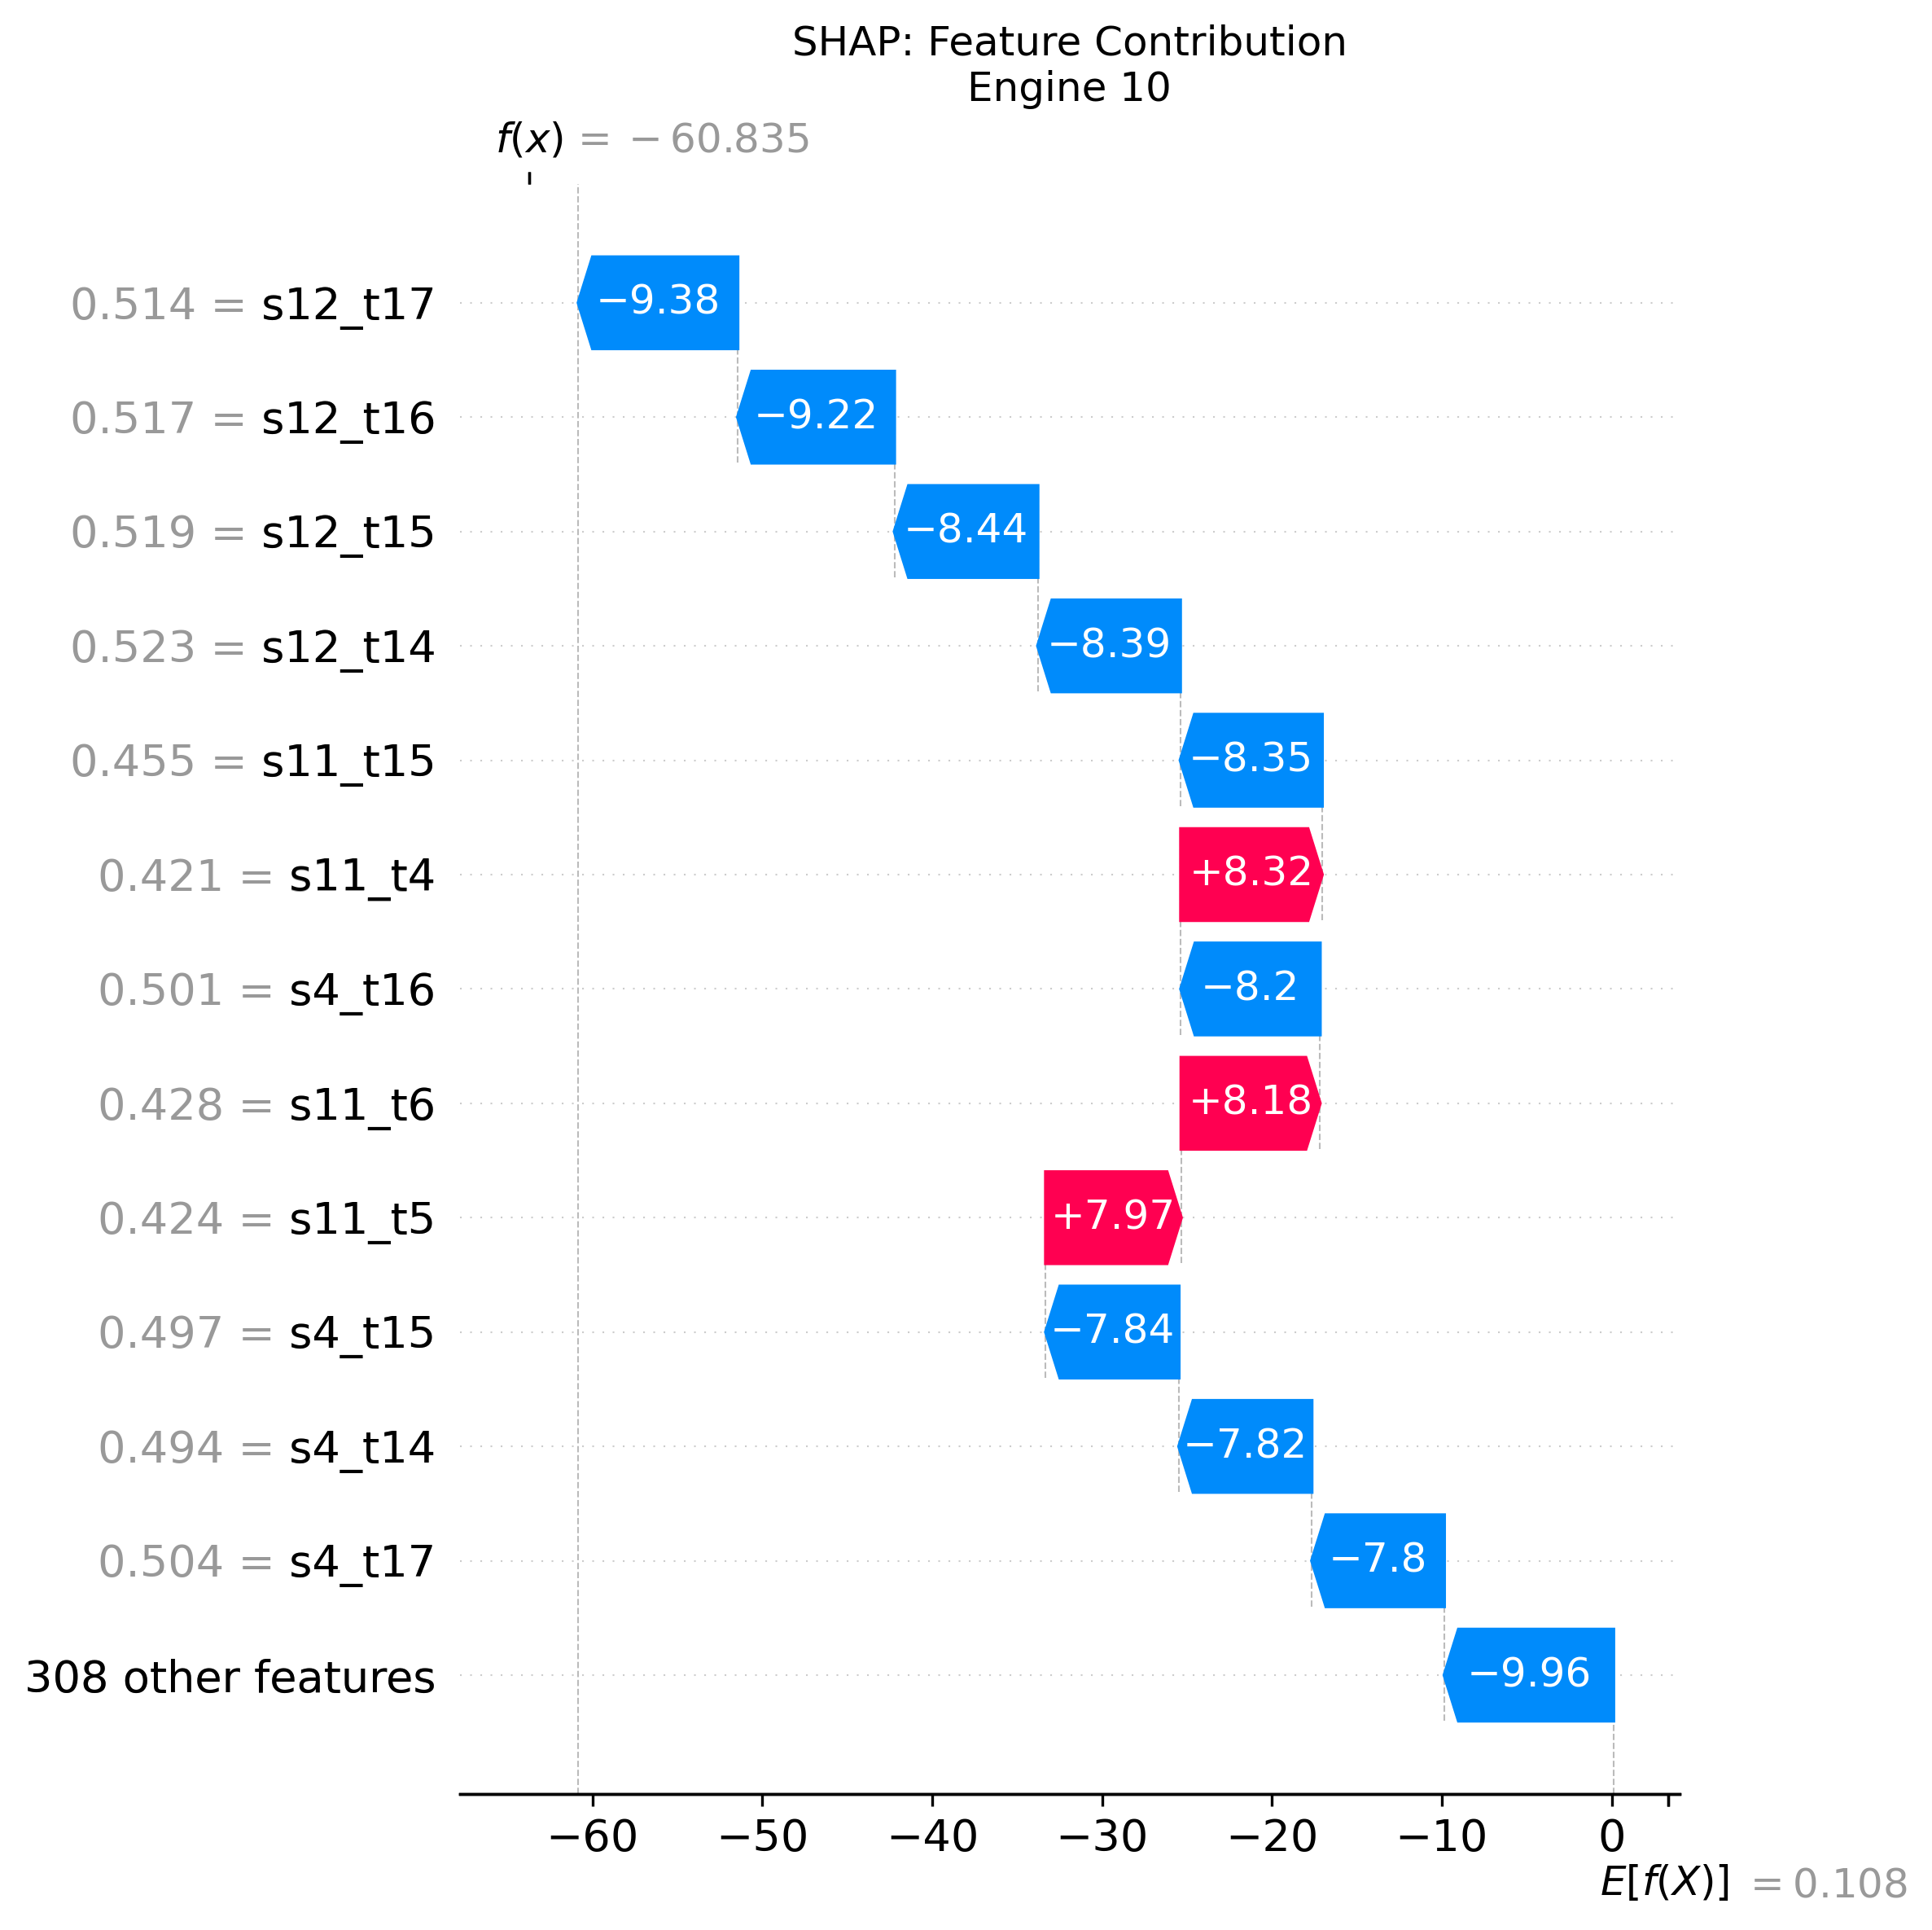

  Plotting for Engine 25 (Index 24)...
    Waterfall plot saved to plots\shap_feature_contribution_engine_25.png


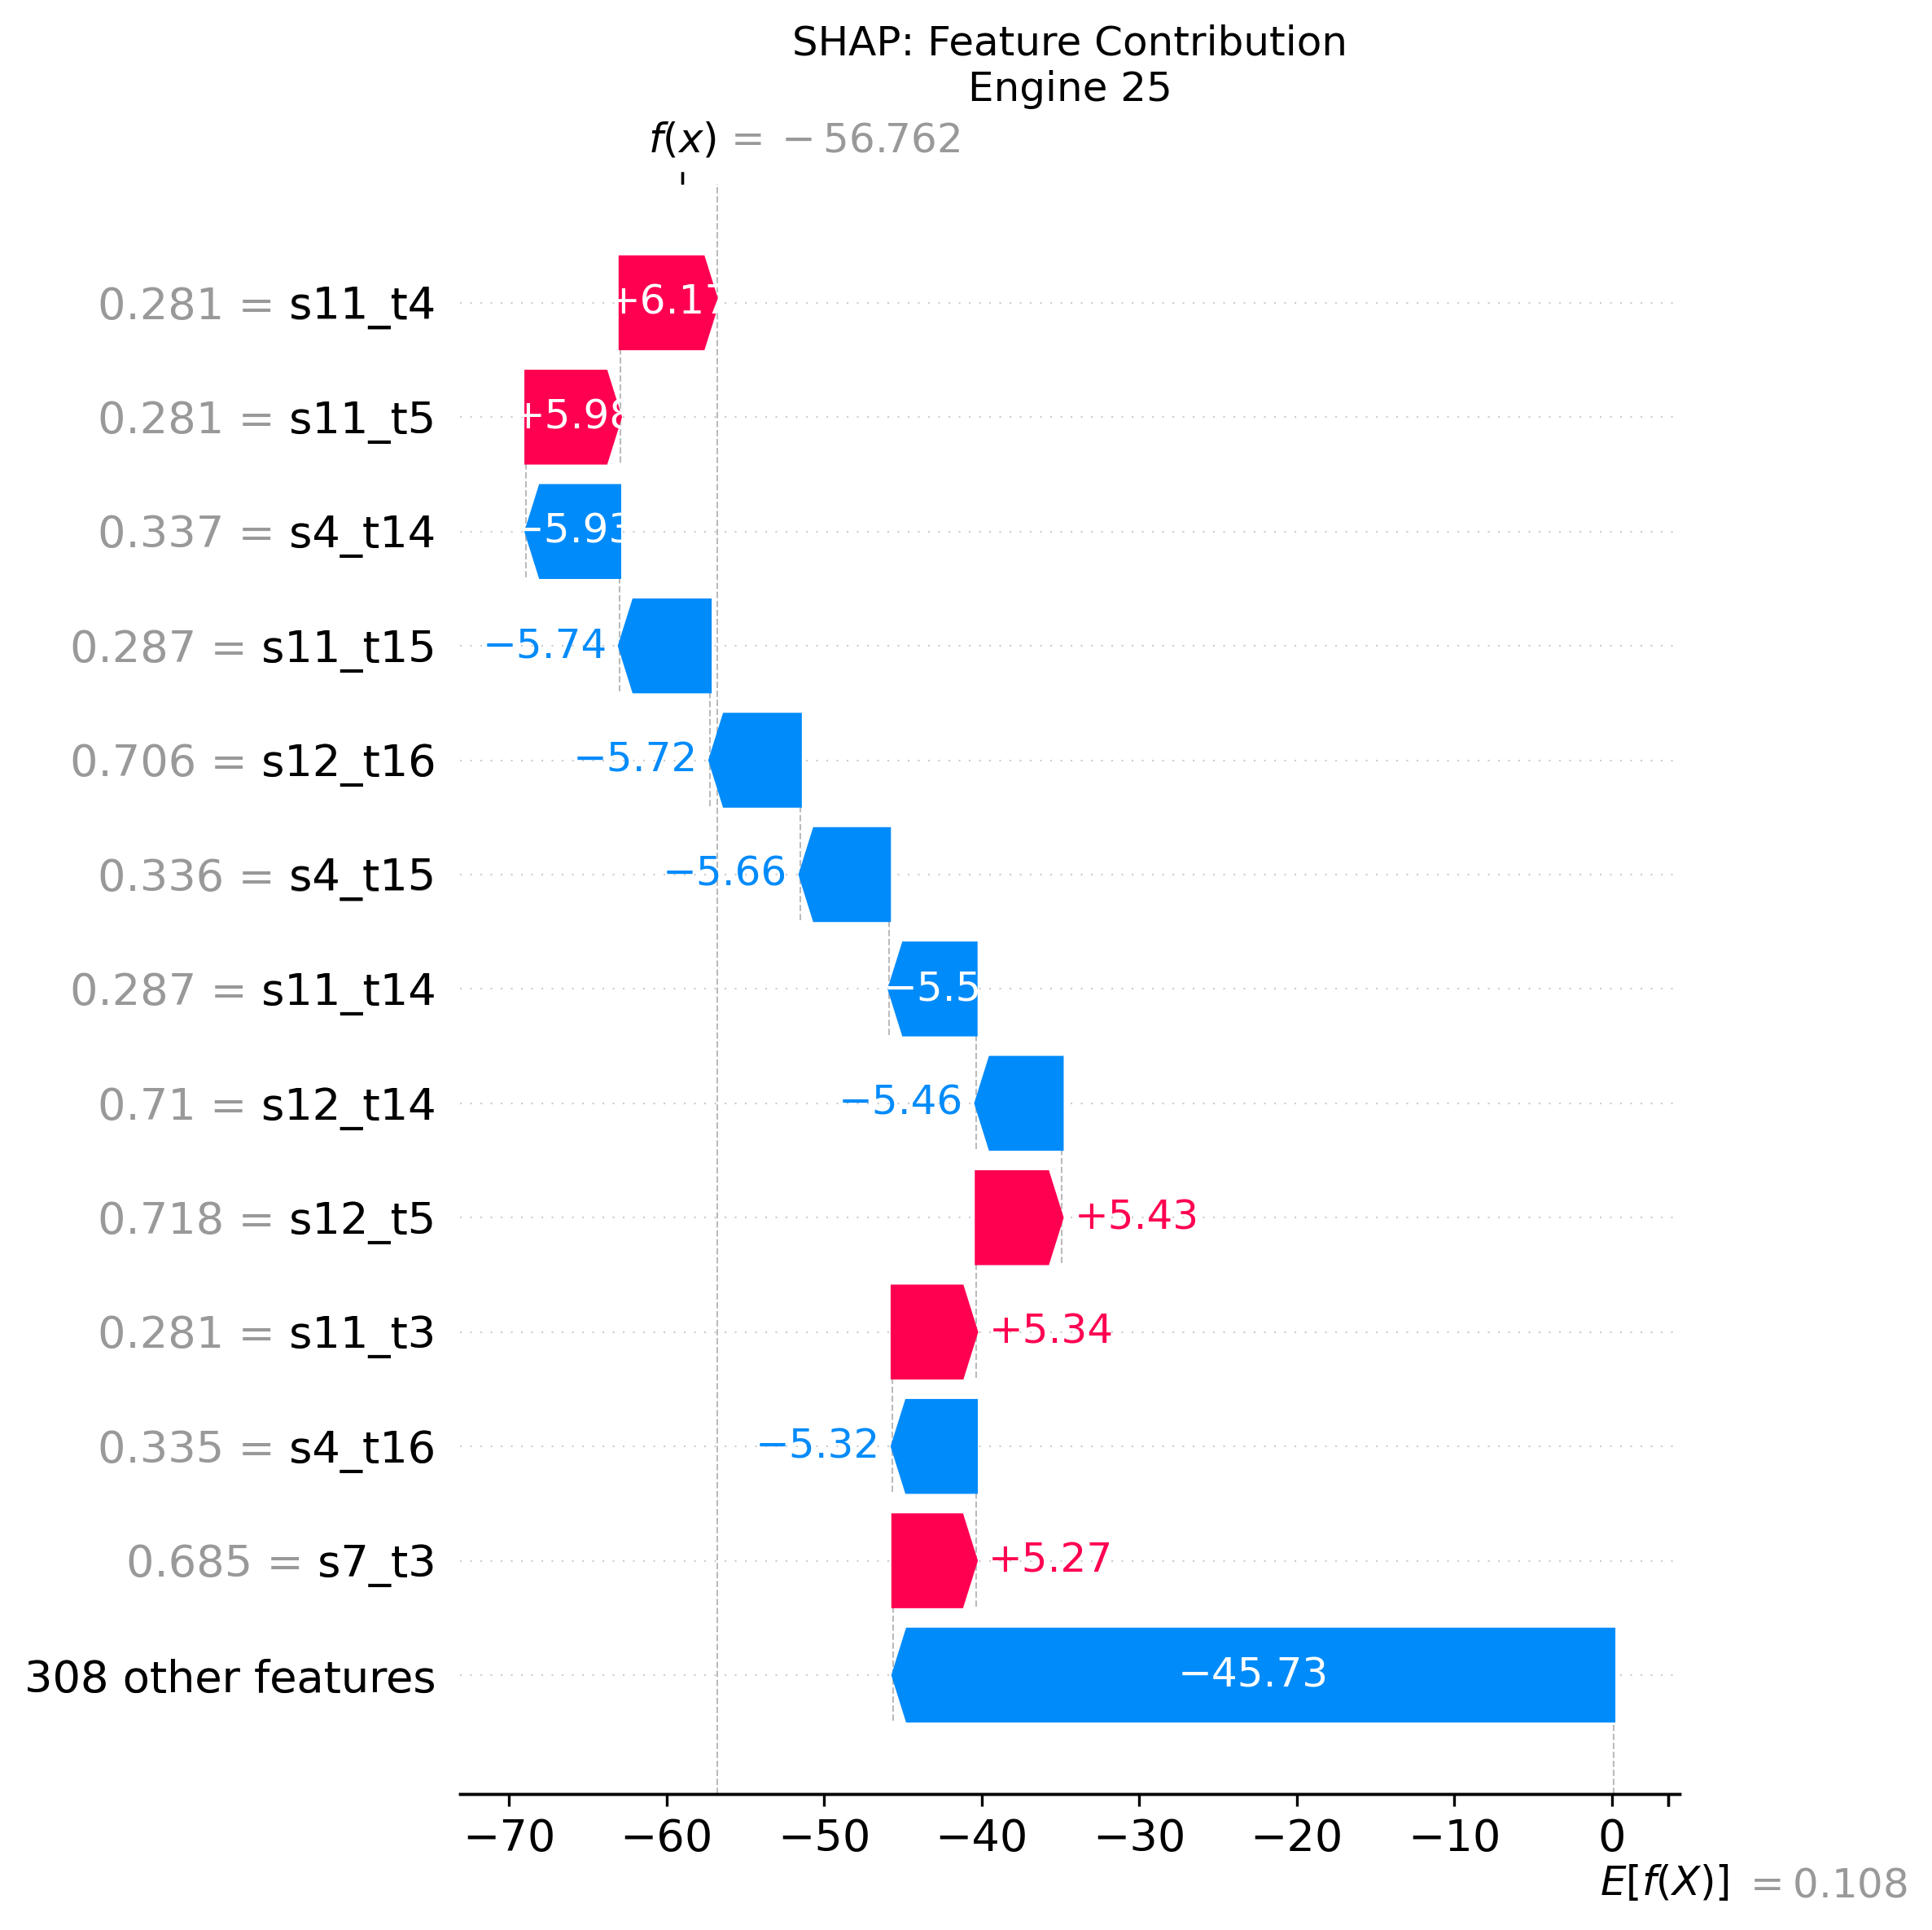

  Plotting for Engine 50 (Index 49)...
    Waterfall plot saved to plots\shap_feature_contribution_engine_50.png


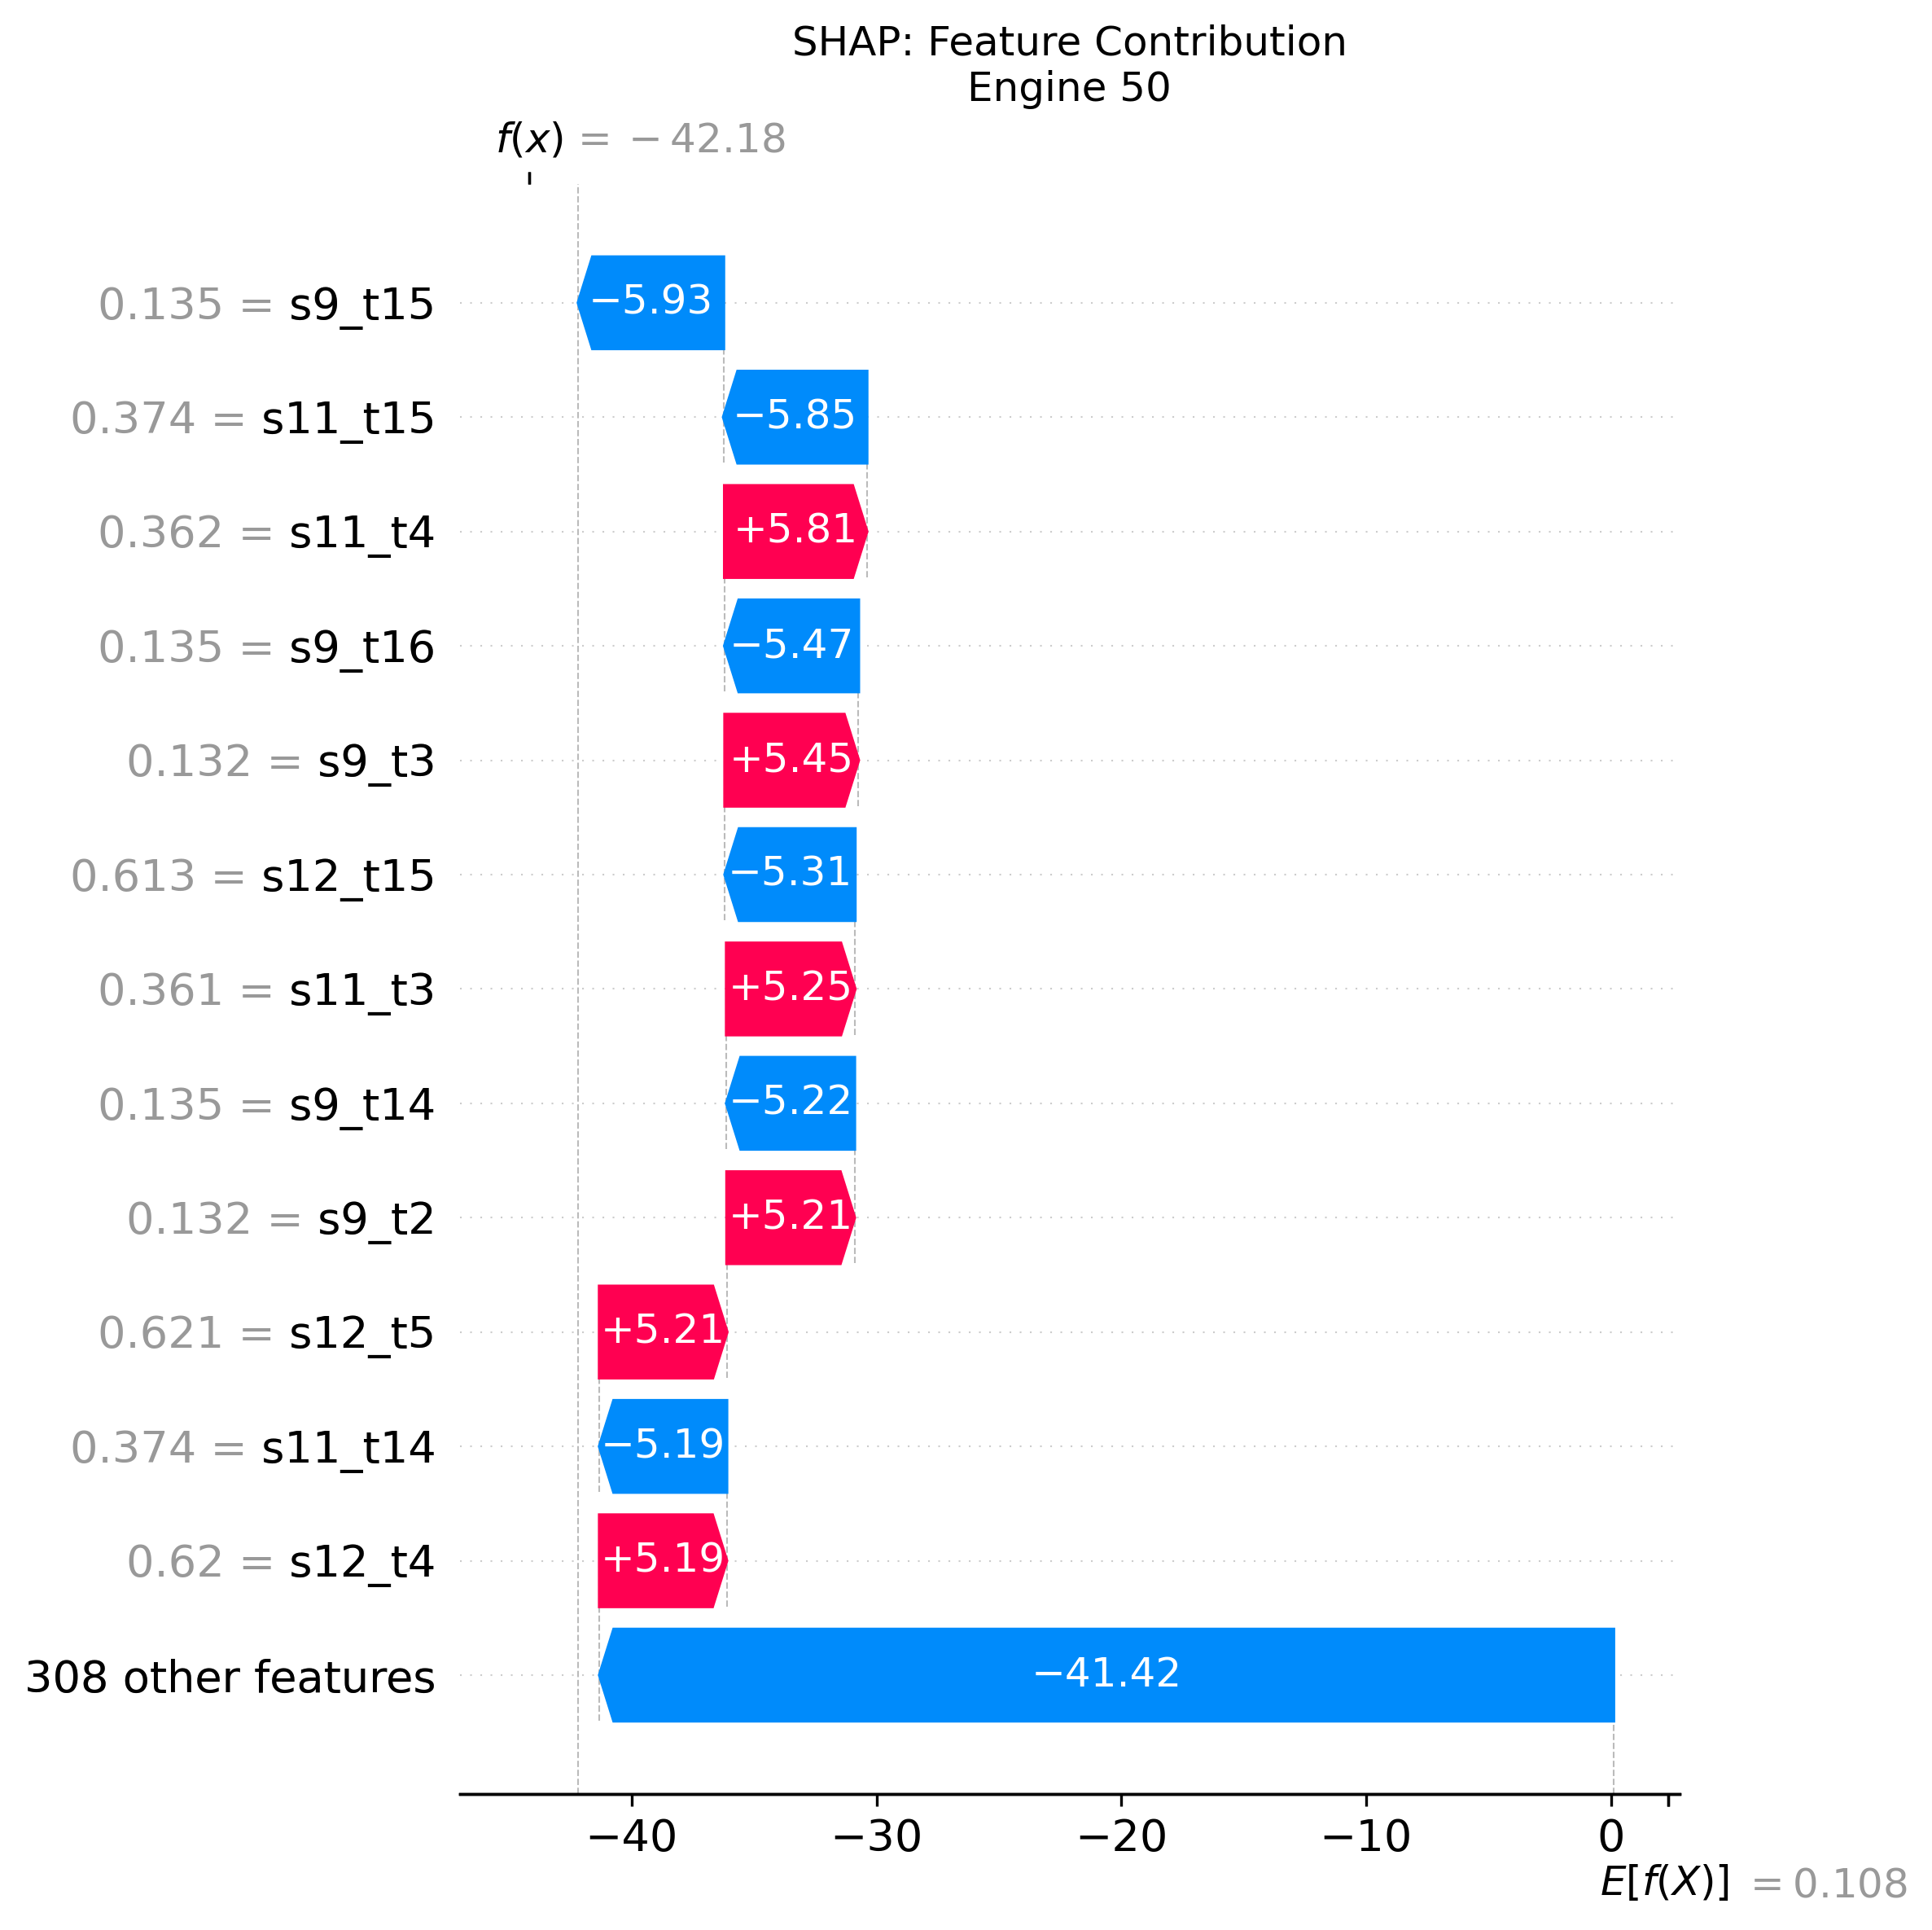


Generating Summary plot (Top 12 features, no color bar)...


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Summary plot saved to plots\shap_values_distribution.png


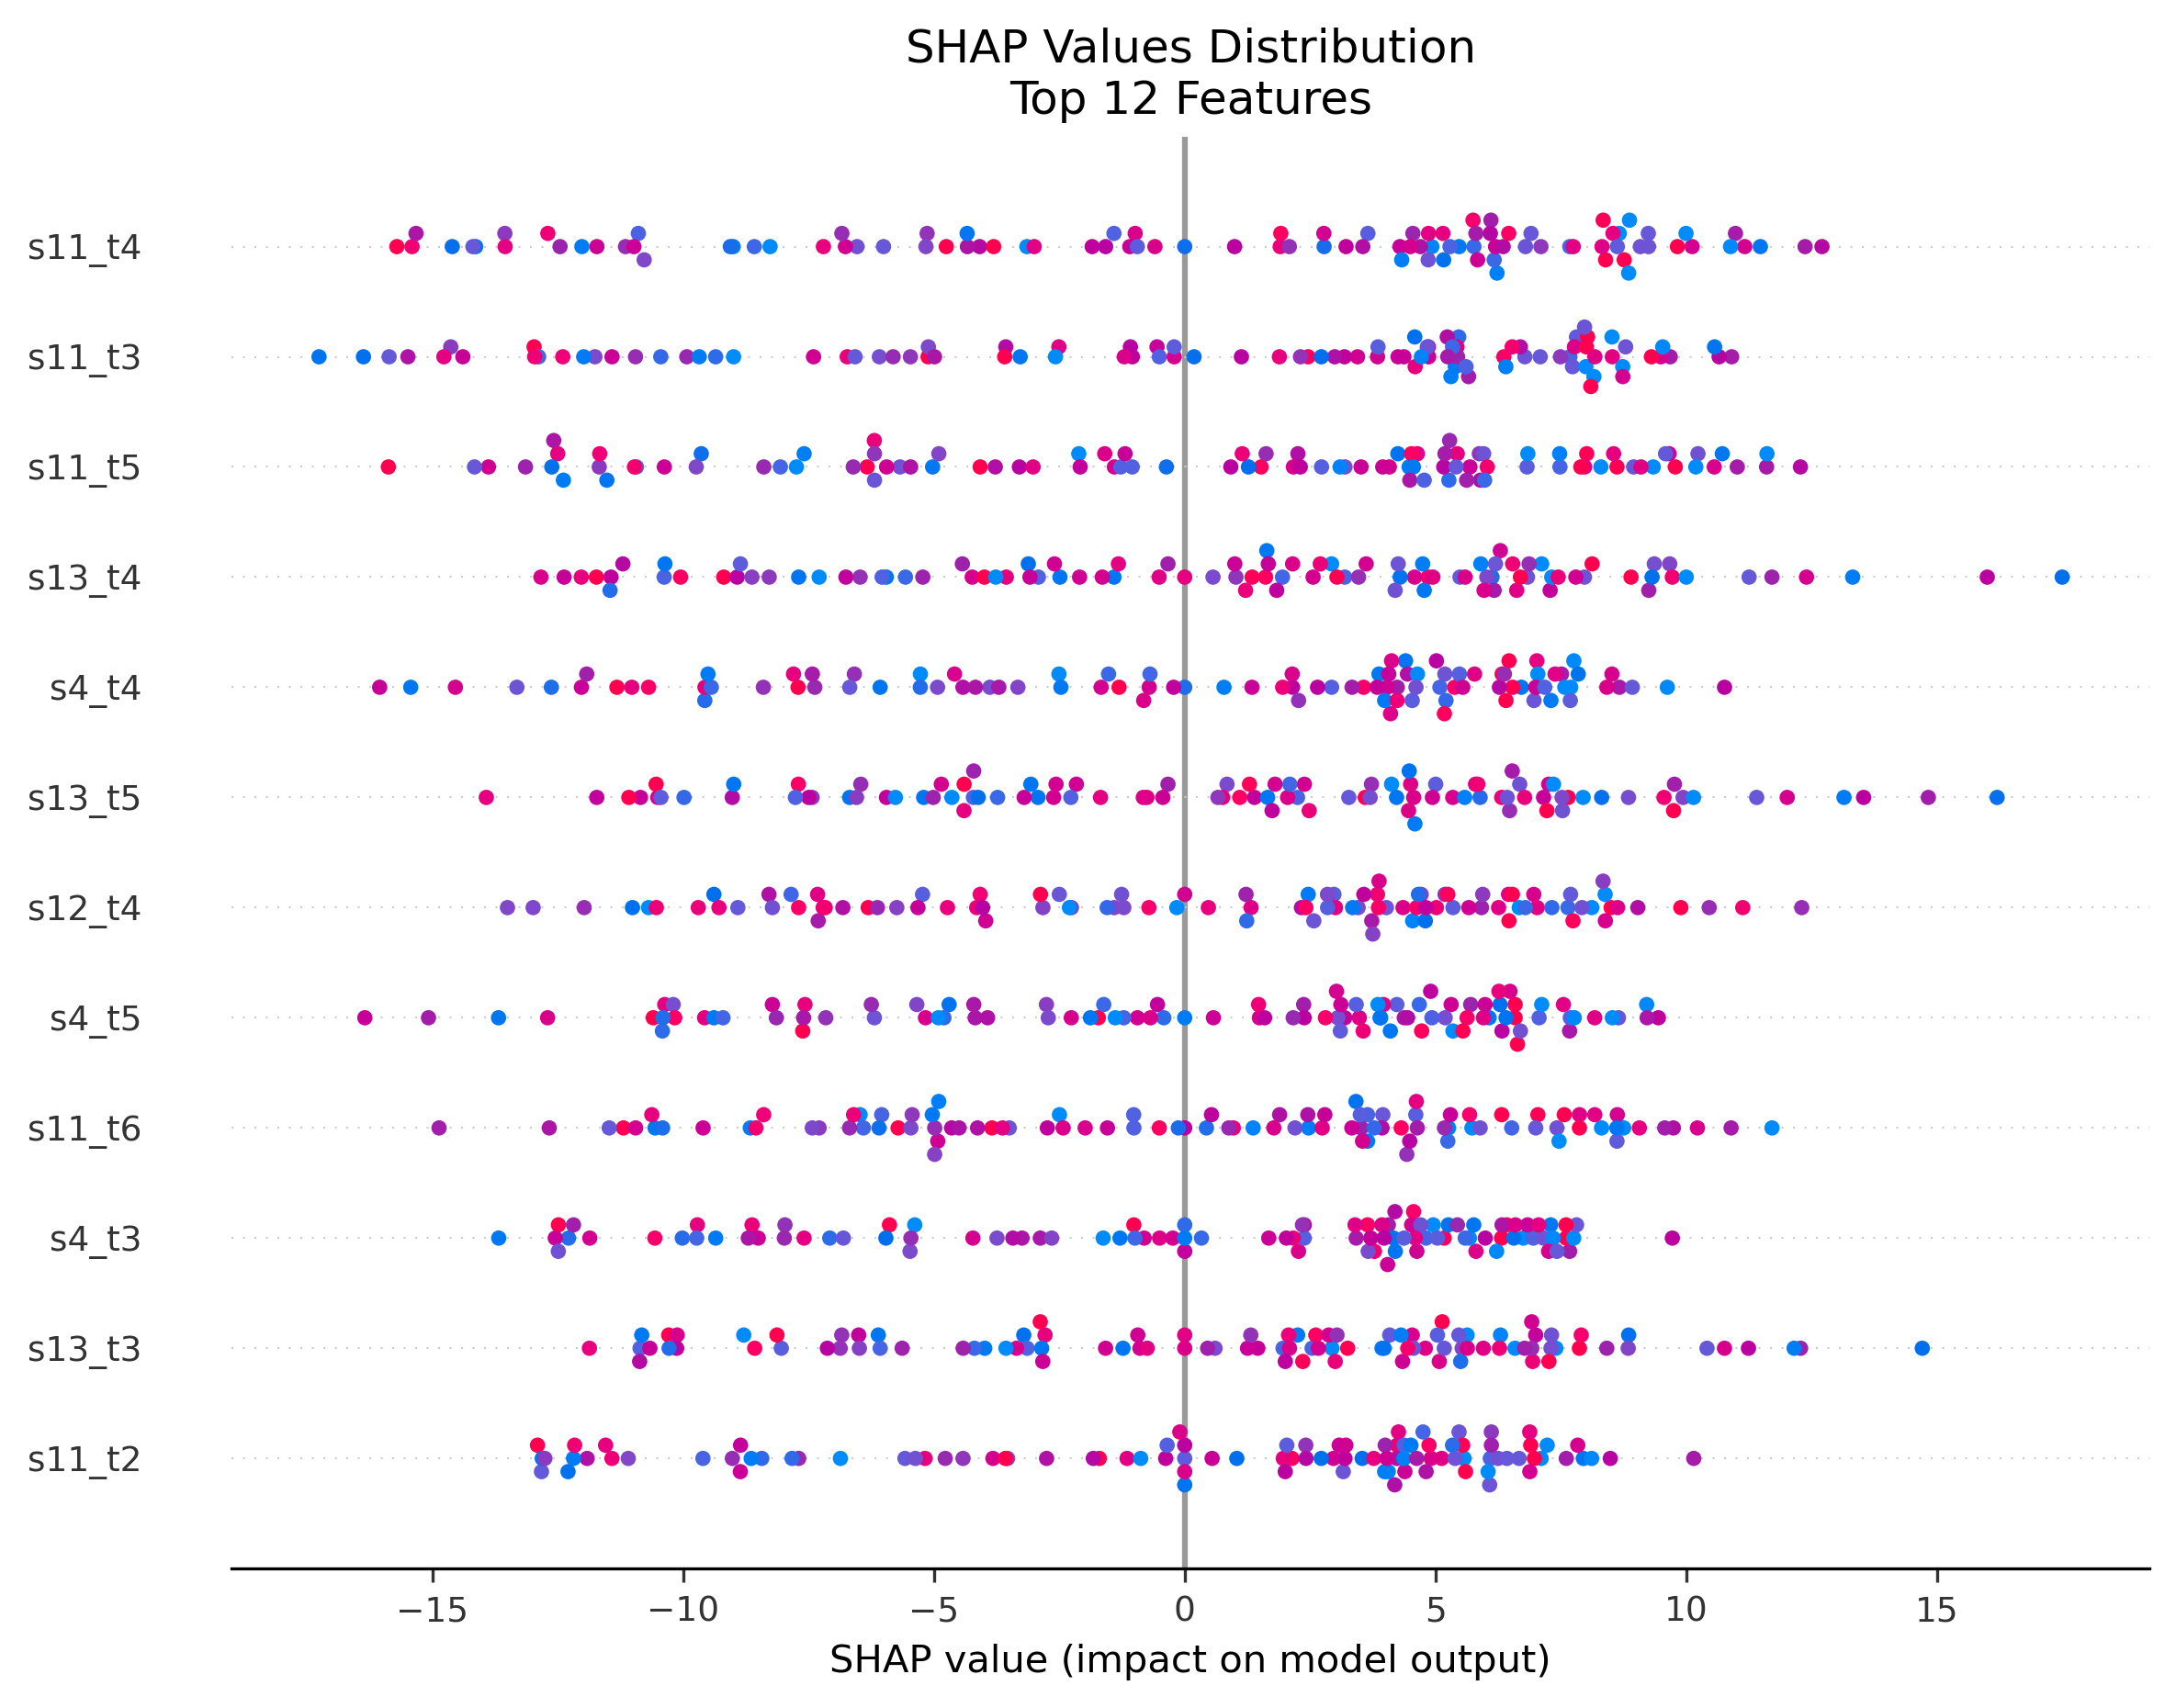


Generating Manual Color Bar figure...
Generic Color Bar saved to plots\shap_colorbar.png


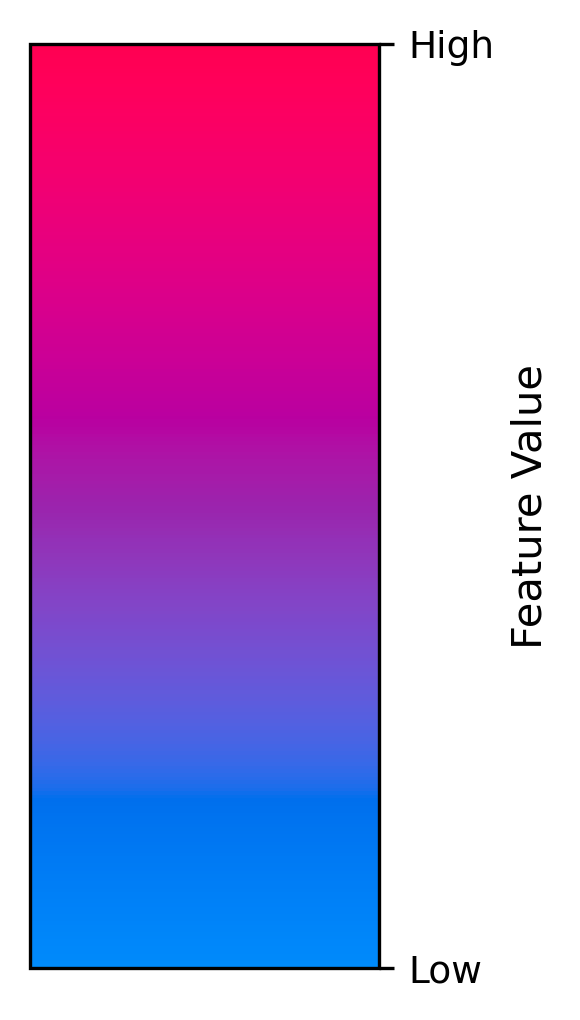


--- Finished Phase 4 ---


In [40]:
# Phase 4: Final SHAP Plots

import shap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import os

print("\n--- Phase 4: Generating Final SHAP Plots ---")

# --- Define Consistent Plot Settings ---
figure_dpi = 300
plot_figsize = (8, 6) # Consistent figure size
title_fontsize = 12
label_fontsize = 10
tick_fontsize = 9
plot_save_dir = "plots" # Save in current directory
os.makedirs(plot_save_dir, exist_ok=True)

# --- Check if necessary variables exist ---
variables_to_check = {
    'shap_values_kernel': ('(100, 320) numpy array', (100, window * n_features)),
    'explainer_kernel': ('shap.KernelExplainer object', None),
    'test_windows_flat': ('(100, 320) numpy array', (100, window * n_features)),
    'flat_feature_names': ('list of 320 strings', 320)
}
plots_possible = True
for var_name, (desc, expected_shape) in variables_to_check.items():
    if var_name not in locals():
        print(f"ERROR: Variable '{var_name}' ({desc}) not found. Cannot create plots.")
        plots_possible = False
    elif expected_shape is not None:
         # Check shape for numpy arrays, length for lists
         current_shape = getattr(locals()[var_name], 'shape', None)
         if current_shape is None and isinstance(locals()[var_name], list):
              current_shape = len(locals()[var_name])
              expected_shape = expected_shape # Use the integer length expected

         if current_shape != expected_shape:
             print(f"ERROR: Variable '{var_name}' has wrong shape/length. Expected {expected_shape}, got {current_shape}.")
             plots_possible = False

# Check for expected_value attribute needed for waterfall
if plots_possible and not hasattr(explainer_kernel, 'expected_value'):
     print("ERROR: explainer_kernel does not have expected_value attribute. Waterfall plots cannot be generated.")
     # It might be under explainer_kernel.expected_value[0] if it's multi-output, check structure if error occurs
     # Or potentially explainer_kernel.expected_value if it's scalar
     # If truly missing, might need recalculation (e.g., re-run .shap_values or predict on background)
     plots_possible = False
elif plots_possible:
     # Handle scalar or single-element list/array for base value
     base_value = explainer_kernel.expected_value
     if isinstance(base_value, (list, np.ndarray)) and len(base_value) == 1:
         base_value = base_value[0]
     print(f"Using base value for waterfall plots: {base_value:.4f}")


if plots_possible:
   # --- 1 & 2. Waterfall Plots for Specific Engines (Top 12 Features) ---
    engine_indices_to_plot = [0, 9, 24, 49] # Corresponds to Engine 1, 10, 25, 50
    engine_ids = [idx + 1 for idx in engine_indices_to_plot]
    max_display_waterfall = 13 # Shows top 12 + "others" bar

    print(f"\nGenerating Waterfall plots for Engines: {engine_ids}...")

    for i, engine_idx in enumerate(engine_indices_to_plot):
        engine_id_actual = engine_ids[i]
        print(f"  Plotting for Engine {engine_id_actual} (Index {engine_idx})...")
        fig_wf = None # Initialize fig variable for error handling
        try:
            # Create SHAP Explanation object for the specific instance
            exp = shap.Explanation(
                values=shap_values_kernel[engine_idx, :],
                base_values=base_value,
                data=test_windows_flat[engine_idx, :],
                feature_names=flat_feature_names
            )

            # Create plot
            fig_wf, ax_wf = plt.subplots(figsize=plot_figsize, dpi=figure_dpi)
            shap.plots.waterfall(exp, max_display=max_display_waterfall, show=False)

            # --- ADD X-AXIS LIMIT ADJUSTMENT ---
            xmin, xmax = ax_wf.get_xlim()
            padding = (xmax - xmin) * 0.05 # Add 5% padding to each side
            ax_wf.set_xlim(xmin - padding, xmax + padding)
            # --- END ADJUSTMENT ---

            # Apply Styling
            plt.title(f"SHAP: Feature Contribution\nEngine {engine_id_actual}", fontsize=title_fontsize)
            # Apply tight_layout *after* adjusting limits
            plt.tight_layout()

            # Save plot (PNG only)
            wf_filename = os.path.join(plots_save_dir, f"shap_feature_contribution_engine_{engine_id_actual}.png")
            plt.savefig(wf_filename, dpi=figure_dpi, bbox_inches='tight')
            print(f"    Waterfall plot saved to {wf_filename}")
            plt.show()
            plt.close(fig_wf)

        except Exception as e:
            print(f"    Error generating waterfall plot for Engine {engine_id_actual}: {e}")
            if fig_wf is not None: # Use the initialized variable
                 plt.close(fig_wf)

    # --- 3. Summary Plot (Top 12, No Color Bar) ---
    print("\nGenerating Summary plot (Top 12 features, no color bar)...")
    max_display_summary = 12
    try:
        fig_dot_final, ax_dot_final = plt.subplots(figsize=plot_figsize, dpi=figure_dpi)
        shap.summary_plot(
            shap_values_kernel,
            features=test_windows_flat,
            feature_names=flat_feature_names,
            max_display=max_display_summary,
            color_bar=False, # Explicitly False as requested
            show=False
        )

        # Apply Styling
        current_ax = plt.gca()
        current_ax.spines['top'].set_visible(False)
        current_ax.spines['right'].set_visible(False)
        current_ax.tick_params(axis='x', labelsize=tick_fontsize)
        current_ax.tick_params(axis='y', labelsize=tick_fontsize)
        plt.title(f"SHAP Values Distribution\nTop {max_display_summary} Features", fontsize=title_fontsize)
        current_ax.xaxis.label.set_size(label_fontsize)
        plt.tight_layout()

        # Save plot (PNG only)
        dot_filename = os.path.join(plots_save_dir, f"shap_values_distribution.png")
        plt.savefig(dot_filename, dpi=figure_dpi, bbox_inches='tight')
        print(f"Summary plot saved to {dot_filename}")
        plt.show()
        plt.close(fig_dot_final)

    except Exception as e:
        print(f"Error generating Summary plot: {e}")
        if 'fig_dot_final' in locals(): plt.close(fig_dot_final)


    # --- 4. Manual Generic Color Bar ---
    # Note: This shows the color mapping concept but isn't directly linked
    # to the actual coloring data of the dot plot above (which was disabled).
    print("\nGenerating Manual Color Bar figure...")
    try:
        fig_cbar, ax_cbar = plt.subplots(figsize=(1.5, 4), dpi=figure_dpi) # Small figure just for cbar

        # Try to use SHAP's default red/blue colormap if available
        try:
            import shap.plots.colors
            cmap = shap.plots.colors.red_blue
        except (ImportError, AttributeError):
            cmap = plt.get_cmap('coolwarm') # Fallback

        norm = colors.Normalize(vmin=0, vmax=1)
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        # Create the colorbar on the dedicated axes
        cbar = fig_cbar.colorbar(sm, cax=ax_cbar, ticks=[0, 1], aspect=30)
        cbar.set_ticklabels(["Low", "High"])
        cbar.set_label("Feature Value", size=label_fontsize)
        cbar.ax.tick_params(labelsize=tick_fontsize)

        # Save plot (PNG only)
        cbar_filename = os.path.join(plots_save_dir, "shap_colorbar.png")
        # Use fig_cbar.savefig()
        fig_cbar.savefig(cbar_filename, dpi=figure_dpi, bbox_inches='tight')
        print(f"Generic Color Bar saved to {cbar_filename}")
        plt.show()
        plt.close(fig_cbar)

    except Exception as e:
        print(f"Error generating manual color bar: {e}")
        if 'fig_cbar' in locals(): plt.close(fig_cbar)


else:
    print("\nSkipping Final SHAP Plots due to missing variables.")

print("\n--- Finished Phase 4 ---")


--- Phase 4: Generating Combined 2x2 Waterfall Plots ---
Using base value for waterfall plots: 0.1078

Generating combined Waterfall plots for Engines: [1, 10, 25, 50]...
  Plotting for Engine 1 (on subplot 1)...
  Plotting for Engine 10 (on subplot 2)...
  Plotting for Engine 25 (on subplot 3)...
  Plotting for Engine 50 (on subplot 4)...

Combined waterfall plot saved to plots\shap_feature_contribution_combined.png


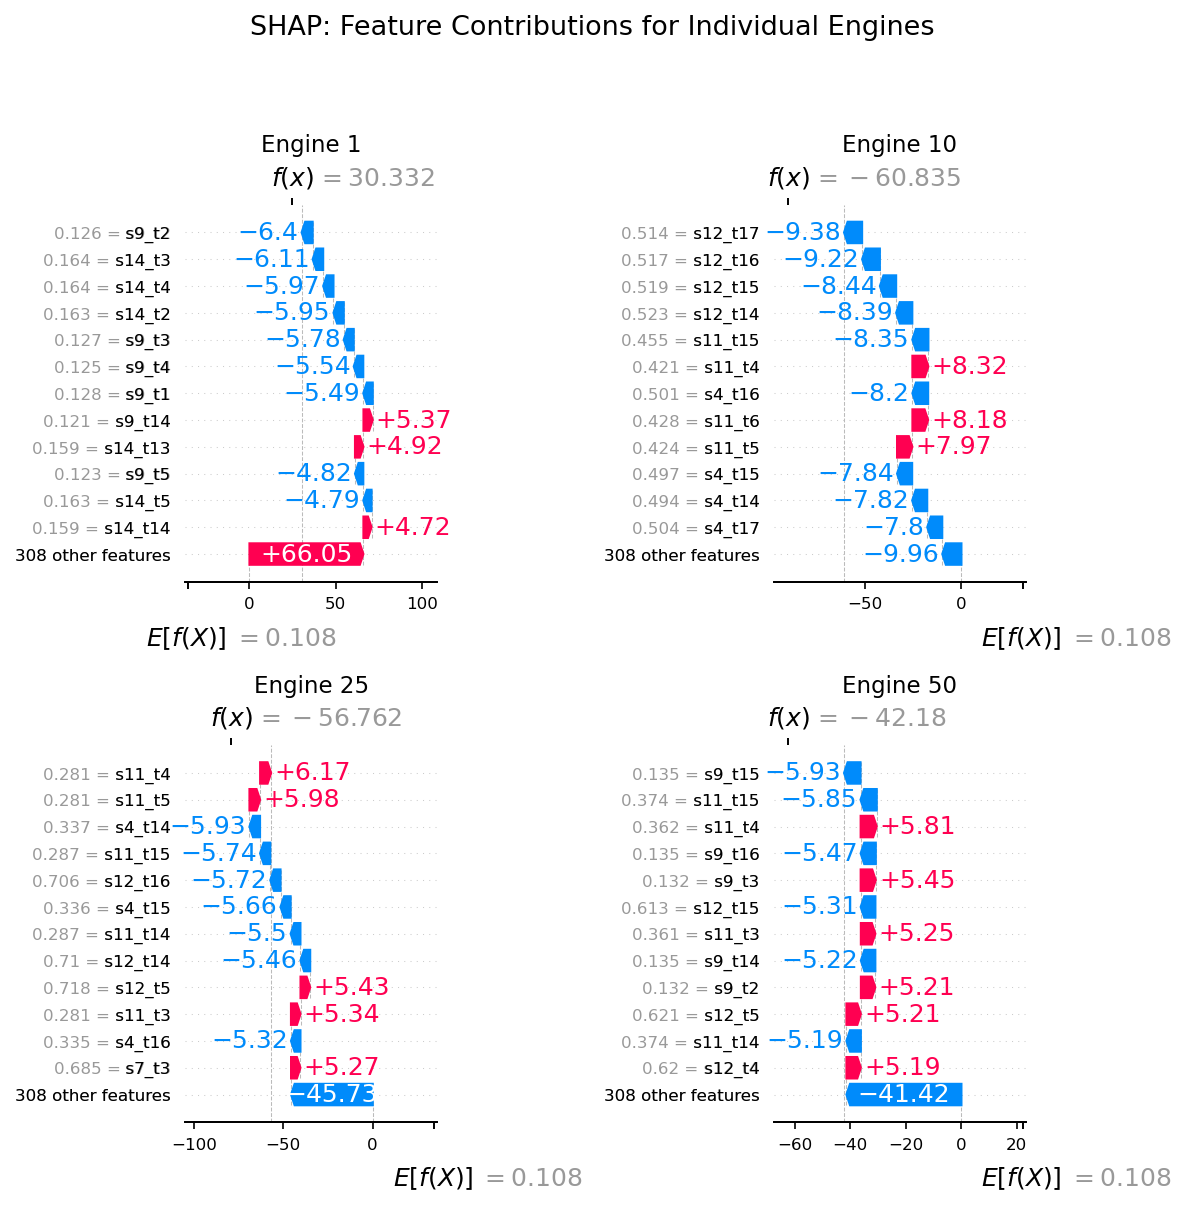


--- Finished Combined Waterfall Plots ---


In [41]:
# Phase 4 Plotting - Combined 2x2 Waterfall Plots (Wider Axis)

import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

print("\n--- Phase 4: Generating Combined 2x2 Waterfall Plots ---")

# --- Define Plot Settings ---
figure_dpi = 150
combined_wf_figsize = (15, 10) # Adjusted width slightly for more x-space
title_fontsize = 11
label_fontsize = 9 # For axis labels (e.g., "SHAP value")
tick_fontsize = 8  # For axis tick numbers and implicitly influences annotation appearance
max_display_waterfall = 13 # Top 12 + others
plots_save_dir = "plots"
# os.makedirs(save_dir, exist_ok=True)

# Check if necessary variables exist
plots_possible = True # Assume this flag is set based on previous checks
if 'shap_values_kernel' not in locals() or 'explainer_kernel' not in locals() or not hasattr(explainer_kernel, 'expected_value'):
     print("ERROR: Necessary SHAP data or explainer missing. Skipping plot.")
     plots_possible = False
elif plots_possible:
     # Extract base value safely
     base_value = explainer_kernel.expected_value
     if isinstance(base_value, (list, np.ndarray)) and len(base_value) == 1:
         base_value = base_value[0]
     print(f"Using base value for waterfall plots: {base_value:.4f}")


if plots_possible:
    # --- Create a single figure with 2x2 subplots ---
    fig_wf_combined, axes = plt.subplots(nrows=2, ncols=2, figsize=combined_wf_figsize, dpi=figure_dpi)
    axes_flat = axes.flatten() # Easier indexing

    engine_indices_to_plot = [0, 9, 24, 49] # Engines 1, 10, 25, 50
    engine_ids = [idx + 1 for idx in engine_indices_to_plot]

    print(f"\nGenerating combined Waterfall plots for Engines: {engine_ids}...")
    plot_successful = True
    try:
        # Loop through the engines and corresponding axes
        for i, engine_idx in enumerate(engine_indices_to_plot):
            if i >= len(axes_flat): break

            ax = axes_flat[i] # Get the current subplot axes
            engine_id_actual = engine_ids[i]
            print(f"  Plotting for Engine {engine_id_actual} (on subplot {i+1})...")

            # Create SHAP Explanation object
            exp = shap.Explanation(
                values=shap_values_kernel[engine_idx, :],
                base_values=base_value,
                data=test_windows_flat[engine_idx, :],
                feature_names=flat_feature_names
            )

            # --- Set current axes and plot ---
            plt.sca(ax)
            shap.plots.waterfall(exp, max_display=max_display_waterfall, show=False)

            # --- Apply Styling ---
            ax.set_title(f"Engine {engine_id_actual}", fontsize=title_fontsize)

            # --- ADJUST X-AXIS LIMITS MORE ---
            xmin, xmax = ax.get_xlim()
            padding = (xmax - xmin) * 0.5 # Use 15% padding (increased from 5%)
            ax.set_xlim(xmin - padding, xmax + padding)
            # --- END ADJUSTMENT ---

            # Adjust tick label sizes
            ax.tick_params(axis='both', labelsize=tick_fontsize)
            # Adjust x-axis label size (Waterfall sets this label)
            try:
                ax.xaxis.label.set_size(label_fontsize)
            except AttributeError: pass

    except Exception as e:
        print(f"    Error generating combined waterfall plot during loop: {e}")
        plot_successful = False

    if plot_successful:
        # --- Final Figure Adjustments & Saving ---
        fig_wf_combined.suptitle("SHAP: Feature Contributions for Individual Engines", fontsize=title_fontsize + 2, y=1.0)
        plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout

        # Save the combined figure (PNG only)
        wf_combined_filename = os.path.join(plots_save_dir, "shap_feature_contribution_combined.png")
        try:
            fig_wf_combined.savefig(wf_combined_filename, dpi=figure_dpi, bbox_inches='tight')
            print(f"\nCombined waterfall plot saved to {wf_combined_filename}")
        except Exception as save_err:
            print(f"Error saving combined waterfall plot: {save_err}")

        plt.show() # Display the combined figure

    # Close the main figure object regardless
    plt.close(fig_wf_combined)

print("\n--- Finished Combined Waterfall Plots ---")

### Plotting TimeSHAP Results


--- Phase 3: Generating Local TimeSHAP Plots per Engine (Event Bar + Heatmap) ---

--- Generating plots for Engine 1 (Index 0) ---
  Generating Event Importance plot for Engine 1...
    Event plot saved to plots\timeshap_time_step_importance_engine_1.png


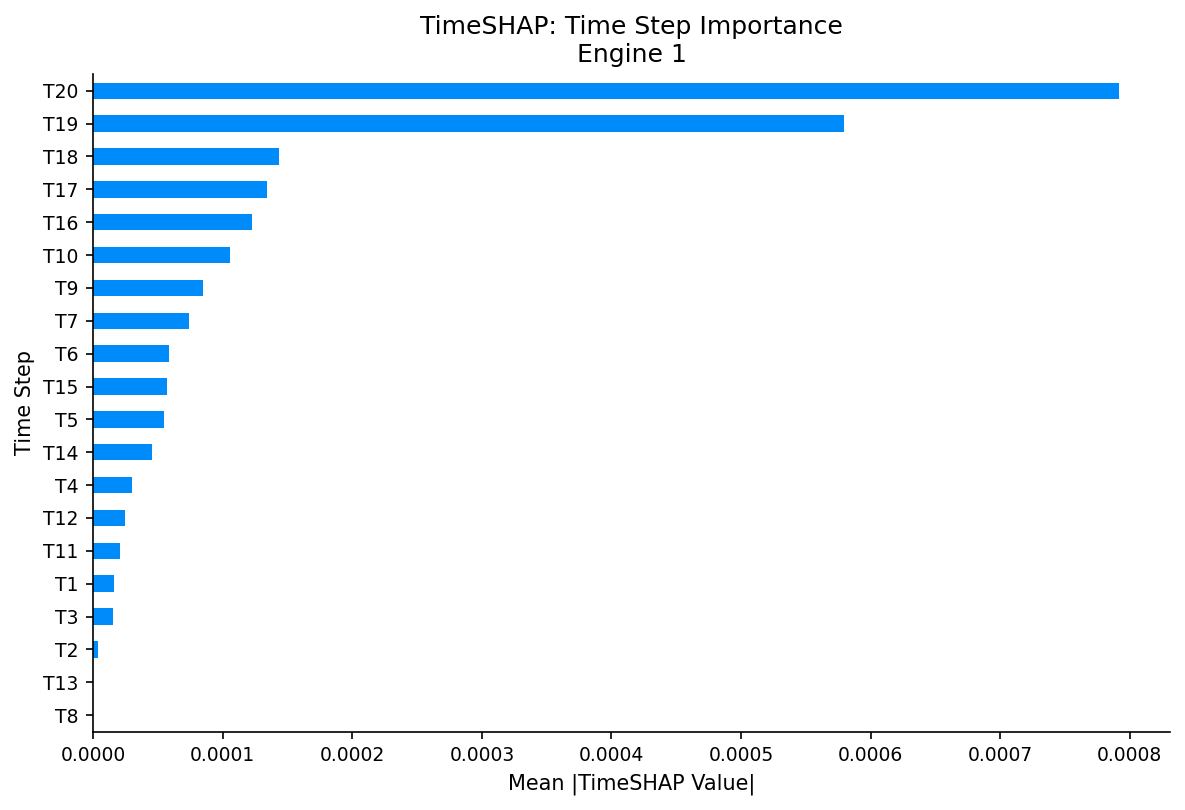

  Generating Cell Importance Heatmap for Engine 1...
    Heatmap saved to plots\timeshap_feature_contribution_heatmap_engine_1.png


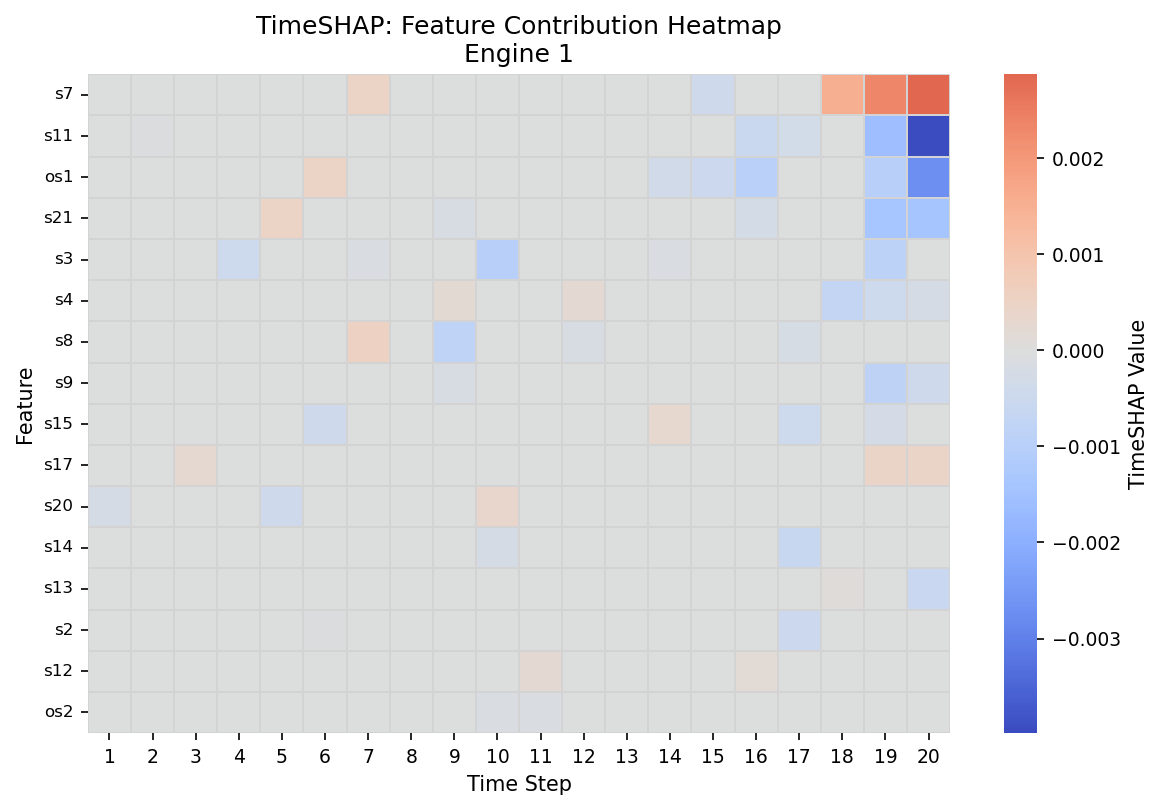


--- Generating plots for Engine 10 (Index 9) ---
  Generating Event Importance plot for Engine 10...
    Event plot saved to plots\timeshap_time_step_importance_engine_10.png


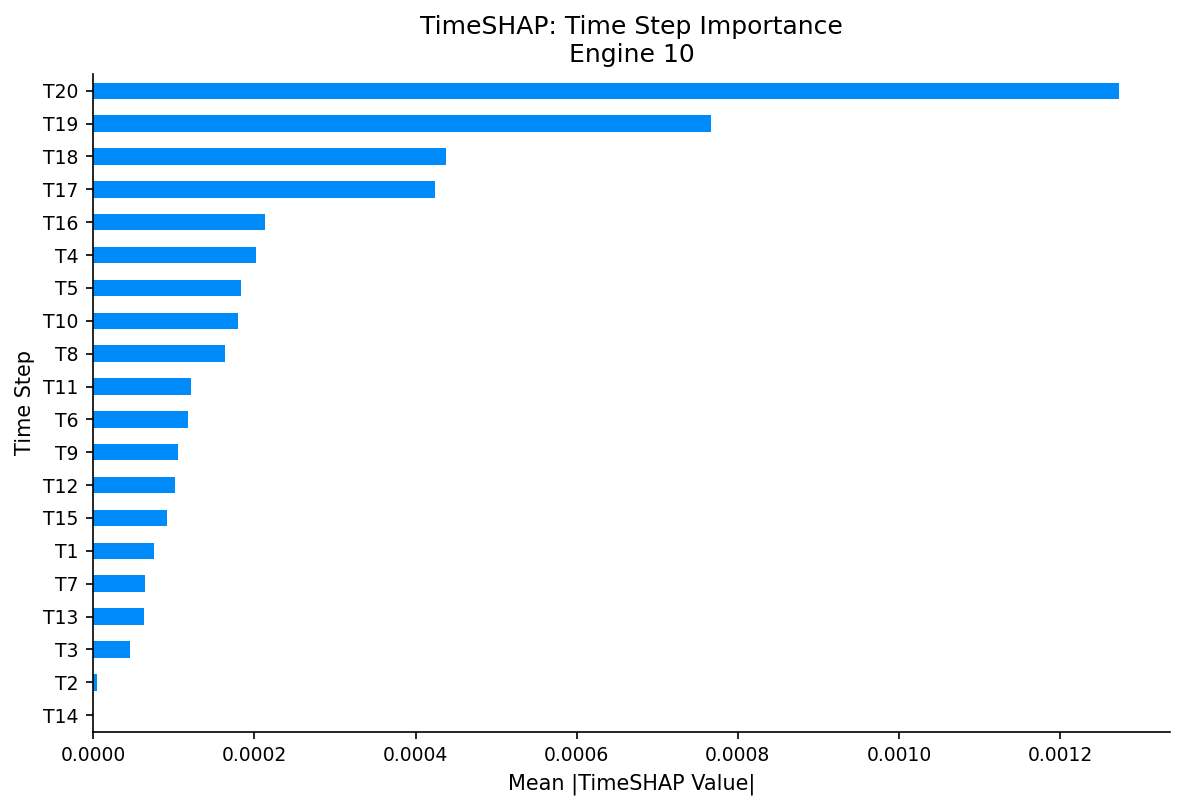

  Generating Cell Importance Heatmap for Engine 10...
    Heatmap saved to plots\timeshap_feature_contribution_heatmap_engine_10.png


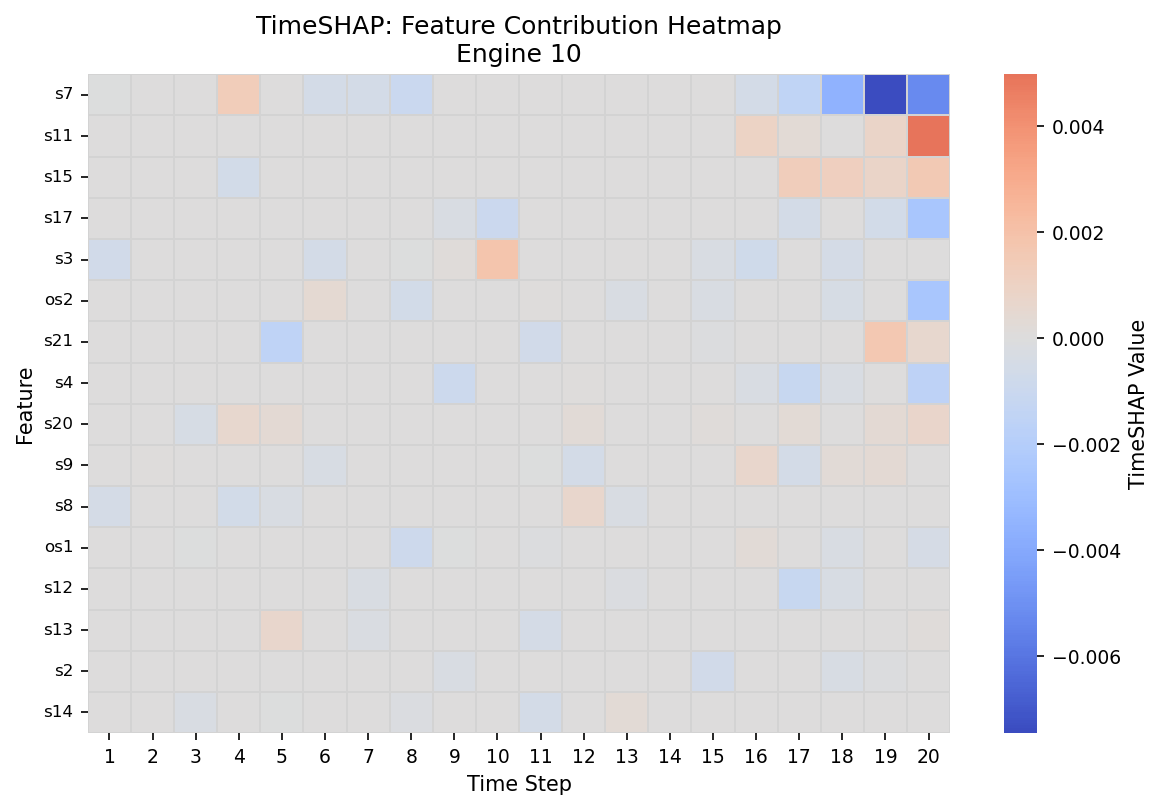


--- Generating plots for Engine 25 (Index 24) ---
  Generating Event Importance plot for Engine 25...
    Event plot saved to plots\timeshap_time_step_importance_engine_25.png


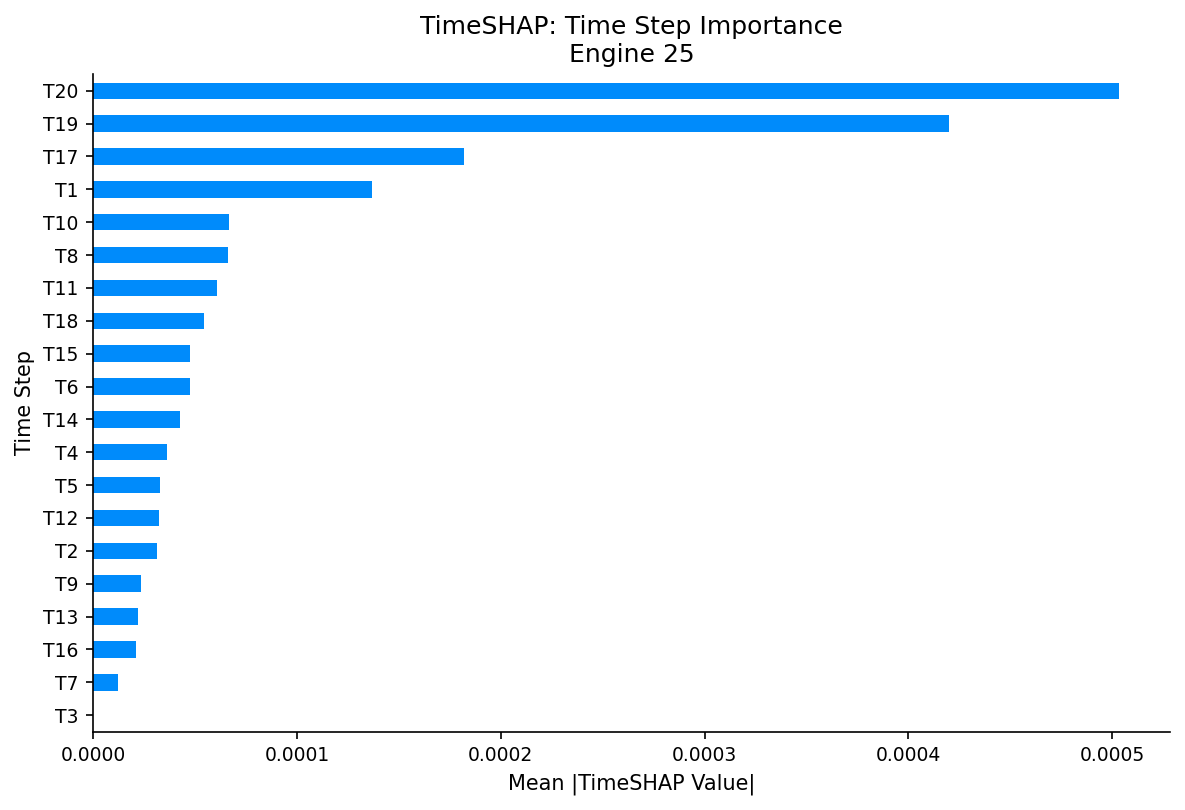

  Generating Cell Importance Heatmap for Engine 25...
    Heatmap saved to plots\timeshap_feature_contribution_heatmap_engine_25.png


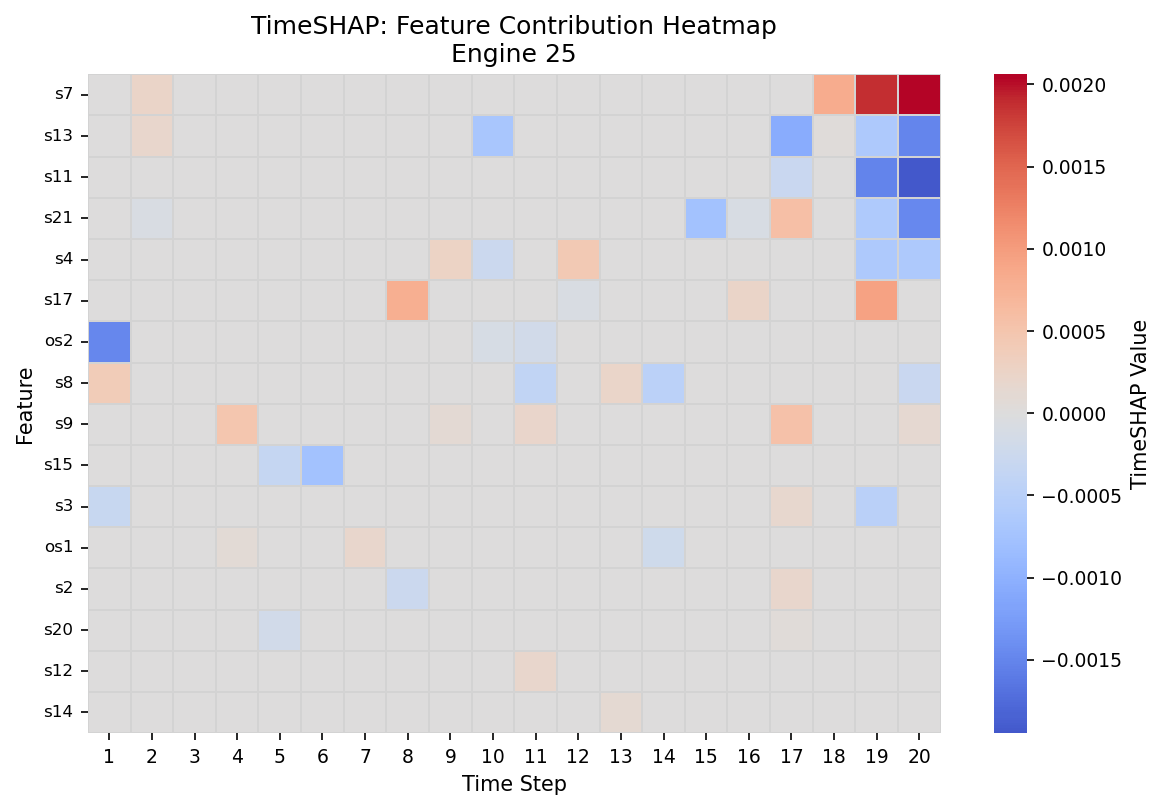


--- Generating plots for Engine 50 (Index 49) ---
  Generating Event Importance plot for Engine 50...
    Event plot saved to plots\timeshap_time_step_importance_engine_50.png


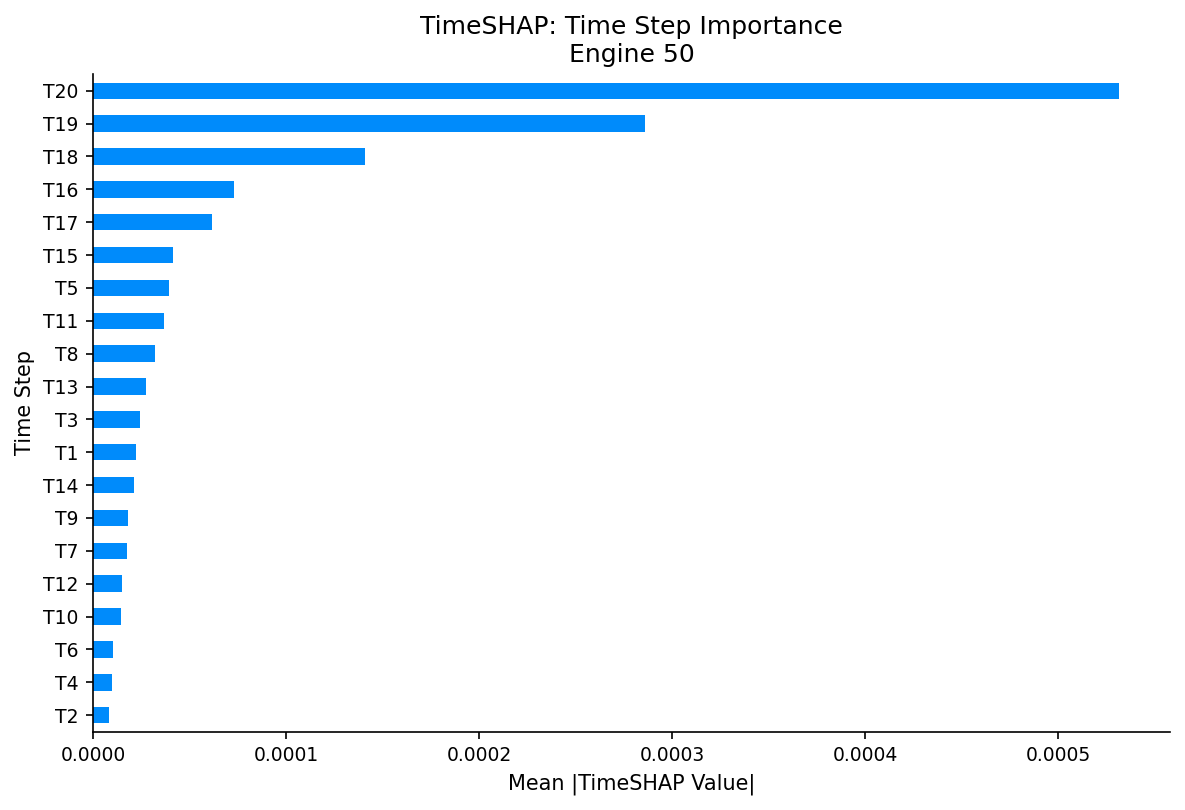

  Generating Cell Importance Heatmap for Engine 50...
    Heatmap saved to plots\timeshap_feature_contribution_heatmap_engine_50.png


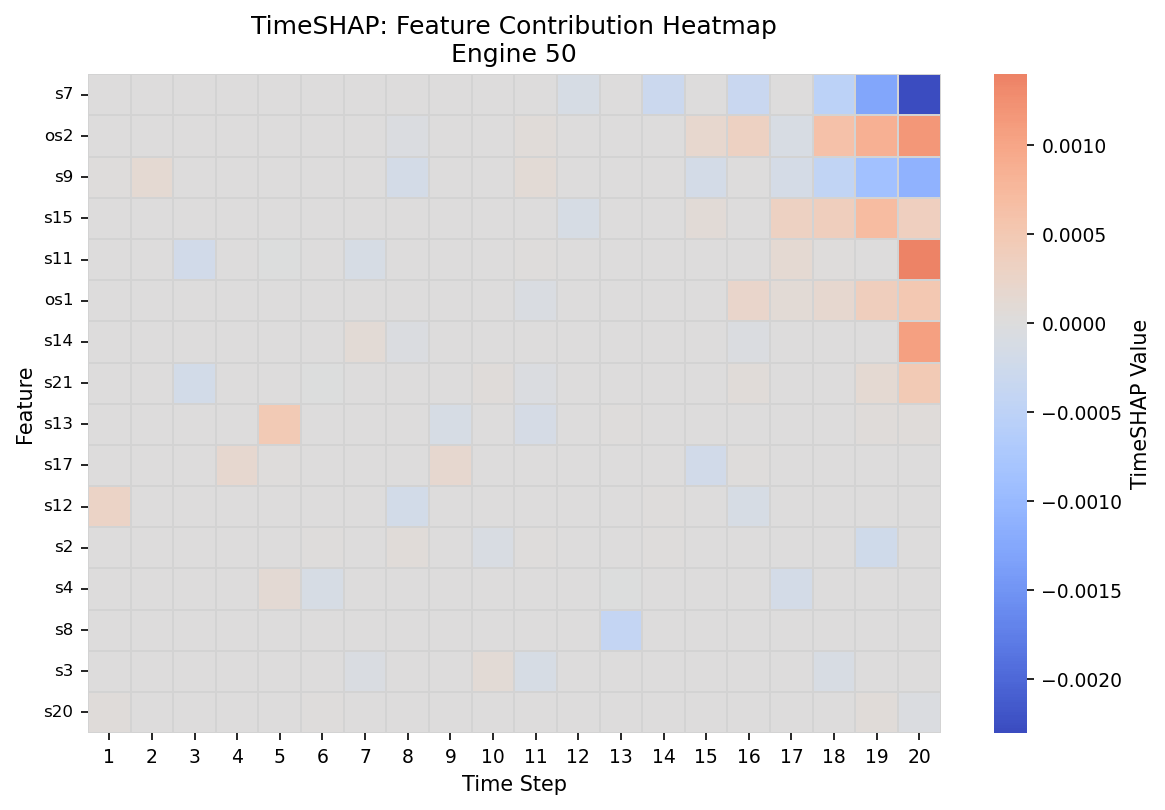


--- Finished Phase 3 Local Plots ---


In [42]:
# Phase 3 Plotting - Local Event Bar Plot & Local Heatmap per Engine

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns # Make sure seaborn is imported

print("\n--- Phase 3: Generating Local TimeSHAP Plots per Engine (Event Bar + Heatmap) ---")

# --- Define Plot Settings ---
figure_dpi = 150
# Adjust figsize if needed for heatmap vs bar plot
local_plot_figsize = (8, 5.5) # You might want different sizes for bar vs heatmap
title_fontsize = 12
label_fontsize = 10
tick_fontsize = 9
plots_save_dir = "plots"
# os.makedirs(save_dir, exist_ok=True)

# Engines to plot
engine_indices_to_plot = [0, 9, 24, 49] # Engines 1, 10, 25, 50
engine_ids = [idx + 1 for idx in engine_indices_to_plot]

# Check if TimeSHAP results are available
if 'ts_shap_vals' in locals() and ts_shap_vals is not None and computation_successful:

    # Loop through selected engine indices
    for i, engine_idx in enumerate(engine_indices_to_plot):
        engine_id_actual = engine_ids[i]
        print(f"\n--- Generating plots for Engine {engine_id_actual} (Index {engine_idx}) ---")

        # Get SHAP values for the current engine: shape (window, n_features) -> (20, 16)
        local_shap = ts_shap_vals[engine_idx]

        # --- Plot 1: Local Event Importance (Magnitude Bar Plot) ---
        # (This block remains the same as before)
        fig_event, ax_event = None, None
        try:
            print(f"  Generating Event Importance plot for Engine {engine_id_actual}...")
            event_importance = np.mean(np.abs(local_shap), axis=1) # Shape (window,)
            time_labels = [f"T{t+1}" for t in range(window)]
            event_series = pd.Series(event_importance, index=time_labels)
            event_series_sorted = event_series.sort_values(ascending=True) # Plot bottom-up

            fig_event, ax_event = plt.subplots(figsize=local_plot_figsize, dpi=figure_dpi)
            event_series_sorted.plot.barh(ax=ax_event, color='#008bfb')

            ax_event.set_title(f"TimeSHAP: Time Step Importance\nEngine {engine_id_actual}", fontsize=title_fontsize)
            ax_event.set_xlabel("Mean |TimeSHAP Value|", fontsize=label_fontsize)
            ax_event.set_ylabel("Time Step", fontsize=label_fontsize)
            ax_event.tick_params(axis='both', labelsize=tick_fontsize)
            ax_event.spines[['top', 'right']].set_visible(False)
            plt.tight_layout()

            filename = os.path.join(save_dir, f"timeshap_time_step_importance_engine_{engine_id_actual}.png")
            plt.savefig(filename, dpi=figure_dpi, bbox_inches='tight')
            print(f"    Event plot saved to {filename}")
            plt.show()
        except Exception as e:
            print(f"    Error generating Event Importance plot: {e}")
        finally:
            if fig_event is not None: plt.close(fig_event)


        # --- Plot 2: Local Cell Importance (Heatmap - Signed Value, Features Ranked) ---
        # (Replaces the previous local feature bar plot)
        fig_heatmap, ax_heatmap = None, None
        try:
            print(f"  Generating Cell Importance Heatmap for Engine {engine_id_actual}...")

            # 1. Rank features by magnitude FOR THIS ENGINE (avg abs value over time)
            local_feat_magnitude = np.mean(np.abs(local_shap), axis=0) # Shape (n_features,)
            # Get indices sorted by magnitude descending
            local_indices_sorted_desc = np.argsort(local_feat_magnitude)[::-1]
            # Get feature names in descending importance order
            local_names_sorted = np.array(base_feature_names)[local_indices_sorted_desc]

            # 2. Select and reorder the local SHAP data columns according to feature rank
            local_heatmap_data = local_shap[:, local_indices_sorted_desc] # Shape (20, 16)

            # 3. Create the heatmap, plotting transpose for Features on Y axis
            fig_heatmap, ax_heatmap = plt.subplots(figsize=local_plot_figsize, dpi=figure_dpi)
            # Use coolwarm colormap as requested
            cmap_choice = "coolwarm"

            sns.heatmap(
                local_heatmap_data.T, # Transpose -> (16, 20) features x time
                xticklabels=np.arange(1, window + 1), # Time steps 1-20
                yticklabels=local_names_sorted, # Ranked feature names
                cmap=cmap_choice,
                center=0, # Center diverging map at zero
                annot=False, # No values on cells
                linewidths=0.1, # Add faint grid lines as requested
                linecolor='lightgrey', # Color for grid lines
                cbar_kws={'label': 'TimeSHAP Value'}, # Signed value label
                ax=ax_heatmap
            )

            # Styling
            ax_heatmap.set_title(f"TimeSHAP: Feature Contribution Heatmap\nEngine {engine_id_actual}", fontsize=title_fontsize)
            ax_heatmap.set_xlabel("Time Step", fontsize=label_fontsize)
            ax_heatmap.set_ylabel("Feature", fontsize=label_fontsize)
            ax_heatmap.tick_params(axis='x', labelsize=tick_fontsize, rotation=0)
            # Set y-tick label size (feature names might be long)
            ax_heatmap.tick_params(axis='y', labelsize=tick_fontsize-1, rotation=0)
            # Adjust color bar label size
            cbar = ax_heatmap.collections[0].colorbar
            cbar.ax.yaxis.label.set_size(label_fontsize)
            cbar.ax.tick_params(labelsize=tick_fontsize)
            # Keep heatmap borders for structure? Optional: uncomment below to remove
            # ax_heatmap.spines[['top', 'right']].set_visible(False)
            plt.tight_layout()

            # Save
            filename = os.path.join(plots_save_dir, f"timeshap_feature_contribution_heatmap_engine_{engine_id_actual}.png")
            plt.savefig(filename, dpi=figure_dpi, bbox_inches='tight')
            print(f"    Heatmap saved to {filename}")
            plt.show()
        except Exception as e:
            print(f"    Error generating Heatmap plot: {e}")
        finally:
            if fig_heatmap is not None: plt.close(fig_heatmap)

else:
    print("\nSkipping Local TimeSHAP plotting as values were not computed successfully.")

print("\n--- Finished Phase 3 Local Plots ---")


--- Phase 3: Generating Combined Local TimeSHAP Plots per Engine ---

--- Generating combined plot for Engine 1 (Index 0) ---
  Generating Event Importance subplot...
  Generating Cell Importance Heatmap subplot...
    Combined plot saved to plots\timeshap_local_explanation_engine_1.png


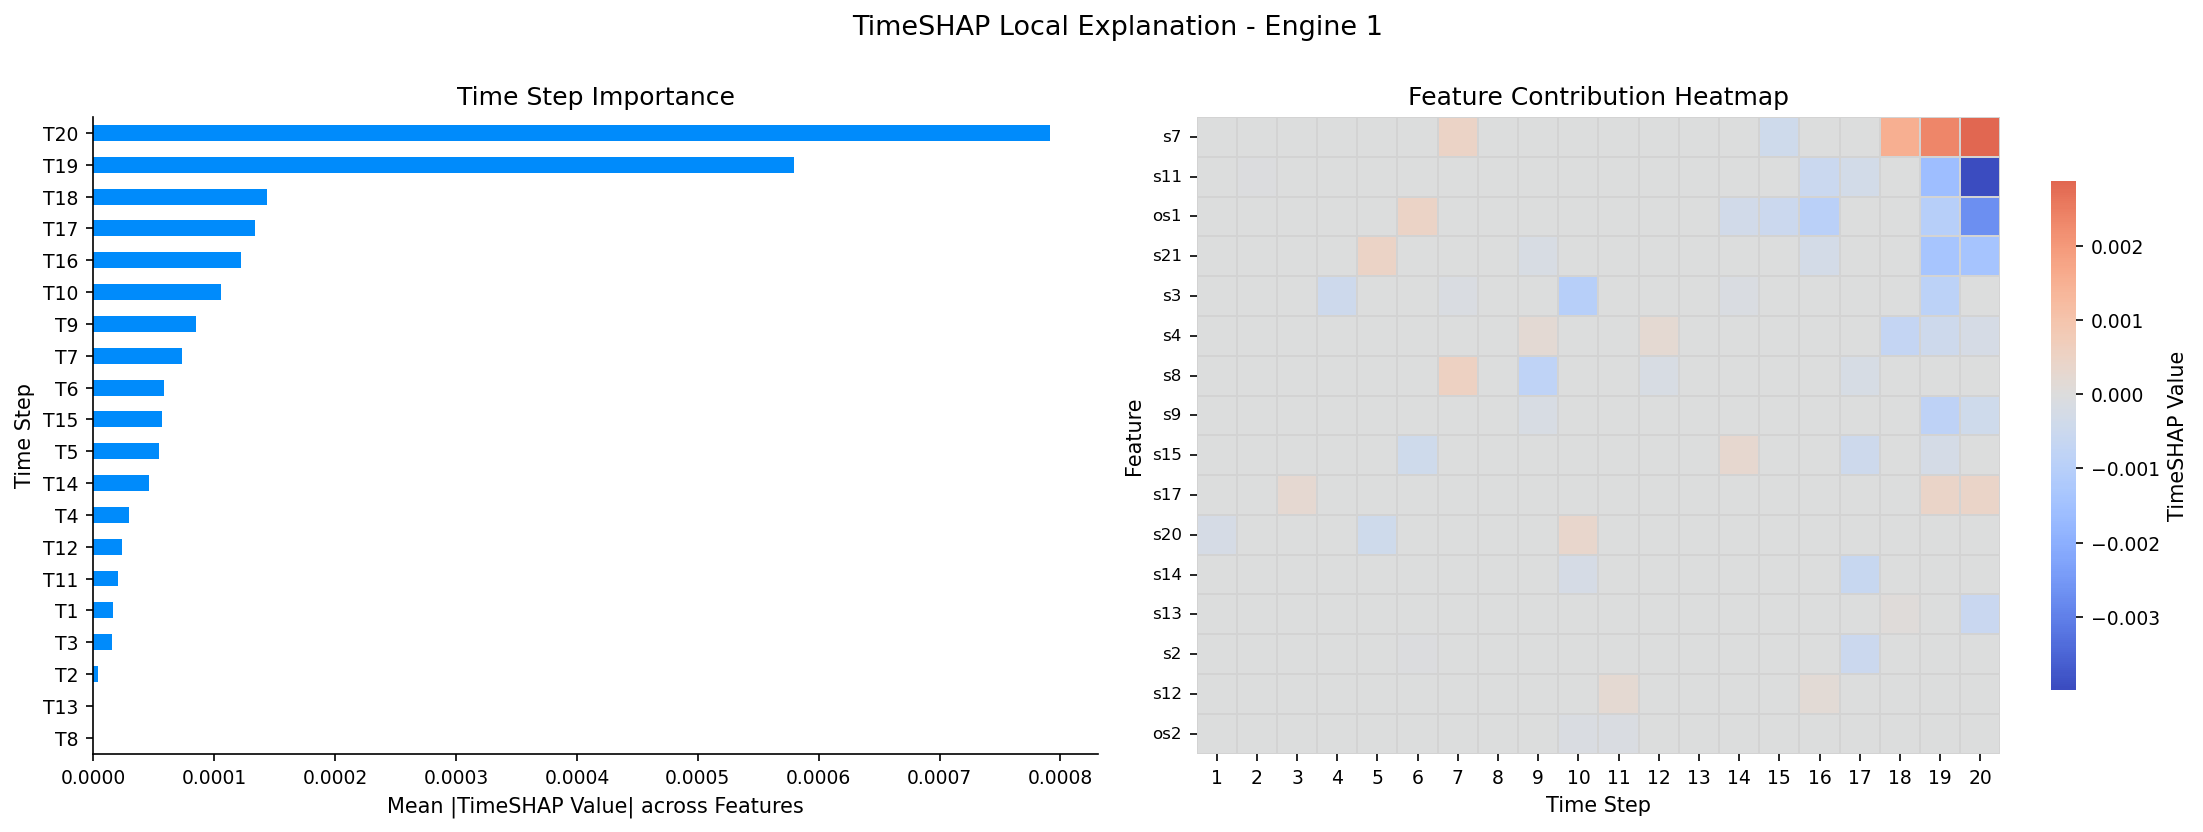


--- Generating combined plot for Engine 10 (Index 9) ---
  Generating Event Importance subplot...
  Generating Cell Importance Heatmap subplot...
    Combined plot saved to plots\timeshap_local_explanation_engine_10.png


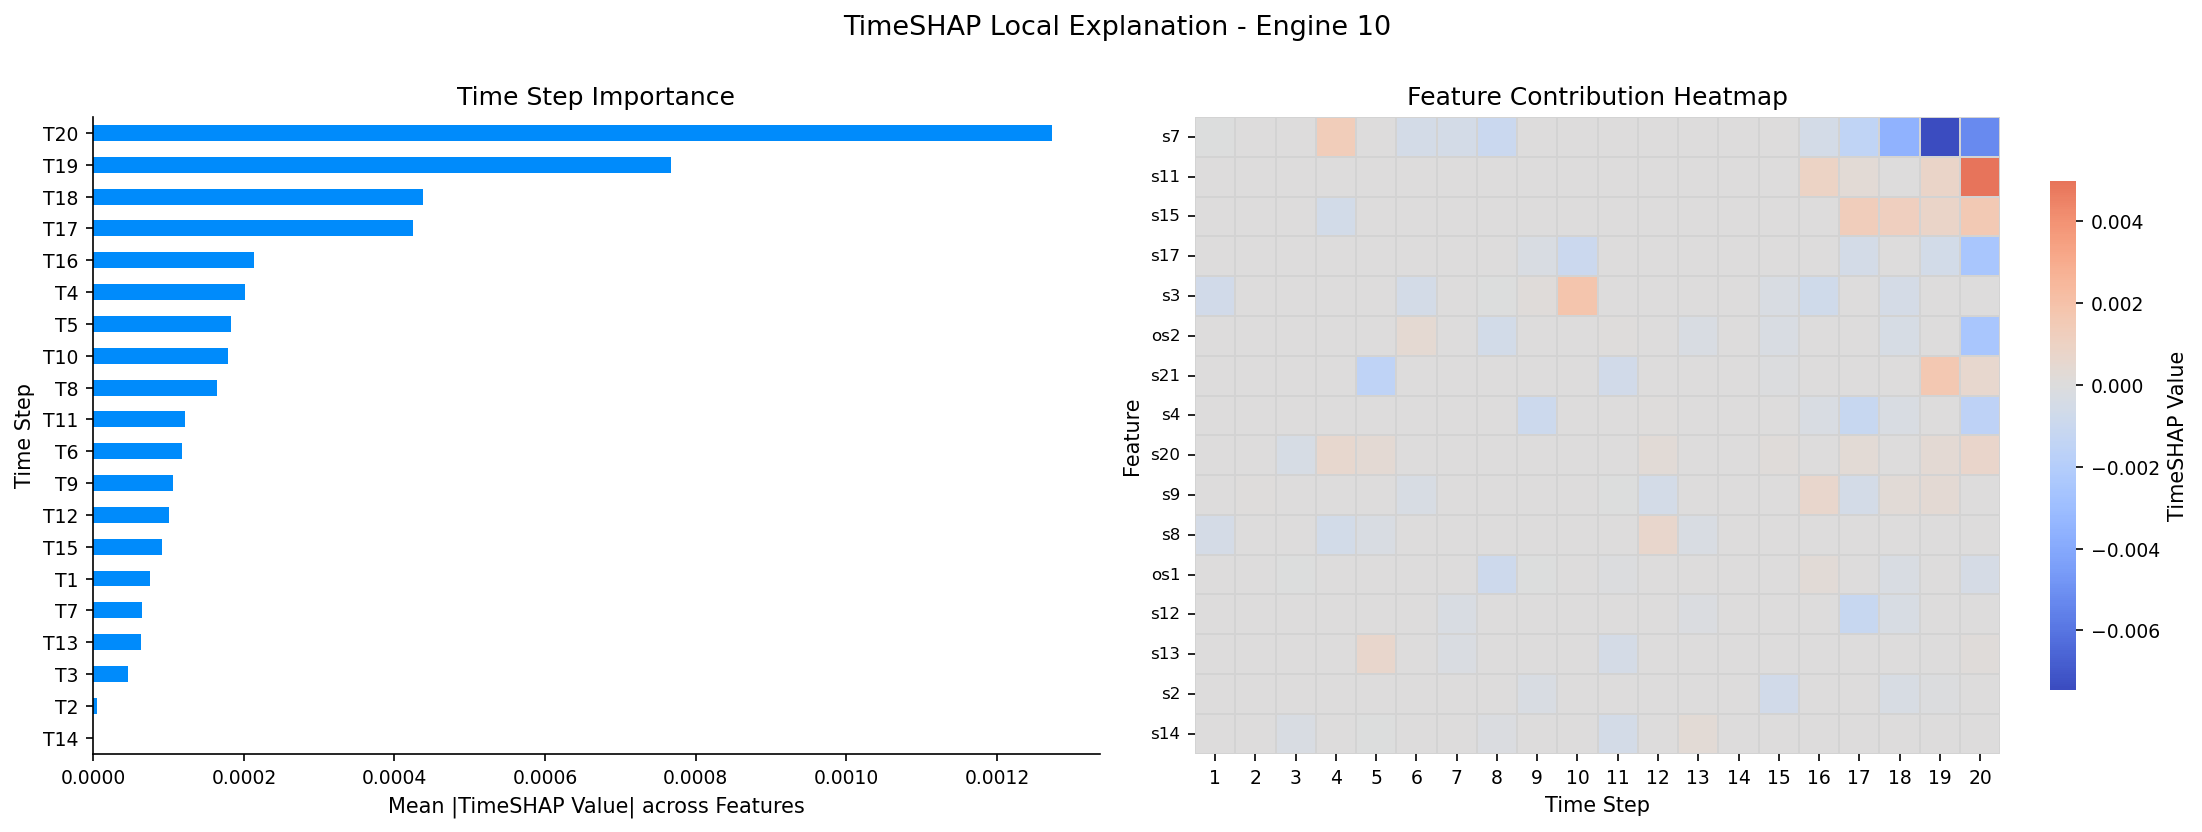


--- Generating combined plot for Engine 25 (Index 24) ---
  Generating Event Importance subplot...
  Generating Cell Importance Heatmap subplot...
    Combined plot saved to plots\timeshap_local_explanation_engine_25.png


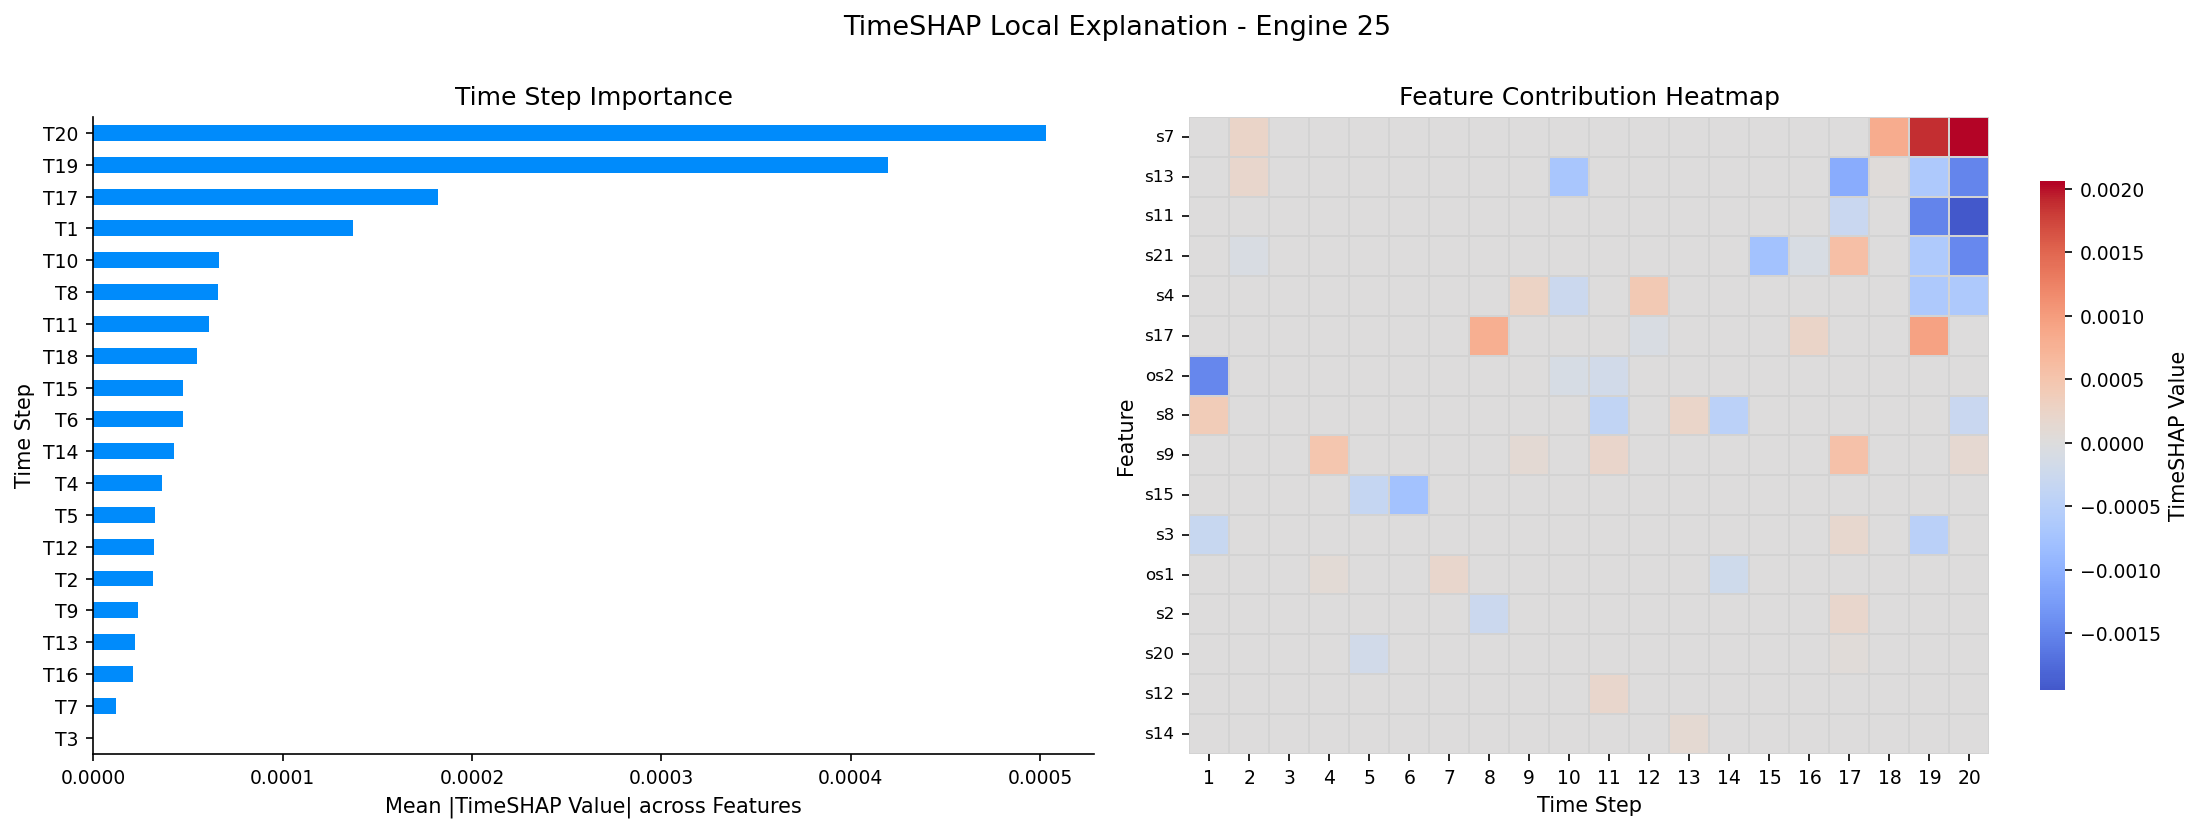


--- Generating combined plot for Engine 50 (Index 49) ---
  Generating Event Importance subplot...
  Generating Cell Importance Heatmap subplot...
    Combined plot saved to plots\timeshap_local_explanation_engine_50.png


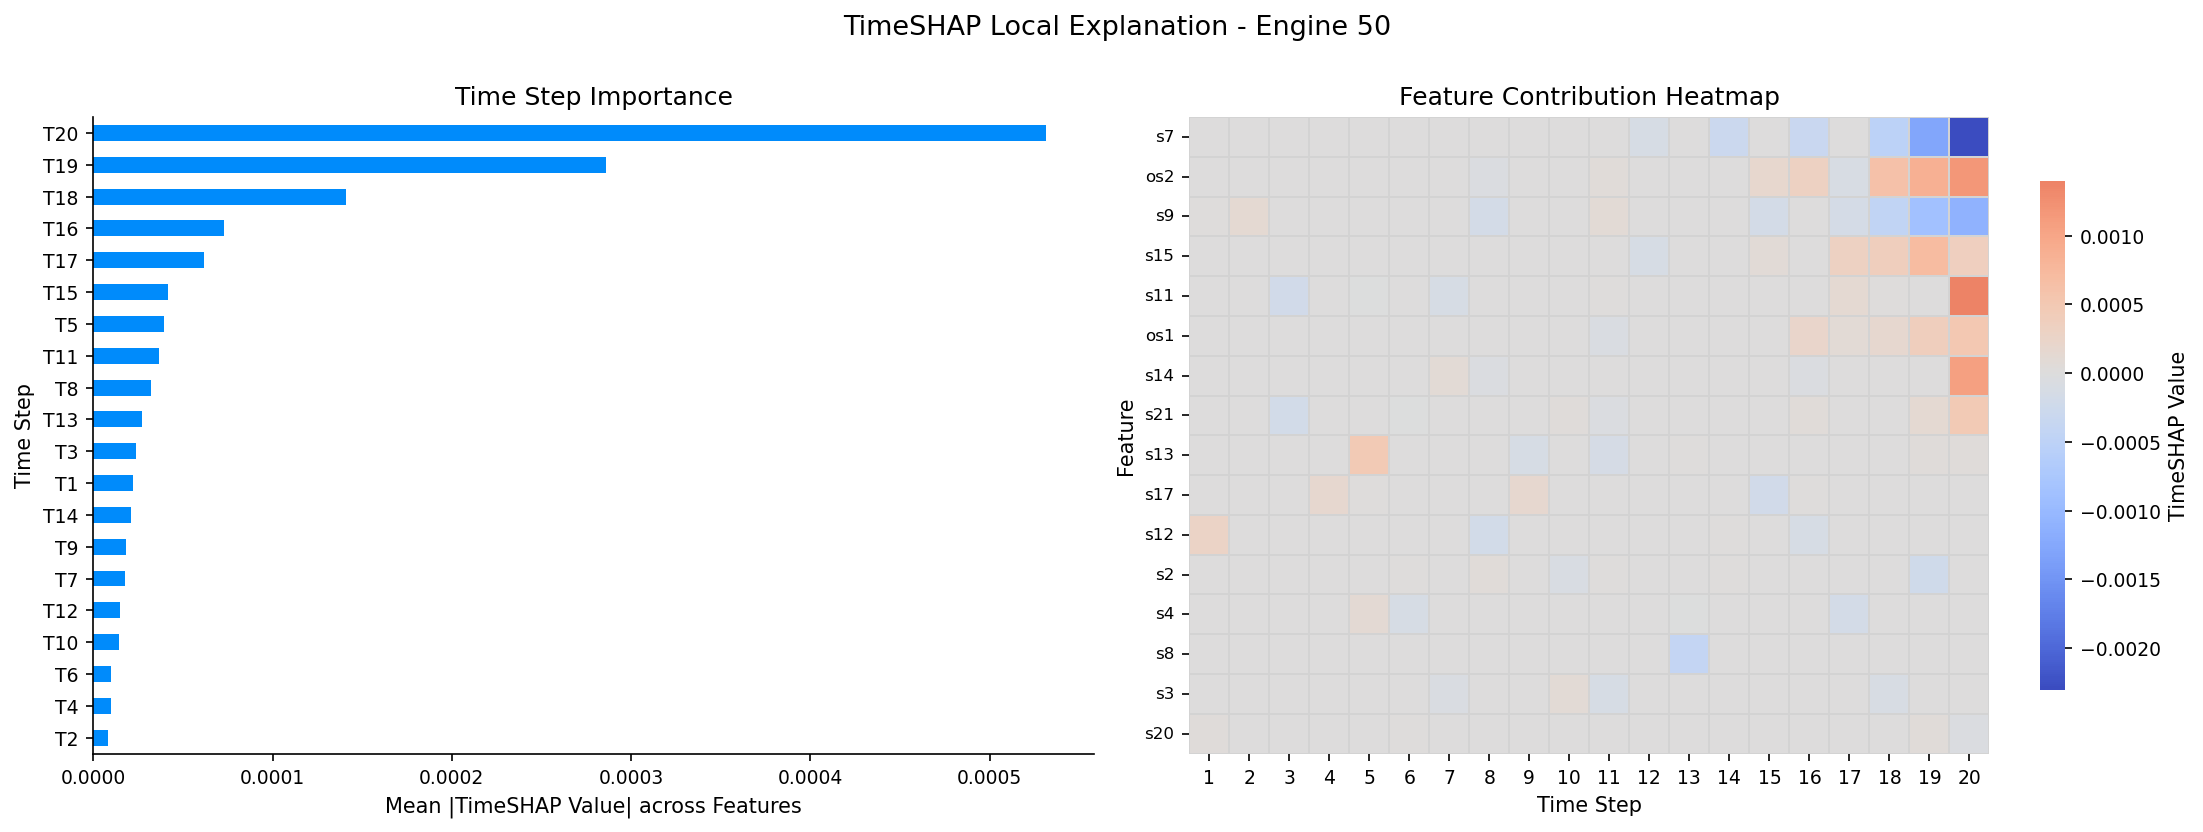


--- Finished Phase 3 Combined Local Plots ---


In [43]:
# Phase 3 Plotting - Combined Local Event Bar Plot & Heatmap per Engine

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns # Ensure seaborn is imported

print("\n--- Phase 3: Generating Combined Local TimeSHAP Plots per Engine ---")

# --- Define Plot Settings ---
figure_dpi = 150
# Adjust figsize for 1x2 layout (wider)
combined_local_figsize = (15, 5.5) # Adjust as needed (width, height inches)
title_fontsize = 12 # Slightly smaller for subplots
label_fontsize = 10
tick_fontsize = 9
plots_save_dir = "plots"
# os.makedirs(save_dir, exist_ok=True)

# Engines to plot
engine_indices_to_plot = [0, 9, 24, 49] # Engines 1, 10, 25, 50
engine_ids = [idx + 1 for idx in engine_indices_to_plot]

# Check if TimeSHAP results are available
# Assume computation_successful = True if ts_shap_vals exists and is not None
if 'ts_shap_vals' in locals() and ts_shap_vals is not None and computation_successful:

    # Loop through selected engine indices
    for i, engine_idx in enumerate(engine_indices_to_plot):
        engine_id_actual = engine_ids[i]
        print(f"\n--- Generating combined plot for Engine {engine_id_actual} (Index {engine_idx}) ---")

        # Get SHAP values for the current engine: shape (window, n_features) -> (20, 16)
        local_shap = ts_shap_vals[engine_idx]

        # Create ONE figure with TWO subplots (1 row, 2 columns) for this engine
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=combined_local_figsize, dpi=figure_dpi)
        fig.suptitle(f"TimeSHAP Local Explanation - Engine {engine_id_actual}", fontsize=title_fontsize+1, y=1.0) # Overall title

        plot_success_flags = [False, False] # Track success

        # --- Plot 1: Local Event Importance (Magnitude Bar Plot on axes[0]) ---
        try:
            ax_event = axes[0] # Target left subplot
            print(f"  Generating Event Importance subplot...")
            event_importance = np.mean(np.abs(local_shap), axis=1)
            time_labels = [f"T{t+1}" for t in range(window)]
            event_series = pd.Series(event_importance, index=time_labels)
            event_series_sorted = event_series.sort_values(ascending=True)

            event_series_sorted.plot.barh(ax=ax_event, color='#008bfb')

            # Styling subplot 1
            ax_event.set_title(f"Time Step Importance", fontsize=title_fontsize)
            ax_event.set_xlabel("Mean |TimeSHAP Value| across Features", fontsize=label_fontsize)
            ax_event.set_ylabel("Time Step", fontsize=label_fontsize)
            ax_event.tick_params(axis='both', labelsize=tick_fontsize)
            ax_event.spines[['top', 'right']].set_visible(False)
            plot_success_flags[0] = True
        except Exception as e:
            print(f"    Error generating Event Importance subplot: {e}")
            if 'ax_event' in locals(): ax_event.set_title("Error", fontsize=title_fontsize)

        # --- Plot 2: Local Cell Importance (Heatmap on axes[1]) ---
        try:
            ax_heatmap = axes[1] # Target right subplot
            print(f"  Generating Cell Importance Heatmap subplot...")

            # Rank features locally by magnitude
            local_feat_magnitude = np.mean(np.abs(local_shap), axis=0)
            local_indices_sorted_desc = np.argsort(local_feat_magnitude)[::-1]
            local_names_sorted = np.array(base_feature_names)[local_indices_sorted_desc]
            local_heatmap_data = local_shap[:, local_indices_sorted_desc]

            # Use coolwarm and specified linewidth
            cmap_choice = "coolwarm"
            sns.heatmap(
                local_heatmap_data.T, # Transpose -> (16, 20) features x time
                xticklabels=np.arange(1, window + 1), # Time steps 1-20
                yticklabels=local_names_sorted, # Ranked feature names
                cmap=cmap_choice,
                center=0,
                annot=False,
                linewidths=0.1, # Grid lines as requested
                linecolor='lightgrey',
                cbar_kws={'label': 'TimeSHAP Value', 'shrink': 0.8}, # Shrink color bar slightly
                ax=ax_heatmap
            )

            # Styling subplot 2
            ax_heatmap.set_title(f"Feature Contribution Heatmap", fontsize=title_fontsize)
            ax_heatmap.set_xlabel("Time Step", fontsize=label_fontsize)
            ax_heatmap.set_ylabel("Feature", fontsize=label_fontsize)
            ax_heatmap.tick_params(axis='x', labelsize=tick_fontsize, rotation=0)
            ax_heatmap.tick_params(axis='y', labelsize=tick_fontsize-1, rotation=0) # Slightly smaller feature names
            cbar = ax_heatmap.collections[0].colorbar
            cbar.ax.yaxis.label.set_size(label_fontsize)
            cbar.ax.tick_params(labelsize=tick_fontsize)
            # ax_heatmap.spines[['top', 'right']].set_visible(False) # Keep spines for heatmap

            plot_success_flags[1] = True
        except Exception as e:
            print(f"    Error generating Heatmap subplot: {e}")
            if 'ax_heatmap' in locals(): ax_heatmap.set_title("Error", fontsize=title_fontsize)


        # --- Adjust layout, Save, Show, Close the COMBINED Figure ---
        if all(plot_success_flags): # Only save if both plots were generated
             try:
                 plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust rect for suptitle
                 # Save the combined figure (PNG only)
                 filename = os.path.join(plots_save_dir, f"timeshap_local_explanation_engine_{engine_id_actual}.png")
                 plt.savefig(filename, dpi=figure_dpi, bbox_inches='tight')
                 print(f"    Combined plot saved to {filename}")
             except Exception as save_err:
                 print(f"    Error saving combined plot: {save_err}")

        plt.show() # Show the combined figure for the current engine
        plt.close(fig) # Close the figure before the next loop iteration

else:
    print("\nSkipping Local TimeSHAP plotting as values were not computed successfully.")

print("\n--- Finished Phase 3 Combined Local Plots ---")


--- Phase 3: Generating Final TimeSHAP Heatmap Plots ---
Preparing data for top 16 features...
Data prepared for: ['s12', 's4', 's9', 's7', 's13', 's20', 's21', 'os2', 's15', 's11', 's17', 's8', 's14', 's2', 's3', 'os1']

Generating Magnitude heatmap...
Magnitude heatmap saved to .\timeshap_feature_importance_heatmap.png


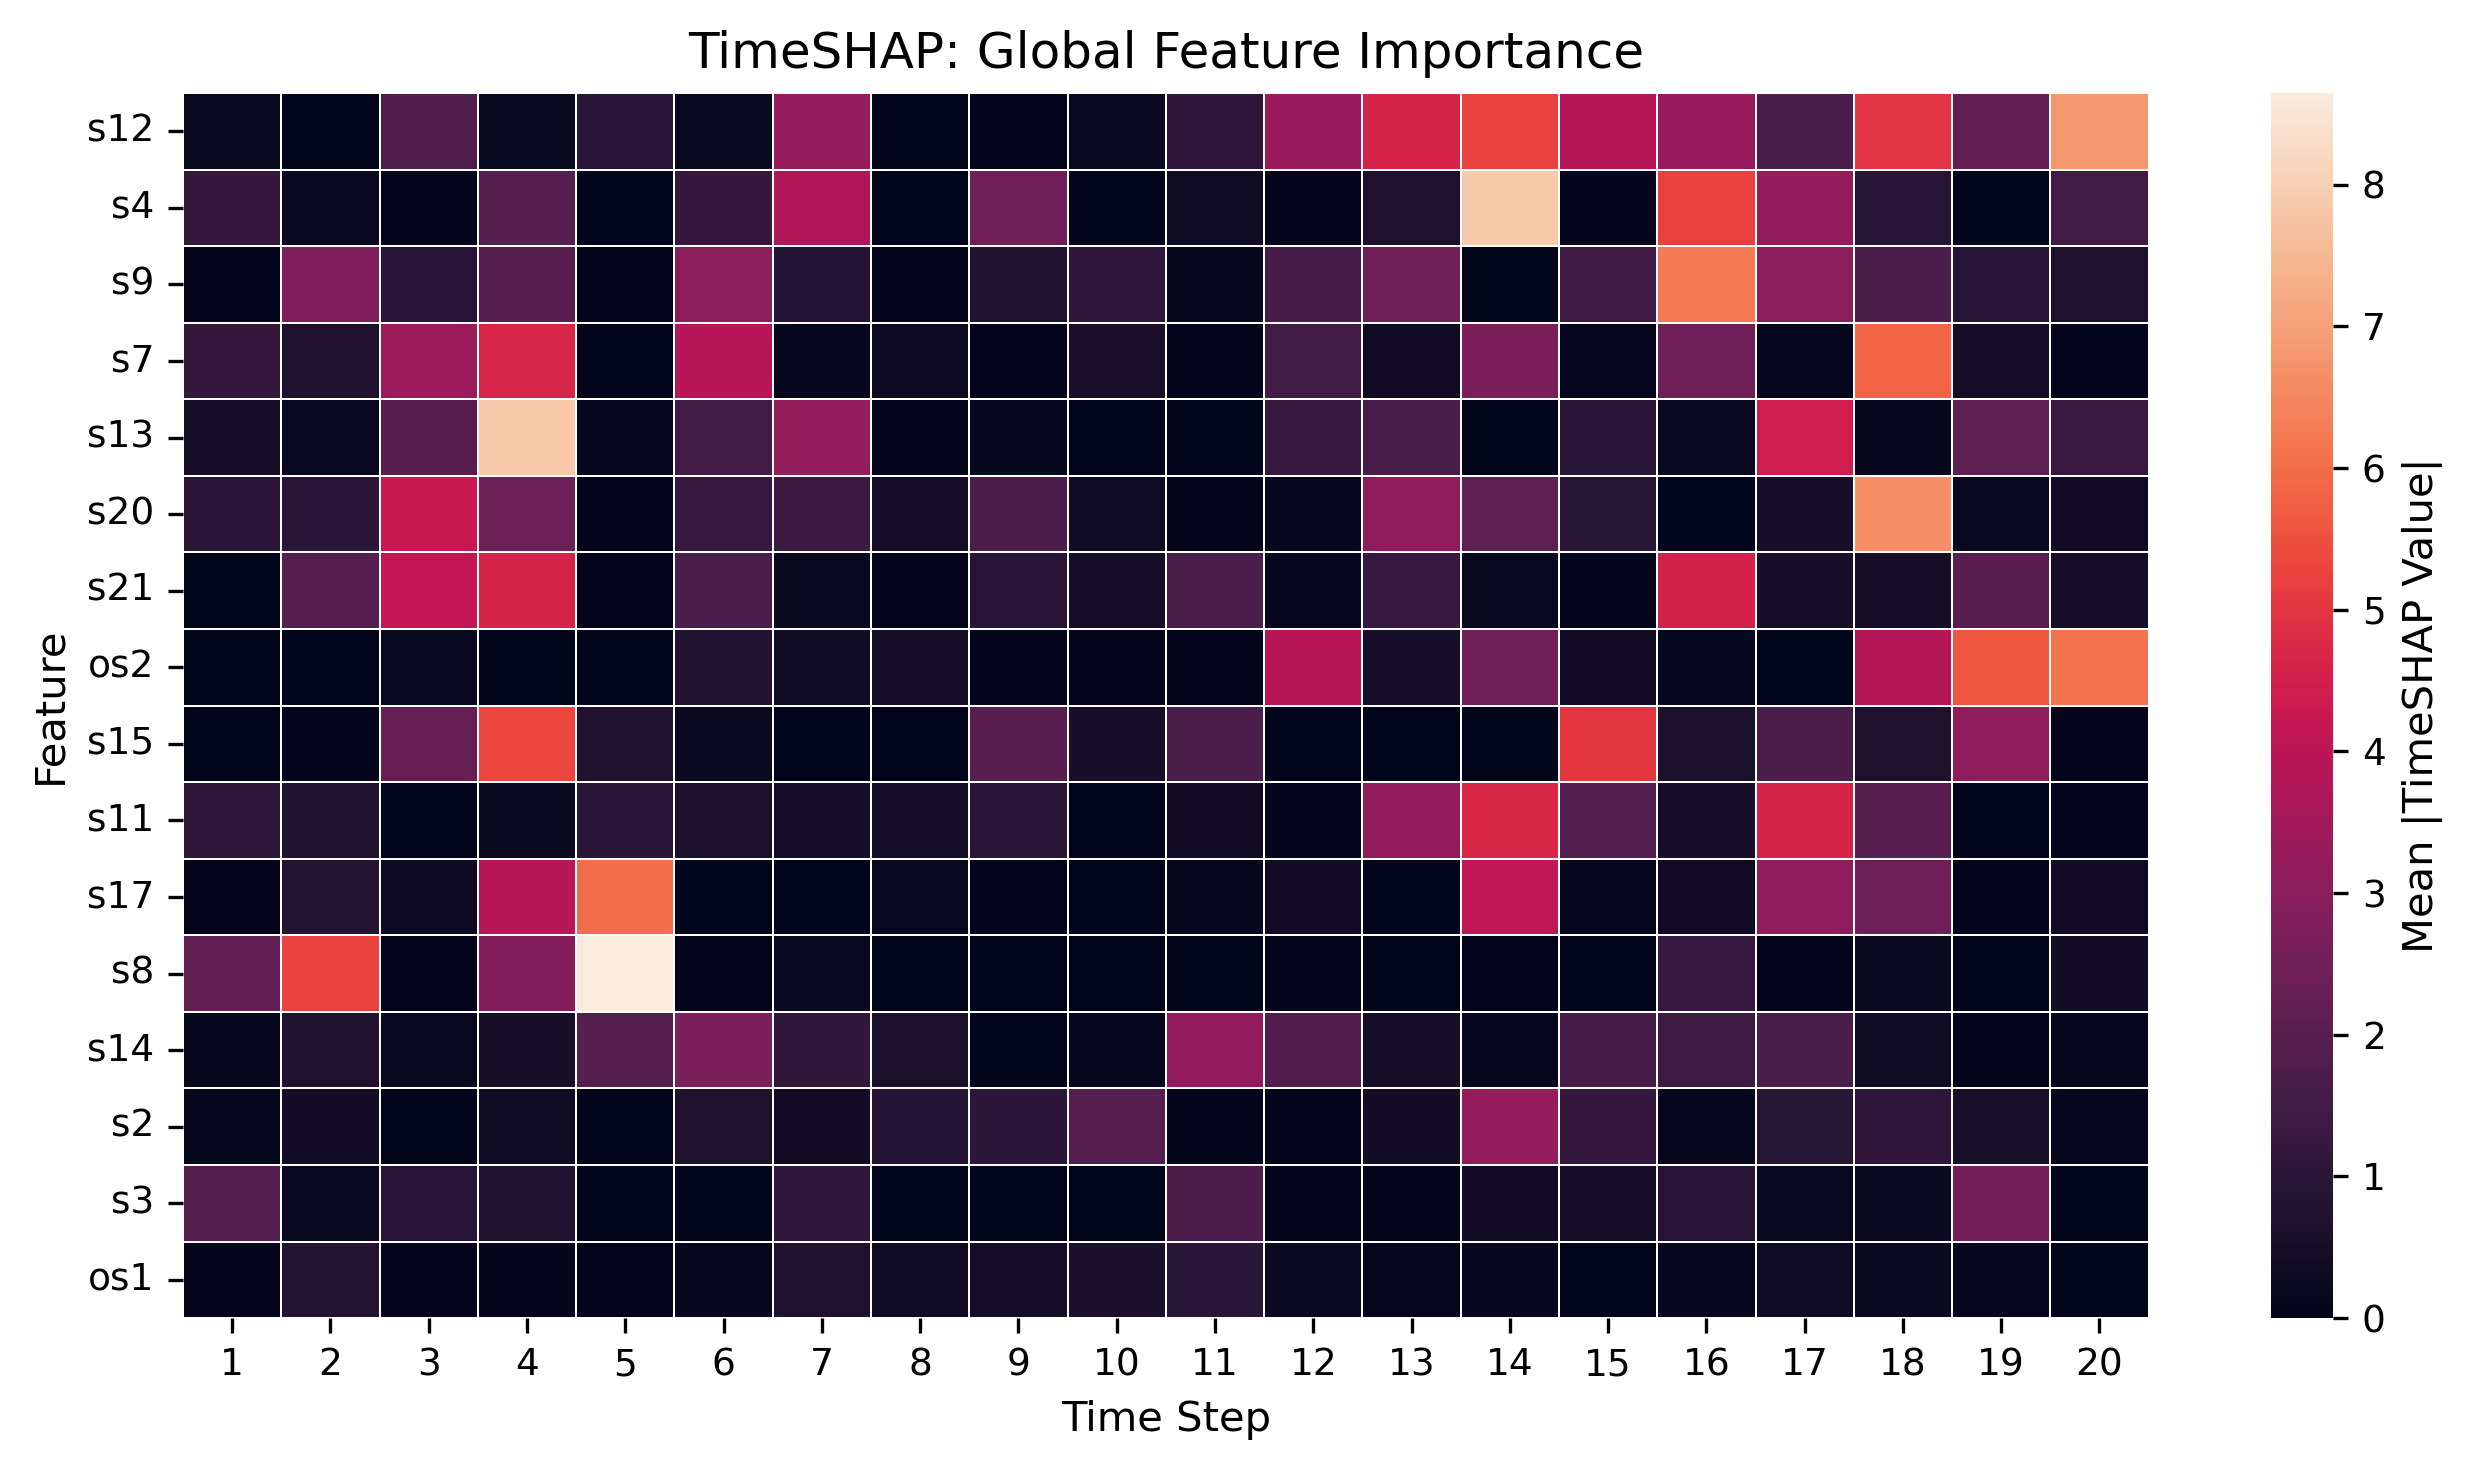


Generating Signed Mean heatmap...
Signed heatmap saved to .\timeshap_feature_contribution_heatmap.png


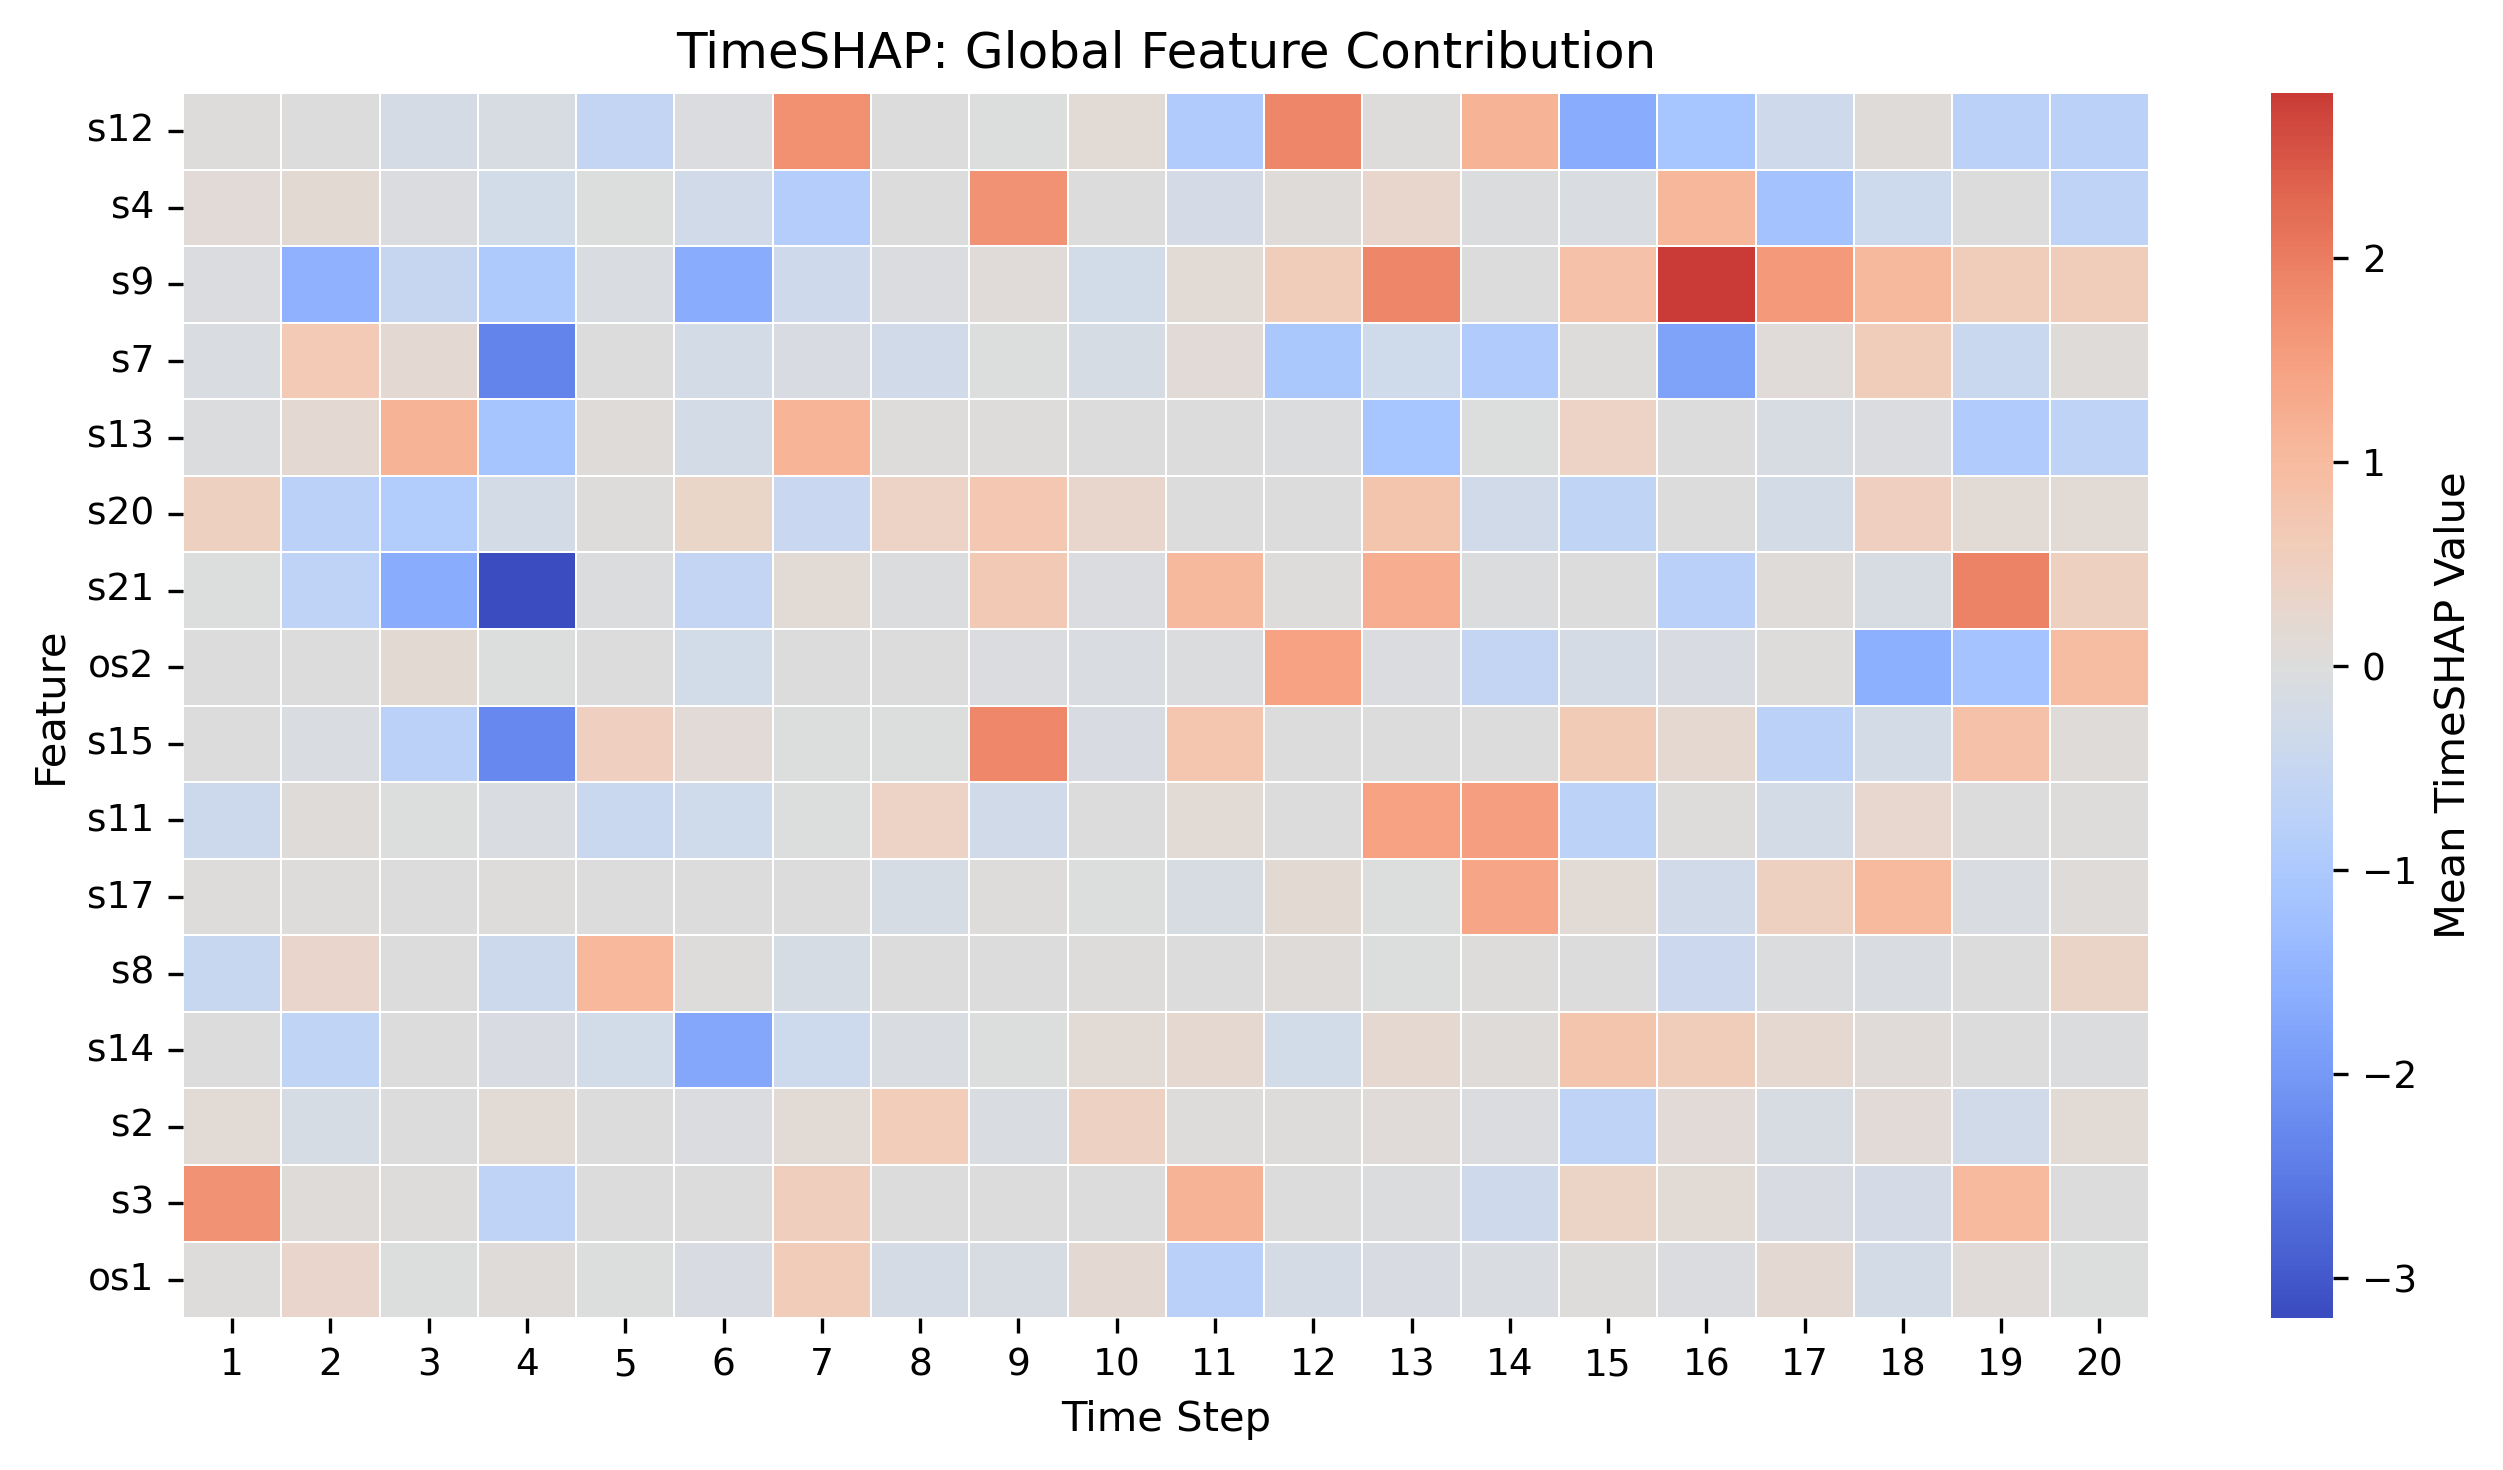


--- Finished Phase 3 Heatmap Plotting ---


In [45]:
# Final Combined TimeSHAP Heatmap Plotting Block

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

print("\n--- Phase 3: Generating Final TimeSHAP Heatmap Plots ---")

# --- Define Plot Settings ---
figure_dpi = 300 # Higher DPI for saved PNGs
heatmap_figsize = (9, 5) # Adjust as needed (width, height)
title_fontsize = 12
label_fontsize = 10
tick_fontsize = 9
n_top_features_heatmap = 16 # Number of features to display
plots_save_dir = "plots" # Save plots in current directory
# os.makedirs(save_dir, exist_ok=True) # Optional: Create save directory

# Check if TimeSHAP results are available
# Assume ts_shap_vals (100, 20, 16), base_feature_names, window, n_features exist
# Assume computation_successful = True
if 'ts_shap_vals' in locals() and ts_shap_vals is not None and computation_successful:

    # --- Pre-calculations (Do once for both plots) ---
    print(f"Preparing data for top {n_top_features_heatmap} features...")
    data_ready = False
    try:
        # Rank features by overall magnitude
        overall_magnitude = np.mean(np.abs(ts_shap_vals), axis=(0, 1))
        top_feature_indices = np.argsort(overall_magnitude)[-n_top_features_heatmap:]
        top_feature_indices_sorted = top_feature_indices[np.argsort(overall_magnitude[top_feature_indices])[::-1]]
        top_feature_names_sorted = np.array(base_feature_names)[top_feature_indices_sorted]

        # Calculate mean values over time (average across samples)
        mean_abs_shap_time = np.mean(np.abs(ts_shap_vals), axis=0) # Shape (window, n_features)
        mean_signed_shap_time = np.mean(ts_shap_vals, axis=0)    # Shape (window, n_features)

        # Select data for the top N features
        heatmap_data_abs = mean_abs_shap_time[:, top_feature_indices_sorted]    # Shape (window, n_top)
        heatmap_data_signed = mean_signed_shap_time[:, top_feature_indices_sorted] # Shape (window, n_top)

        print(f"Data prepared for: {top_feature_names_sorted.tolist()}")
        data_ready = True
    except Exception as calc_err:
        print(f"Error during pre-calculation for heatmaps: {calc_err}")

    if data_ready:
        # --- Plot 1: Magnitude Heatmap ---
        fig_abs, ax_abs = None, None # Initialize for finally block
        try:
            print(f"\nGenerating Magnitude heatmap...")
            fig_abs, ax_abs = plt.subplots(figsize=heatmap_figsize, dpi=figure_dpi)
            # Choose sequential colormap (e.g., 'YlOrRd', 'Reds', 'hot', 'rocket_r')
            cmap_abs = "rocket"

            sns.heatmap(
                heatmap_data_abs.T, # Transposed data (features x time)
                xticklabels=np.arange(1, window + 1), yticklabels=top_feature_names_sorted,
                cmap=cmap_abs, annot=False, linewidths=0.1, # No gridlines
                cbar_kws={'label': 'Mean |TimeSHAP Value|'}, ax=ax_abs
            )
            ax_abs.set_title(f"TimeSHAP: Global Feature Importance", fontsize=title_fontsize)
            ax_abs.set_xlabel("Time Step", fontsize=label_fontsize)
            ax_abs.set_ylabel("Feature", fontsize=label_fontsize)
            ax_abs.tick_params(axis='both', labelsize=tick_fontsize, rotation=0)
            ax_abs.spines[['top', 'right']].set_visible(False) # Remove top/right border
            cbar = ax_abs.collections[0].colorbar
            cbar.ax.yaxis.label.set_size(label_fontsize)
            cbar.ax.tick_params(labelsize=tick_fontsize)

            plt.tight_layout()
            png_filename = os.path.join(plots_save_dir, f"timeshap_feature_importance_heatmap.png")
            plt.savefig(png_filename, dpi=figure_dpi, bbox_inches='tight')
            print(f"Magnitude heatmap saved to {png_filename}")
            plt.show()
        except Exception as e:
            print(f"Error generating Magnitude TimeSHAP heatmap: {e}")
        finally:
            if fig_abs is not None: plt.close(fig_abs) # Ensure figure is closed


        # --- Plot 2: Signed Heatmap ---
        fig_signed, ax_signed = None, None # Initialize for finally block
        try:
            print(f"\nGenerating Signed Mean heatmap...")
            fig_signed, ax_signed = plt.subplots(figsize=heatmap_figsize, dpi=figure_dpi)
            # Choose diverging colormap (e.g., 'vlag', 'coolwarm', 'RdBu_r')
            cmap_signed = "coolwarm"

            sns.heatmap(
                heatmap_data_signed.T, # Transposed data (features x time)
                xticklabels=np.arange(1, window + 1), yticklabels=top_feature_names_sorted,
                cmap=cmap_signed, center=0, # Use diverging map centered at 0
                annot=False, linewidths=0.1, # No gridlines
                cbar_kws={'label': 'Mean TimeSHAP Value'}, ax=ax_signed
            )
            ax_signed.set_title(f"TimeSHAP: Global Feature Contribution", fontsize=title_fontsize)
            ax_signed.set_xlabel("Time Step", fontsize=label_fontsize)
            ax_signed.set_ylabel("Feature", fontsize=label_fontsize)
            ax_signed.tick_params(axis='both', labelsize=tick_fontsize, rotation=0)
            ax_signed.spines[['top', 'right']].set_visible(False) # Remove top/right border
            cbar = ax_signed.collections[0].colorbar
            cbar.ax.yaxis.label.set_size(label_fontsize)
            cbar.ax.tick_params(labelsize=tick_fontsize)

            plt.tight_layout()
            png_filename = os.path.join(plots_save_dir, f"timeshap_feature_contribution_heatmap.png")
            plt.savefig(png_filename, dpi=figure_dpi, bbox_inches='tight')
            print(f"Signed heatmap saved to {png_filename}")
            plt.show()
        except Exception as e:
            print(f"Error generating Signed TimeSHAP heatmap: {e}")
        finally:
            if fig_signed is not None: plt.close(fig_signed) # Ensure figure is closed

else:
    print("\nSkipping TimeSHAP heatmap plotting as values were not computed successfully.")

print("\n--- Finished Phase 3 Heatmap Plotting ---")